<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_UNOS_0310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c6a93dc5c8cc7cdb128780d94f654bd61dc1ff3166e92e020671872c59303af4
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_foundation_set.csv')
df = pd.read_csv('/content/drive/MyDrive/SyntheticData/UNOS_Cohort.csv')
real_df = df.copy()

# (Optional) Display first few rows
display(real_df.head())


Using device: cuda


Age Gender ABO        BMI     Na    Cr Dialysis   INR  Bili  Albumin  MELD  \
0   57      F   O  31.480705  137.0  2.66        N  2.10  43.9      4.1    39   
1   28      F   O  27.949687  127.0  0.50        N  3.20  24.8      2.8    32   
2   51      M   A  25.618483  148.0  2.31        N  2.16  42.6      2.8    37   
3   30      M   A  21.544936  130.0  1.07        N  2.48  24.6      3.4    30   
4   53      M   O  39.382391  141.0  0.61        N  1.20   1.3      3.2     9   

   outcome   tte     Etiology               Ethnicity diab_group_labeled  \
0        2     7      Alcohol                   White        No Diabetes   
1        2     4   Autoimmune                   White        No Diabetes   
2        2     2   Autoimmune  Black/African American        No Diabetes   
3        2    29  Cryptogenic                   White        No Diabetes   
4        2  1295         NASH         Hispanic/Latino           Diabetes   

  Encephalopathy_Status Ascites_Status  
0             Grade 1-2         Slight  
1                   NaN       Moderate  
2             Grade 1-2         Slight  
3                   NaN         Slight  
4             Grade 3-4            NaN

In [ ]:
# Create a random sample of 30% of the original dataframe
sample_size = 0.3  # 30%
sampled_df = real_df.sample(frac=sample_size, random_state=42)  # Setting random_state for reproducibility

# Check the shape of the sampled dataframe
print(f"Original dataframe shape: {real_df.shape}")
print(f"Sampled dataframe shape: {sampled_df.shape}")
print(f"Percentage of original data: {len(sampled_df) / len(real_df) * 100:.2f}%")

# Verify outcome distribution is preserved
if 'outcome' in real_df.columns:
    print("\nOutcome distribution in original data:")
    print(real_df['outcome'].value_counts(normalize=True) * 100)

    print("\nOutcome distribution in sampled data:")
    print(sampled_df['outcome'].value_counts(normalize=True) * 100)

Original dataframe shape: (48774, 18)
Sampled dataframe shape: (14632, 18)
Percentage of original data: 30.00%

Outcome distribution in original data:
outcome
2    70.334605
0    18.554968
1    11.110428
Name: proportion, dtype: float64

Outcome distribution in sampled data:
outcome
2    70.441498
0    18.193002
1    11.365500
Name: proportion, dtype: float64


In [ ]:
real_df = sampled_df

In [ ]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender', 'Dialysis']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
print("Real dataset shape:", real_df.shape)



# Verify the new shapes
print("Real dataset shape:", real_df.shape)
print("Synthetic dataset shape:", syn_df.shape)

# Verify columns are matching
print("\nSynthetic dataset columns:", list(syn_df.columns))
print("\nReal dataset columns:", list(real_df.columns))

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (14632, 18)
Real dataset shape: (14632, 18)
Synthetic dataset shape: (10000000, 18)

Synthetic dataset columns: ['Age', 'BMI', 'Na', 'Cr', 'INR', 'Bili', 'Albumin', 'MELD', 'tte', 'Gender', 'ABO', 'Dialysis', 'Etiology', 'Ethnicity', 'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status', 'outcome']

Real dataset columns: ['Age', 'Gender', 'ABO', 'BMI', 'Na', 'Cr', 'Dialysis', 'INR', 'Bili', 'Albumin', 'MELD', 'outcome', 'tte', 'Etiology', 'Ethnicity', 'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status']
Synthetic dataset shape: (10000000, 18)


In [ ]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Slight' 'Moderate' 'None' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4' 'Unknown/Not Reported']

Synthetic df unique values:

Ascites_Status categories: ['Slight' 'Moderate' 'None' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4' 'Unknown/Not Reported']


In [ ]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender', 'Dialysis']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M', 'Dialysis_N', 'Dialysis_Y']


In [ ]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [ ]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [ ]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (14632, 9)
Synthetic features shape: (10000000, 9)


In [ ]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=100000,
                 sim_threshold=15, dissim_threshold=90):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        self.weights = []

        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        # Pre-identify death cases for faster lookup
        death_indices = np.where(self.outcomes == 0)[0]
        death_times = self.times[death_indices]

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])

                if time_diff < sim_threshold:
                    label = 1.0
                    weight = 1.0
                    # Give higher weight if both are near 90 days
                    if self.outcomes[i] == 0 and abs(self.times[i] - 90) < 30:
                        weight = 2.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                    weight = 1.0
                    # Give higher weight if they straddle the 90-day mark
                    if self.outcomes[i] == 0 and ((self.times[i] < 90 and self.times[j] > 90) or
                                                 (self.times[j] < 90 and self.times[i] > 90)):
                        weight = 2.0
                else:
                    continue

                self.pairs.append((i, j))
                self.labels.append(label)
                self.weights.append(weight)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32),
                torch.tensor(self.weights[idx], dtype=torch.float32))

In [ ]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(syn_features,
                          syn_df["tte"].values,
                          syn_df["outcome"].values,
                          n_pairs=100000,
                          sim_threshold=15,     # Optimized for 90-day prediction
                          dissim_threshold=90  # Aligned with 90-day target
                          )  # Weighting factor for emphasis

pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 100000


In [ ]:
# class PairDataset(Dataset):
#     def __init__(self, features, times, outcomes, n_pairs=10000, sim_threshold=30, dissim_threshold=100):
#         self.features = np.array(features, dtype=np.float32)
#         self.times = np.array(times, dtype=np.float32)
#         self.outcomes = np.array(outcomes, dtype=np.float32)
#         self.pairs = []
#         self.labels = []
#         N = self.features.shape[0]
#         rng = np.random.RandomState(42)
#         count = 0

#         while count < n_pairs:
#             i = rng.randint(0, N)
#             j = rng.randint(0, N)
#             if i == j:
#                 continue

#             # Same outcome type (death, transplant, or censoring)
#             if self.outcomes[i] == self.outcomes[j]:
#                 time_diff = abs(self.times[i] - self.times[j])
#                 if time_diff < sim_threshold:
#                     label = 1.0
#                 elif time_diff > dissim_threshold:
#                     label = 0.0
#                 else:
#                     continue
#                 self.pairs.append((i, j))
#                 self.labels.append(label)
#                 count += 1

#     def __len__(self):
#         return len(self.pairs)

#     def __getitem__(self, idx):
#         i, j = self.pairs[idx]
#         return (torch.tensor(self.features[i], dtype=torch.float32),
#                 torch.tensor(self.features[j], dtype=torch.float32),
#                 torch.tensor(self.labels[idx], dtype=torch.float32))

In [ ]:
# # Create PairDataset and DataLoader for training
# pair_dataset = PairDataset(syn_features,
#                           syn_df["tte"].values,
#                           syn_df["outcome"].values,
#                           n_pairs=10000,
#                           sim_threshold=90,
#                           dissim_threshold=200)
# pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
# print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [ ]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def weighted_contrastive_loss(x1, x2, label, weight, margin=1.0):
    """
    Weighted contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    weight: importance weight for this pair
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Apply weights and take mean
    weighted_loss = weight * (loss_sim + loss_dissim)
    return torch.mean(weighted_loss)

# In the training loop
for x1, x2, label, weight in pair_loader:
    x1 = x1.to(device)
    x2 = x2.to(device)
    label = label.to(device)
    weight = weight.to(device)  # Add this line

    emb1 = model_metric(x1)
    emb2 = model_metric(x2)
    loss = weighted_contrastive_loss(emb1, emb2, label, weight, margin=1.0)  # Use weighted loss

    optimizer_metric.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)
    optimizer_metric.step()

In [ ]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

# First define the weighted contrastive loss function
def weighted_contrastive_loss(x1, x2, label, weight, margin=1.0):
    """
    Weighted contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    weight: importance weight for this pair
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Apply weights and take mean
    weighted_loss = weight * (loss_sim + loss_dissim)
    return torch.mean(weighted_loss)

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    # Update this line to unpack 4 values instead of 3
    for x1, x2, label, weight in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)
        weight = weight.to(device)  # Add this line

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        # Use the weighted loss function
        loss = weighted_contrastive_loss(emb1, emb2, label, weight, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.0569
Epoch 2/200, Loss: 0.0536
Epoch 3/200, Loss: 0.0518
Epoch 4/200, Loss: 0.0501
Epoch 5/200, Loss: 0.0494
Epoch 6/200, Loss: 0.0482
Epoch 7/200, Loss: 0.0478
Epoch 8/200, Loss: 0.0479
Epoch 9/200, Loss: 0.0474
Epoch 10/200, Loss: 0.0470
Epoch 11/200, Loss: 0.0466
Epoch 12/200, Loss: 0.0465
Epoch 13/200, Loss: 0.0462
Epoch 14/200, Loss: 0.0460
Epoch 15/200, Loss: 0.0459
Epoch 16/200, Loss: 0.0457
Epoch 17/200, Loss: 0.0455
Epoch 18/200, Loss: 0.0455
Epoch 19/200, Loss: 0.0456
Epoch 20/200, Loss: 0.0454
Epoch 21/200, Loss: 0.0453
Epoch 22/200, Loss: 0.0450
Epoch 23/200, Loss: 0.0451
Epoch 24/200, Loss: 0.0448
Epoch 25/200, Loss: 0.0449
Epoch 26/200, Loss: 0.0452
Epoch 27/200, Loss: 0.0449
Epoch 28/200, Loss: 0.0450
Epoch 29/200, Loss: 0.0445
Epoch 30/200, Loss: 0.0447
Epoch 31/200, Loss: 0.0447
Epoch 32/200, Loss: 0.0443
Epoch 33/200, Loss: 0.0445
Epoch 34/200, Loss: 0.0445
Epoch 35/200, Loss: 0.0445
Epoch 36/200, Loss: 0.0444
Epoch 37/200, Loss: 0.0444
Epoch 38/2

In [ ]:
# # Define contrastive loss function
# def contrastive_loss(x1, x2, label, margin=1.0):
#     """
#     Contrastive loss function
#     x1, x2: embeddings of pairs
#     label: 1 if similar, 0 if dissimilar
#     margin: minimum distance for dissimilar pairs
#     """
#     # Compute Euclidean distance between x1 and x2
#     d = torch.norm(x1 - x2, p=2, dim=1)
#     # Loss for similar pairs (label=1): want small distance
#     loss_sim = label * d**2
#     # Loss for dissimilar pairs (label=0): want distance > margin
#     loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
#     # Return mean loss
#     loss = torch.mean(loss_sim + loss_dissim)
#     return loss

In [ ]:
# num_epochs_metric = 200
# best_loss = float('inf')
# patience_counter = 0
# early_stop_patience = 20

# for epoch in range(num_epochs_metric):
#     model_metric.train()
#     total_loss = 0.0
#     batch_losses = []

#     for x1, x2, label in pair_loader:
#         x1 = x1.to(device)
#         x2 = x2.to(device)
#         label = label.to(device)

#         emb1 = model_metric(x1)
#         emb2 = model_metric(x2)
#         loss = contrastive_loss(emb1, emb2, label, margin=1.0)

#         optimizer_metric.zero_grad()
#         loss.backward()

#         # Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

#         optimizer_metric.step()
#         total_loss += loss.item() * x1.size(0)
#         batch_losses.append(loss.item())

#     avg_loss = total_loss / len(pair_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

#     scheduler.step(avg_loss)

#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1

#     if patience_counter >= early_stop_patience:
#         print("Early stopping triggered")
#         break

Epoch 1/200, Loss: 0.3116
Epoch 2/200, Loss: 0.2148
Epoch 3/200, Loss: 0.1931
Epoch 4/200, Loss: 0.1853
Epoch 5/200, Loss: 0.1771
Epoch 6/200, Loss: 0.1693
Epoch 7/200, Loss: 0.1703
Epoch 8/200, Loss: 0.1652
Epoch 9/200, Loss: 0.1644
Epoch 10/200, Loss: 0.1586
Epoch 11/200, Loss: 0.1585
Epoch 12/200, Loss: 0.1566
Epoch 13/200, Loss: 0.1546
Epoch 14/200, Loss: 0.1501
Epoch 15/200, Loss: 0.1509
Epoch 16/200, Loss: 0.1472
Epoch 17/200, Loss: 0.1456
Epoch 18/200, Loss: 0.1484
Epoch 19/200, Loss: 0.1464
Epoch 20/200, Loss: 0.1453
Epoch 21/200, Loss: 0.1419
Epoch 22/200, Loss: 0.1402
Epoch 23/200, Loss: 0.1386
Epoch 24/200, Loss: 0.1385
Epoch 25/200, Loss: 0.1366
Epoch 26/200, Loss: 0.1340
Epoch 27/200, Loss: 0.1326
Epoch 28/200, Loss: 0.1328
Epoch 29/200, Loss: 0.1309
Epoch 30/200, Loss: 0.1308
Epoch 31/200, Loss: 0.1296
Epoch 32/200, Loss: 0.1289
Epoch 33/200, Loss: 0.1297
Epoch 34/200, Loss: 0.1297
Epoch 35/200, Loss: 0.1283
Epoch 36/200, Loss: 0.1282
Epoch 37/200, Loss: 0.1268
Epoch 38/2

In [ ]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/10000000 samples
Processed 10000/10000000 samples
Processed 20000/10000000 samples
Processed 30000/10000000 samples
Processed 40000/10000000 samples
Processed 50000/10000000 samples
Processed 60000/10000000 samples
Processed 70000/10000000 samples
Processed 80000/10000000 samples
Processed 90000/10000000 samples
Processed 100000/10000000 samples
Processed 110000/10000000 samples
Processed 120000/10000000 samples
Processed 130000/10000000 samples
Processed 140000/10000000 samples
Processed 150000/10000000 samples
Processed 160000/10000000 samples
Processed 170000/10000000 samples
Processed 180000/10000000 samples
Processed 190000/10000000 samples
Processed 200000/10000000 samples
Processed 210000/10000000 samples
Processed 220000/10000000 samples
Processed 230000/10000000 samples
Processed 240000/10000000 samples
Processed 250000/10000000 samples
Processed 260000/10000000 samples
Processed 270000/10000000 samples
Processed 280000/10000000 sa

In [ ]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])
    creatinine = min(3.0, max(1.0, row['Cr']))
    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for both dataframes
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)


# Display sample results for verification
print("\nMayo DF sample:")
print(real_df[['Gender', 'Bili', 'Na', 'INR',
               'Cr', 'Albumin', 'meld3']].head())




Mayo DF sample:
  Gender  Bili     Na   INR    Cr  Albumin  meld3
0      F   4.9  134.0  1.40  0.90      2.8     20
1      M  34.1  133.0  2.20  5.94      2.7     41
2      F   3.3  135.0  3.80  0.91      3.4     26
3      F   5.7  135.0  1.69  0.94      2.5     23
4      M   0.4  139.0  1.20  1.02      4.0      8


In [ ]:
pip install tqdm_joblib

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 1000
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# # 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
# def fast_km_median(times, events):
#     """
#     Compute a Kaplan-Meier median survival time from a small sample.
#     Assumes times and events are 1D NumPy arrays of length n.
#     This simple implementation sorts the times, computes the survival function,
#     and returns the first time when survival falls below 0.5.
#     """
#     # Sort times and events by times.
#     order = np.argsort(times)
#     times = times[order]
#     events = events[order]

#     n = len(times)
#     survival = 1.0
#     median_time = None
#     at_risk = n
#     # Loop over each unique time.
#     for t, e in zip(times, events):
#         if at_risk > 0:
#             survival *= (1 - e / at_risk)
#         if survival <= 0.5:
#             median_time = t
#             break
#         at_risk -= 1
#     # If survival never drops below 0.5, fallback to max observed time.
#     if median_time is None:
#         median_time = times[-1]
#     return median_time

# # 4. Define a function to compute the local median death TTE using the fast method.
# def compute_local_median_death_fast(idx):
#     neighbor_idxs = indices_all[idx]
#     neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
#     neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
#     return fast_km_median(neighbor_tte, neighbor_event)

# # 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
# n_real = real_embeddings.shape[0]
# with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
#     predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
#         delayed(compute_local_median_death_fast)(i) for i in range(n_real)
#     )
# predicted_death_medians = np.array(predicted_death_medians)

# # 6. Add the predicted death-based TTE to your real_df.
# real_df['predicted_death_tte'] = predicted_death_medians

# # Optional: display a sample of the predictions.
# print(real_df[['predicted_death_tte']].head())


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Define the neighbor sizes to experiment with
neighbor_sizes = [100, 200, 300, 500, 750, 1000]

# Function to compute Kaplan-Meier median survival from a small sample
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    """
    # Sort times and events by times
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n

    # Loop over each unique time
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1

    # If survival never drops below 0.5, fallback to max observed time
    if median_time is None:
        median_time = times[-1]

    return median_time

# Function to compute local median with variable k (using pre-computed indices)
def compute_local_median_with_k(idx, k, indices, syn_df):
    """
    Compute median survival using only k nearest neighbors
    """
    # Use only the first k neighbors
    neighbor_idxs = indices[idx, :k]
    neighbor_tte = syn_df.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# Generate predictions for different neighbor counts
def generate_neighbor_predictions(real_df, indices_all, syn_df_processed):
    """
    Generate predictions using different numbers of neighbors
    """
    n_real = len(real_df)

    # Process synthetic data once
    syn_df = syn_df_processed.copy()
    # Ensure we have death_event and death_tte columns
    if 'death_event' not in syn_df.columns:
        syn_df['death_event'] = syn_df['outcome'].apply(lambda x: 1 if x == 0 else 0)
    if 'death_tte' not in syn_df.columns:
        syn_df['death_tte'] = syn_df['tte']

    print(f"Generating predictions for {len(neighbor_sizes)} different neighbor counts")

    # Generate predictions for each neighbor size
    for k in neighbor_sizes:
        print(f"\nComputing predictions with k={k} neighbors")

        # Use parallel processing with progress bar
        with tqdm_joblib(tqdm(desc=f"Processing with k={k}", total=n_real)) as progress_bar:
            predictions = Parallel(n_jobs=-1, backend="threading")(
                delayed(compute_local_median_with_k)(i, k, indices_all, syn_df)
                for i in range(n_real)
            )

        # Add predictions to real_df
        column_name = f'predicted_death_tte_k{k}'
        real_df[column_name] = np.array(predictions)

        # Print basic stats about predictions
        print(f"  Mean prediction: {np.mean(predictions):.2f} days")
        print(f"  Median prediction: {np.median(predictions):.2f} days")
        print(f"  Range: {np.min(predictions):.2f} to {np.max(predictions):.2f} days")

    return real_df

# Run the function to generate predictions
# Note: This assumes indices_all and syn_df_processed are already available
try:
    print("Starting generation of predictions with different neighbor counts")
    real_df = generate_neighbor_predictions(real_df, indices_all, syn_df_processed)
    print("\nFinished generating predictions")
    print("New columns added:", [f'predicted_death_tte_k{k}' for k in neighbor_sizes])
except Exception as e:
    print(f"Error generating predictions: {str(e)}")

Starting generation of predictions with different neighbor counts
Generating predictions for 6 different neighbor counts

Computing predictions with k=100 neighbors


Processing with k=100:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 747.48 days
  Median prediction: 427.17 days
  Range: 3.80 to 2981.93 days

Computing predictions with k=200 neighbors



Processing with k=200:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 745.21 days
  Median prediction: 436.88 days
  Range: 4.00 to 2981.93 days

Computing predictions with k=300 neighbors




Processing with k=300:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 744.05 days
  Median prediction: 442.67 days
  Range: 4.00 to 2981.59 days

Computing predictions with k=500 neighbors





Processing with k=500:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 741.95 days
  Median prediction: 446.10 days
  Range: 4.00 to 2981.93 days

Computing predictions with k=750 neighbors






Processing with k=750:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 740.24 days
  Median prediction: 450.39 days
  Range: 4.00 to 2981.93 days

Computing predictions with k=1000 neighbors







Processing with k=1000:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

Processing with k=750:   0%|          | 0/14632 [00:30<?, ?it/s]


  Mean prediction: 739.84 days
  Median prediction: 452.07 days
  Range: 4.00 to 2981.59 days

Finished generating predictions
New columns added: ['predicted_death_tte_k100', 'predicted_death_tte_k200', 'predicted_death_tte_k300', 'predicted_death_tte_k500', 'predicted_death_tte_k750', 'predicted_death_tte_k1000']


Using meld3 as the MELD score column
Analyzing time point: 7 days
Analyzing time point: 14 days
Analyzing time point: 30 days
Analyzing time point: 90 days
Analyzing time point: 180 days
Analyzing time point: 360 days

Concordance Indices by Time Point and Neighbor Count:
   Time   meld   k100  k100+meld   k200  k200+meld   k300  k300+meld   k500  k500+meld   k750  k750+meld  k1000  k1000+meld
0     7  0.880  0.903      0.889  0.903      0.890  0.902      0.890  0.902      0.890  0.902      0.890  0.902       0.890
1    14  0.886  0.903      0.893  0.904      0.894  0.904      0.894  0.904      0.895  0.904      0.895  0.904       0.895
2    30  0.877  0.893      0.884  0.894      0.885  0.895      0.885  0.895      0.886  0.895      0.886  0.895       0.886
3    90  0.841  0.854      0.847  0.856      0.847  0.857      0.848  0.857      0.848  0.857      0.848  0.857       0.848
4   180  0.813  0.826      0.819  0.827      0.820  0.829      0.820  0.828      0.820  0.828      0.820  0

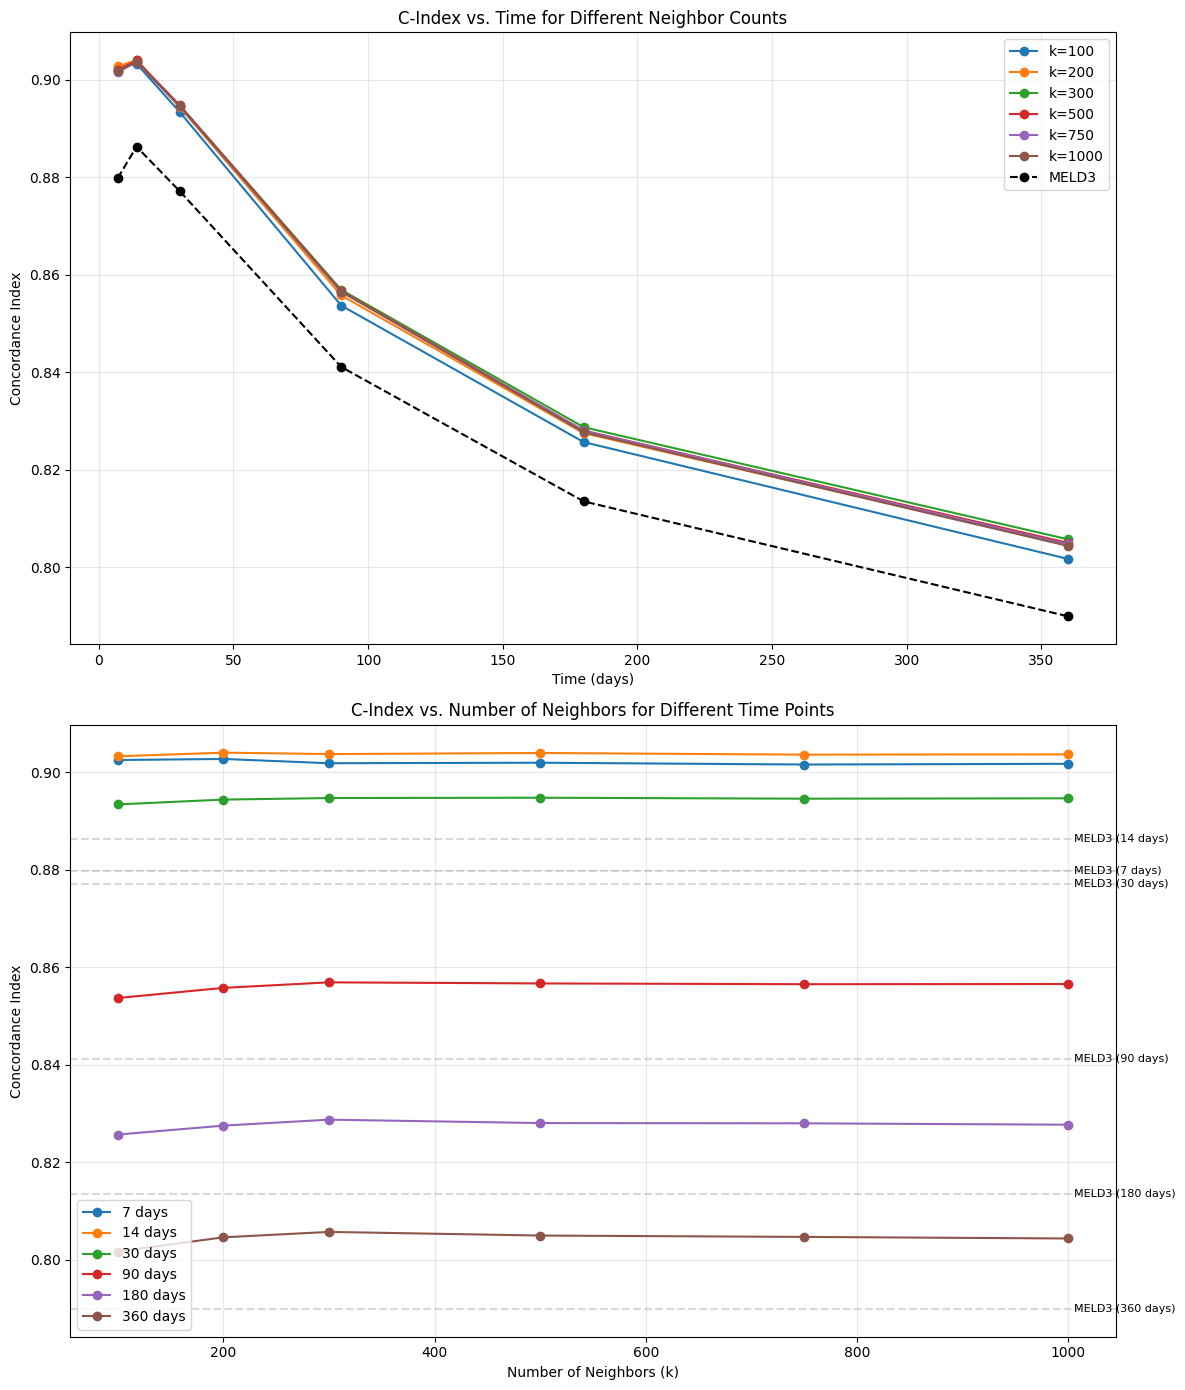

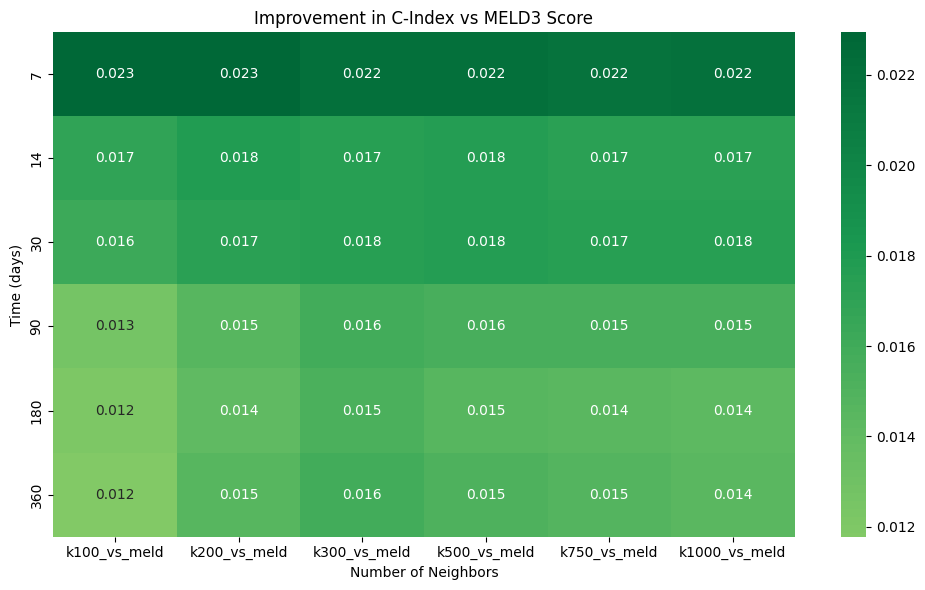


Optimal Number of Neighbors for Each Time Point:
             best_k  best_c_index  meld3_c_index  improvement
Time (days)                                                  
7             200.0         0.903          0.880        0.023
14            200.0         0.904          0.886        0.018
30            500.0         0.895          0.877        0.018
90            300.0         0.857          0.841        0.016
180           300.0         0.829          0.813        0.015
360           300.0         0.806          0.790        0.016


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for analysis
time_points = [7, 14, 30, 90, 180, 360]
neighbor_sizes = [100, 200, 300, 500, 750, 1000]

# Function to prepare survival data
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.
    """
    analysis_df = df.copy()
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Compare concordance indices for different numbers of neighbors
def compare_neighbor_concordance(real_df):
    # Use 'meld3' directly instead of searching
    meld_col = 'meld3'

    if meld_col not in real_df.columns:
        raise ValueError(f"'{meld_col}' column not found in the dataframe")

    print(f"Using {meld_col} as the MELD score column")

    # Dictionary to store all results
    all_results = {}

    # Run analysis for each time point
    for t in time_points:
        print(f"Analyzing time point: {t} days")
        # Prepare survival data for the current time point
        analysis_df = prepare_survival_data(real_df, max_time=t)

        time_results = {}

        # Get c-index for MELD (baseline)
        cph_meld = CoxPHFitter()
        data_meld = analysis_df[['tte', 'death_event', meld_col]].copy()
        cph_meld.fit(data_meld, duration_col='tte', event_col='death_event', show_progress=False)
        time_results['meld'] = cph_meld.concordance_index_

        # Get c-index for each neighbor size
        for k in neighbor_sizes:
            col_name = f'predicted_death_tte_k{k}'
            if col_name not in analysis_df.columns:
                print(f"Warning: Column {col_name} not found, skipping")
                continue

            # Model using predictions from k neighbors
            cph_k = CoxPHFitter()
            data_k = analysis_df[['tte', 'death_event', col_name]].copy()
            cph_k.fit(data_k, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}'] = cph_k.concordance_index_

            # Combined model (predictions + MELD)
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event', col_name, meld_col]].copy()
            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}+meld'] = cph_combined.concordance_index_

        all_results[t] = time_results

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = 'Time'
    results_df.reset_index(inplace=True)

    return results_df

# Run the comparison and create visualizations
try:
    # Run the comparison analysis
    concordance_results = compare_neighbor_concordance(real_df)

    # Print tabular results
    print("\nConcordance Indices by Time Point and Neighbor Count:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(concordance_results.round(3))

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # Plot 1: C-index vs time for different neighbor counts
    ax1 = axes[0]
    for k in neighbor_sizes:
        if f'k{k}' in concordance_results.columns:
            ax1.plot(concordance_results['Time'], concordance_results[f'k{k}'], marker='o', label=f'k={k}')
    ax1.plot(concordance_results['Time'], concordance_results['meld'], marker='o', linestyle='--', color='black', label='MELD3')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Concordance Index')
    ax1.set_title('C-Index vs. Time for Different Neighbor Counts')
    ax1.grid(alpha=0.3)
    ax1.legend()

    # Plot 2: C-index vs neighbor count for different time points
    ax2 = axes[1]
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = []
        ks = []
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values.append(row[f'k{k}'].iloc[0])
                ks.append(k)
        if k_values:
            ax2.plot(ks, k_values, marker='o', label=f'{t} days')

    # Add MELD reference lines
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        meld_value = row['meld'].iloc[0]
        ax2.axhline(y=meld_value, linestyle='--', alpha=0.3, color='gray')
        ax2.text(max(neighbor_sizes) + 5, meld_value, f'MELD3 ({t} days)', fontsize=8, va='center')

    ax2.set_xlabel('Number of Neighbors (k)')
    ax2.set_ylabel('Concordance Index')
    ax2.set_title('C-Index vs. Number of Neighbors for Different Time Points')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('c_index_comparison.png', dpi=300)
    plt.show()

    # Create heatmap of improvement over MELD3
    improvement_df = concordance_results.copy()
    for k in neighbor_sizes:
        if f'k{k}' in improvement_df.columns:
            improvement_df[f'k{k}_vs_meld'] = improvement_df[f'k{k}'] - improvement_df['meld']

    # Select improvement columns for heatmap
    heatmap_cols = [f'k{k}_vs_meld' for k in neighbor_sizes if f'k{k}_vs_meld' in improvement_df.columns]
    if heatmap_cols:
        heatmap_data = improvement_df[['Time'] + heatmap_cols]
        heatmap_data = heatmap_data.set_index('Time')

        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
        plt.title('Improvement in C-Index vs MELD3 Score')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Time (days)')
        plt.tight_layout()
        plt.savefig('c_index_improvement_heatmap.png', dpi=300)
        plt.show()

    # Find optimal number of neighbors for each time point
    optimal_neighbors = {}
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = {}
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values[k] = row[f'k{k}'].iloc[0]

        if k_values:
            best_k = max(k_values, key=k_values.get)
            best_c = k_values[best_k]
            meld_c = row['meld'].iloc[0]
            optimal_neighbors[t] = {
                'best_k': best_k,
                'best_c_index': best_c,
                'meld3_c_index': meld_c,
                'improvement': best_c - meld_c
            }

    print("\nOptimal Number of Neighbors for Each Time Point:")
    optimal_df = pd.DataFrame(optimal_neighbors).T
    optimal_df.index.name = 'Time (days)'
    print(optimal_df.round(3))

except Exception as e:
    print(f"Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

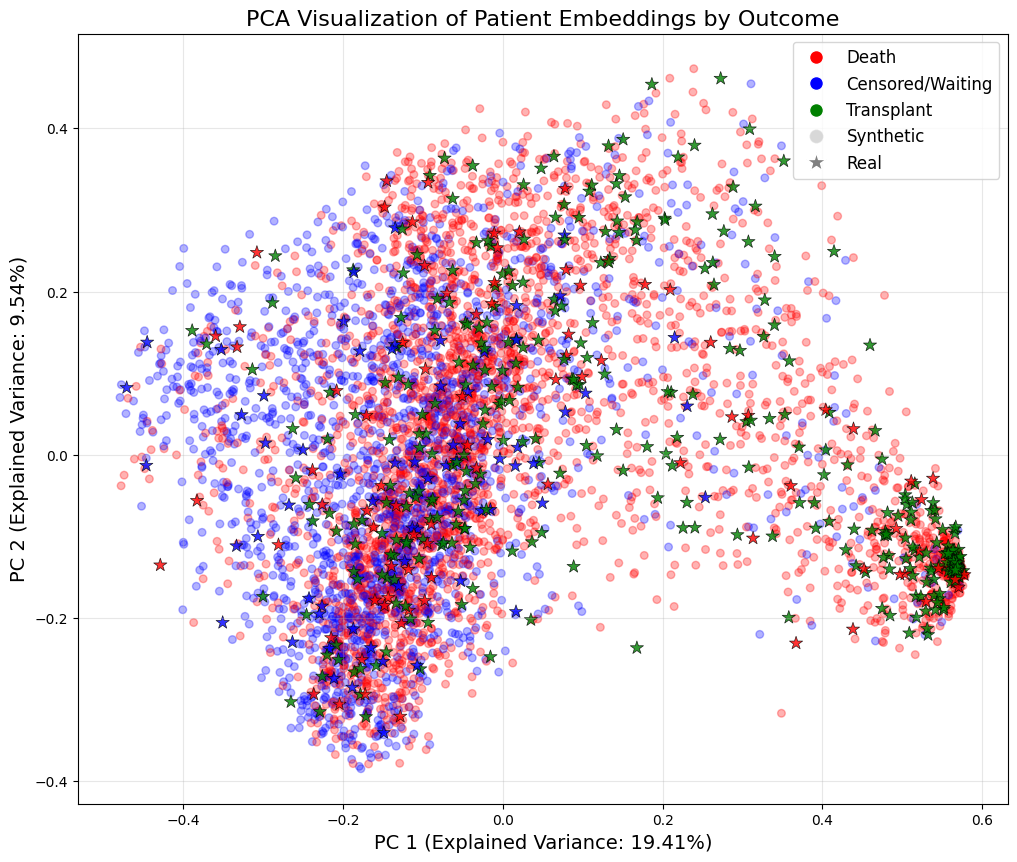

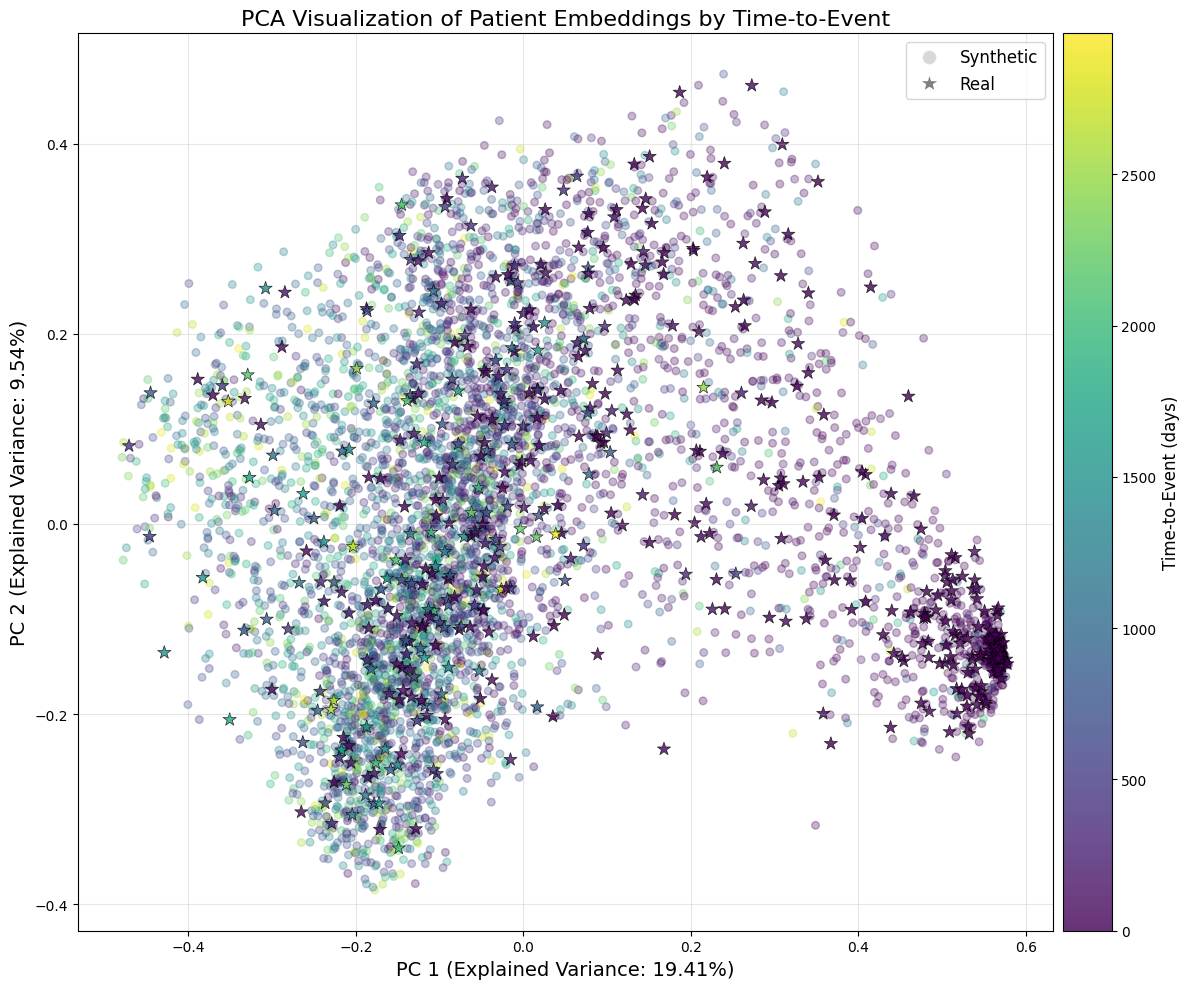

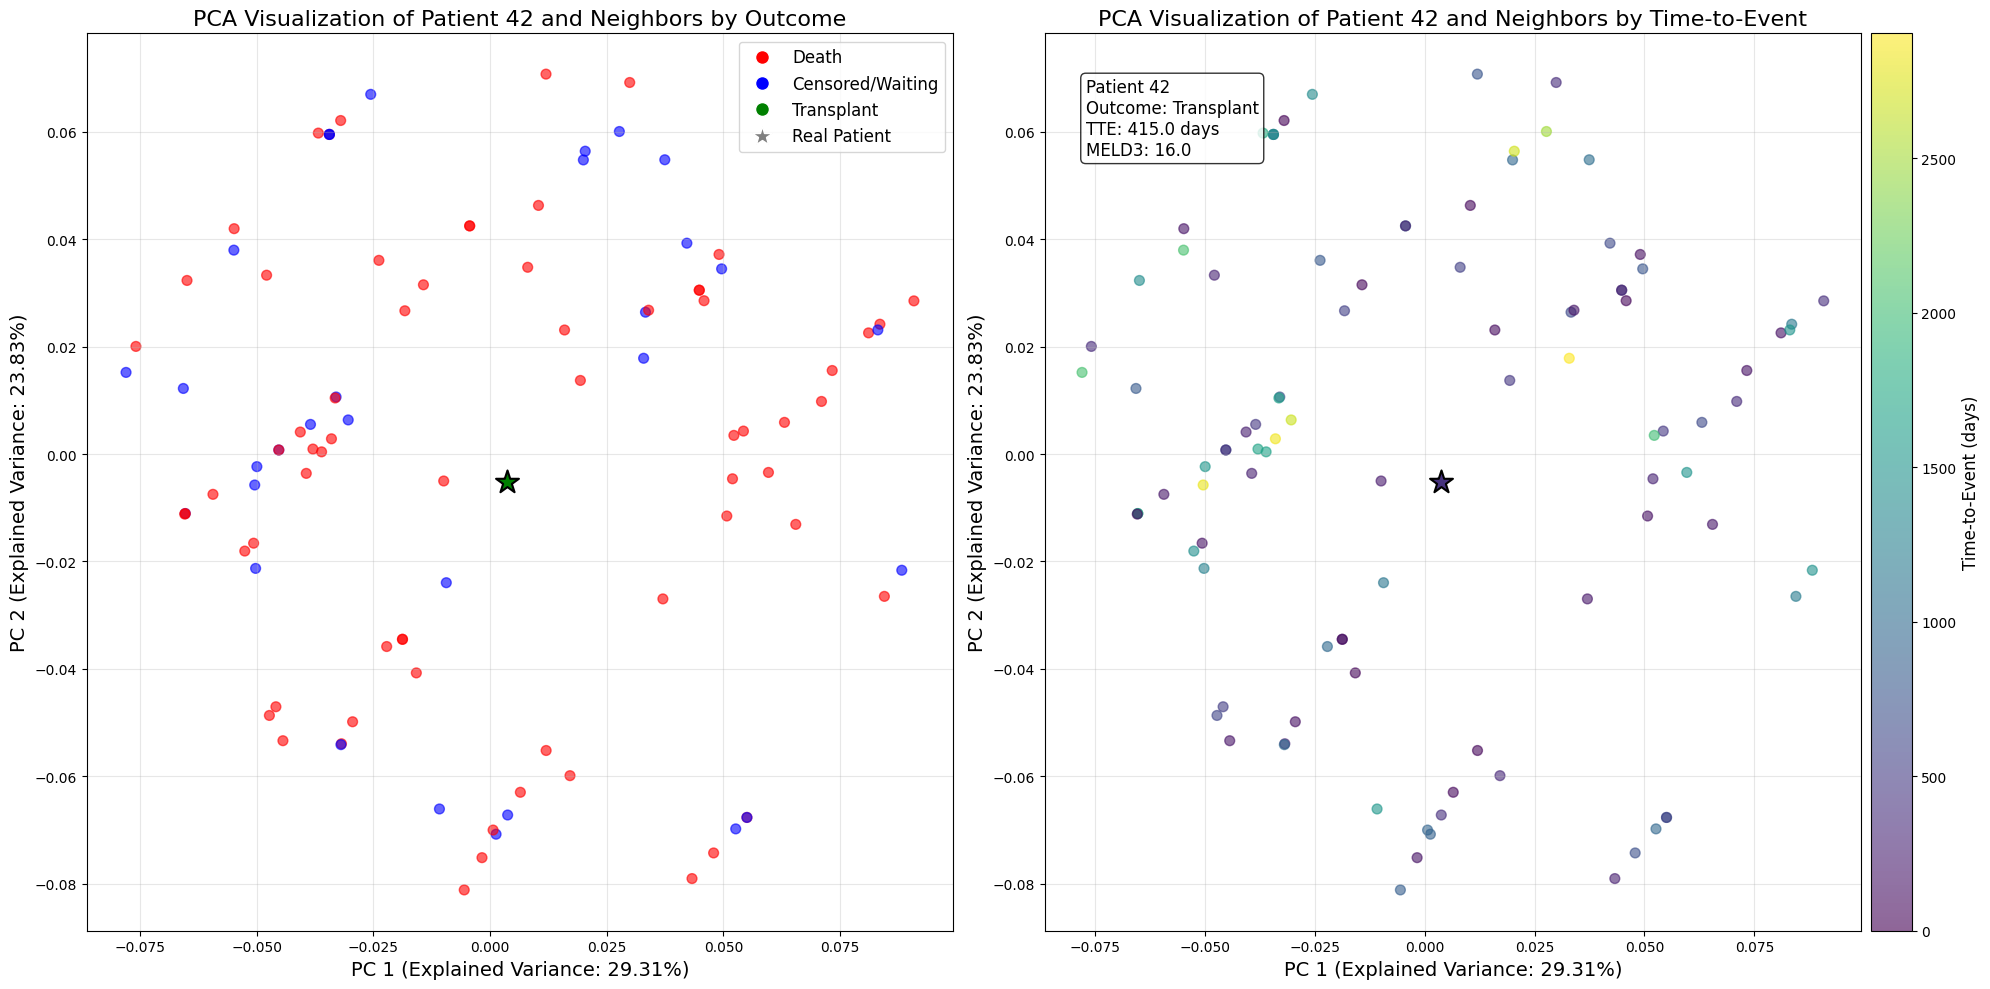

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_embeddings_with_pca(syn_embeddings, real_embeddings, syn_df, real_df,
                                  indices_all, max_samples=5000, random_state=42):
    """
    Generate PCA visualizations of embedding space showing distributions of patients
    by outcome and time-to-event.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    max_samples : int
        Maximum number of samples to use for visualization
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    fig1, fig2 : matplotlib figures
        Figures with the PCA visualizations
    """
    np.random.seed(random_state)

    # Sample synthetic patients if dataset is too large
    if len(syn_embeddings) > max_samples:
        syn_indices = np.random.choice(len(syn_embeddings), max_samples, replace=False)
        syn_embed_subset = syn_embeddings[syn_indices]
        syn_outcomes = syn_df.iloc[syn_indices]['outcome'].values
        syn_tte = syn_df.iloc[syn_indices]['tte'].values
    else:
        syn_embed_subset = syn_embeddings
        syn_outcomes = syn_df['outcome'].values
        syn_tte = syn_df['tte'].values

    # Sample real patients
    real_samples = min(len(real_embeddings), max_samples // 10)  # Use fewer real samples for clarity
    real_indices = np.random.choice(len(real_embeddings), real_samples, replace=False)
    real_embed_subset = real_embeddings[real_indices]
    real_outcomes = real_df.iloc[real_indices]['outcome'].values
    real_tte = real_df.iloc[real_indices]['tte'].values

    # Combine synthetic and real data for PCA
    combined_embeddings = np.vstack([syn_embed_subset, real_embed_subset])

    # Apply PCA
    pca = PCA(n_components=2)
    combined_2d = pca.fit_transform(combined_embeddings)

    # Split back into synthetic and real
    syn_2d = combined_2d[:len(syn_embed_subset)]
    real_2d = combined_2d[len(syn_embed_subset):]

    # Create outcome color mapping
    outcome_colors = {
        0: 'red',      # Death
        1: 'blue',     # Censored/Waiting
        2: 'green'     # Transplant
    }

    # Map outcomes to colors
    syn_colors = [outcome_colors[o] for o in syn_outcomes]
    real_colors = [outcome_colors[o] for o in real_outcomes]

    # Create figure for outcome visualization
    fig1, ax1 = plt.subplots(figsize=(12, 10))

    # Plot synthetic patients
    scatter_syn = ax1.scatter(
        syn_2d[:, 0], syn_2d[:, 1],
        c=syn_colors,
        marker='o',
        alpha=0.3,
        s=30,
        label='Synthetic'
    )

    # Plot real patients
    scatter_real = ax1.scatter(
        real_2d[:, 0], real_2d[:, 1],
        c=real_colors,
        marker='*',
        alpha=0.8,
        s=100,
        edgecolors='black',
        linewidths=0.5,
        label='Real'
    )

    # Create a legend for outcome colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Death'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Censored/Waiting'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Transplant'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, alpha=0.3, label='Synthetic'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real')
    ]

    ax1.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax1.set_title('PCA Visualization of Patient Embeddings by Outcome', fontsize=16)
    ax1.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax1.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Create figure for time-to-event visualization
    fig2, ax2 = plt.subplots(figsize=(12, 10))

    # Create color map for TTE
    max_tte = max(np.max(syn_tte), np.max(real_tte))
    norm = plt.Normalize(0, max_tte)

    # Plot synthetic patients with color based on TTE
    scatter_syn_tte = ax2.scatter(
        syn_2d[:, 0], syn_2d[:, 1],
        c=syn_tte,
        cmap='viridis',
        norm=norm,
        marker='o',
        alpha=0.3,
        s=30,
        label='Synthetic'
    )

    # Plot real patients with color based on TTE
    scatter_real_tte = ax2.scatter(
        real_2d[:, 0], real_2d[:, 1],
        c=real_tte,
        cmap='viridis',
        norm=norm,
        marker='*',
        alpha=0.8,
        s=100,
        edgecolors='black',
        linewidths=0.5,
        label='Real'
    )

    # Add colorbar for TTE
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter_real_tte, cax=cax)
    cbar.set_label('Time-to-Event (days)', fontsize=12)

    # Create a legend for synthetic vs real
    legend_elements_tte = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, alpha=0.3, label='Synthetic'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real')
    ]

    ax2.legend(handles=legend_elements_tte, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax2.set_title('PCA Visualization of Patient Embeddings by Time-to-Event', fontsize=16)
    ax2.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax2.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig1, fig2

def visualize_neighbor_embeddings(syn_embeddings, real_embeddings, syn_df, real_df,
                                 indices_all, patient_idx, n_neighbors=100):
    """
    Generate PCA visualization showing a specific real patient and their synthetic neighbors.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to visualize

    Returns:
    --------
    fig : matplotlib figure
        Figure with the PCA visualization
    """
    # Get the real patient's embedding and data
    real_patient_embed = real_embeddings[patient_idx].reshape(1, -1)
    real_patient_outcome = real_df.iloc[patient_idx]['outcome']
    real_patient_tte = real_df.iloc[patient_idx]['tte']

    # Get neighbor indices for this patient and their embeddings
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_embeddings = syn_embeddings[neighbor_indices]

    # Get neighbor outcomes and tte
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values

    # Combine embeddings for PCA
    combined_embeddings = np.vstack([real_patient_embed, neighbor_embeddings])

    # Apply PCA
    pca = PCA(n_components=2)
    combined_2d = pca.fit_transform(combined_embeddings)

    # Split back into real patient and neighbors
    real_patient_2d = combined_2d[0]
    neighbor_2d = combined_2d[1:]

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Outcome visualization (left plot)
    # Create outcome color mapping
    outcome_colors = {
        0: 'red',      # Death
        1: 'blue',     # Censored/Waiting
        2: 'green'     # Transplant
    }

    # Map outcomes to colors
    neighbor_colors = [outcome_colors[o] for o in neighbor_outcomes]

    # Plot neighbors by outcome
    scatter_neighbors = ax1.scatter(
        neighbor_2d[:, 0], neighbor_2d[:, 1],
        c=neighbor_colors,
        marker='o',
        alpha=0.6,
        s=50
    )

    # Plot the real patient
    ax1.scatter(
        real_patient_2d[0], real_patient_2d[1],
        c=outcome_colors[real_patient_outcome],
        marker='*',
        s=300,
        edgecolors='black',
        linewidths=1.5,
        label='Real Patient'
    )

    # Create a legend for outcome colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Death'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Censored/Waiting'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Transplant'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real Patient')
    ]

    ax1.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax1.set_title(f'PCA Visualization of Patient {patient_idx} and Neighbors by Outcome', fontsize=16)
    ax1.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax1.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Time-to-event visualization (right plot)
    # Create color map for TTE
    max_tte = max(np.max(neighbor_tte), real_patient_tte)
    norm = plt.Normalize(0, max_tte)

    # Plot neighbors with color based on TTE
    scatter_neighbors_tte = ax2.scatter(
        neighbor_2d[:, 0], neighbor_2d[:, 1],
        c=neighbor_tte,
        cmap='viridis',
        norm=norm,
        marker='o',
        alpha=0.6,
        s=50
    )

    # Plot the real patient with color based on TTE
    scatter_real_tte = ax2.scatter(
        real_patient_2d[0], real_patient_2d[1],
        c=real_patient_tte,
        cmap='viridis',
        norm=norm,
        marker='*',
        s=300,
        edgecolors='black',
        linewidths=1.5
    )

    # Add colorbar for TTE
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter_neighbors_tte, cax=cax)
    cbar.set_label('Time-to-Event (days)', fontsize=12)

    # Add text with patient information
    patient_info = (
        f"Patient {patient_idx}\n"
        f"Outcome: {['Death', 'Censored/Waiting', 'Transplant'][real_patient_outcome]}\n"
        f"TTE: {real_patient_tte:.1f} days\n"
        f"MELD3: {real_df.iloc[patient_idx]['meld3']:.1f}"
    )

    ax2.text(0.05, 0.95, patient_info, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Customize plot appearance
    ax2.set_title(f'PCA Visualization of Patient {patient_idx} and Neighbors by Time-to-Event', fontsize=16)
    ax2.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax2.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig

# Example usage:
# 1. To generate global PCA visualizations:
fig1, fig2 = visualize_embeddings_with_pca(syn_embeddings, real_embeddings, syn_df_processed, real_df, indices_all)
fig1.savefig('pca_by_outcome.png', dpi=300, bbox_inches='tight')
fig2.savefig('pca_by_tte.png', dpi=300, bbox_inches='tight')

# 2. To visualize a specific patient and their neighbors:
patient_idx = 42  # Replace with a specific patient index
fig3 = visualize_neighbor_embeddings(syn_embeddings, real_embeddings, syn_df_processed, real_df, indices_all, patient_idx)
fig3.savefig(f'patient_{patient_idx}_neighbors.png', dpi=300, bbox_inches='tight')

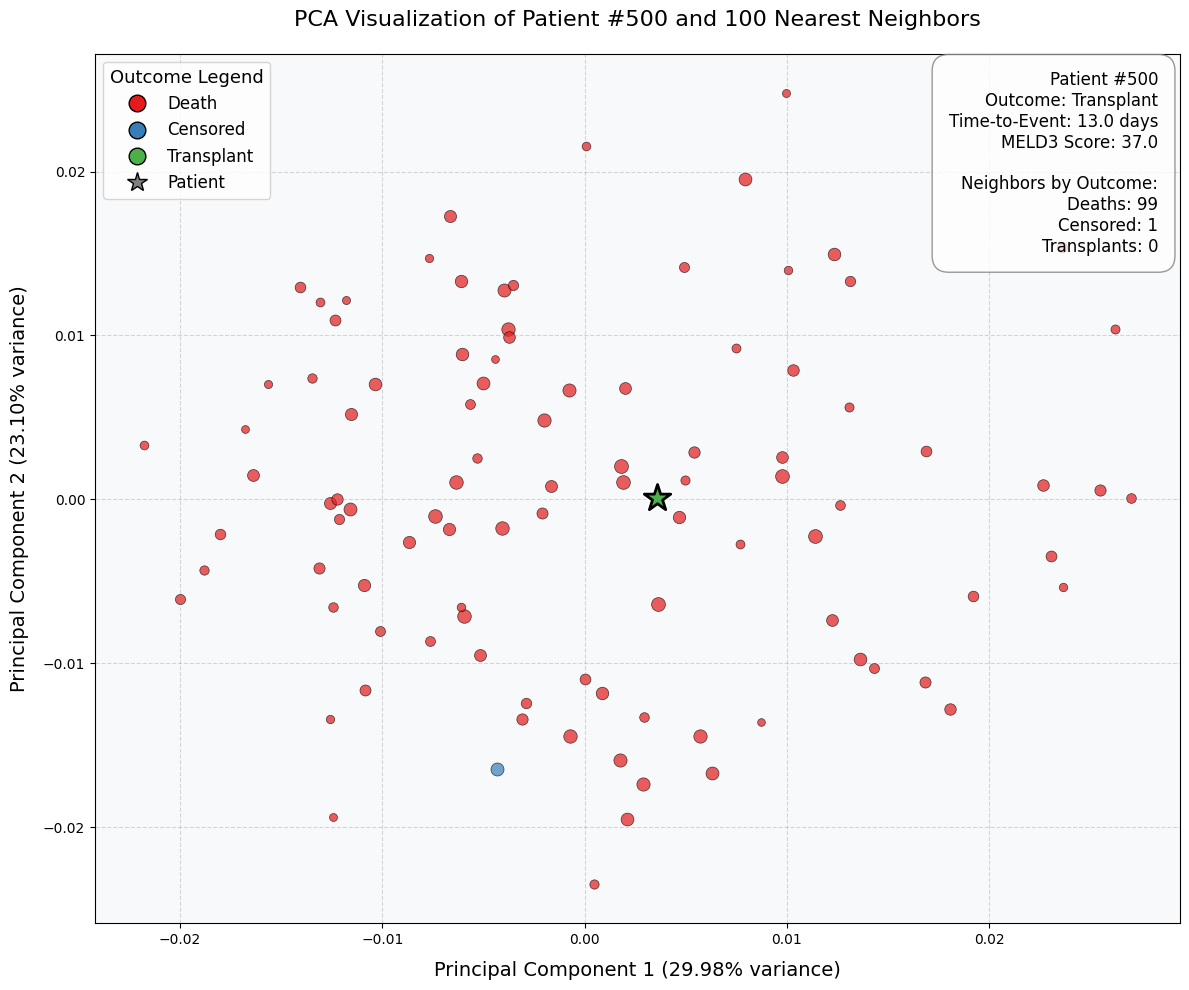

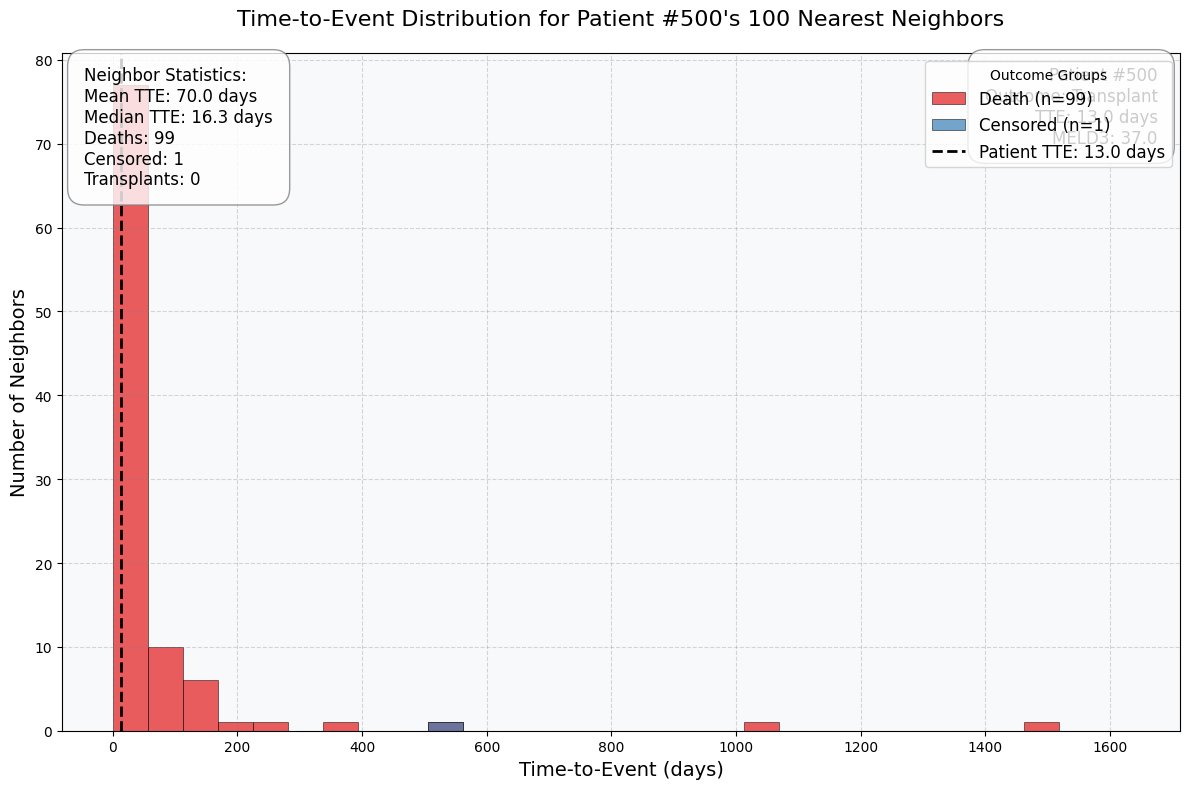

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patheffects as PathEffects
from matplotlib.lines import Line2D

def create_simple_pca_visualization(syn_embeddings, real_embeddings, syn_df, real_df,
                                  indices_all, patient_idx=157, n_neighbors=100):
    """
    Create a simplified PCA visualization of a patient and their neighbors.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to include in the visualization

    Returns:
    --------
    fig : matplotlib figure
        Figure with the simplified PCA visualization
    """
    # 1. Get patient data
    patient_embed = real_embeddings[patient_idx].reshape(1, -1)
    patient_tte = real_df.iloc[patient_idx]['tte']
    patient_outcome = real_df.iloc[patient_idx]['outcome']
    patient_meld = real_df.iloc[patient_idx]['meld3']

    # 2. Get the neighbors
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_embeds = syn_embeddings[neighbor_indices]
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values

    # 3. Combine all embeddings for PCA
    all_embeds = np.vstack([neighbor_embeds, patient_embed])

    # 4. Apply PCA
    pca = PCA(n_components=2)
    all_2d = pca.fit_transform(all_embeds)

    # 5. Split back to respective groups
    neighbor_2d = all_2d[:-1]
    patient_2d = all_2d[-1]

    # 6. Create figure with custom design
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

    # 7. Define colors for outcomes
    outcome_colors = {
        0: '#e41a1c',  # Death (red)
        1: '#377eb8',  # Censored (blue)
        2: '#4daf4a'   # Transplant (green)
    }

    # 8. Plot neighbors with color based on outcome and size based on TTE
    for i, (x, y) in enumerate(neighbor_2d):
        outcome = neighbor_outcomes[i]
        tte_val = neighbor_tte[i]
        color = outcome_colors[outcome]

        # Make points smaller as TTE increases
        size = 100 * (1 - 0.7 * (i / n_neighbors))  # Size decreases with neighbor rank

        ax.scatter(
            x, y,
            color=color,
            s=size,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )

    # 9. Plot the patient with emphasis
    patient_point = ax.scatter(
        patient_2d[0], patient_2d[1],
        marker='*',
        c=outcome_colors[patient_outcome],
        s=400,
        alpha=1.0,
        edgecolors='black',
        linewidths=2,
        zorder=100  # Ensure patient is on top
    )

    # Add a glowing effect to patient point
    patient_point.set_path_effects([
        PathEffects.withStroke(linewidth=5, foreground='white', alpha=0.7)
    ])

    # 10. Add information box
    outcome_labels = {0: 'Death', 1: 'Censored', 2: 'Transplant'}
    info_text = (
        f"Patient #{patient_idx}\n"
        f"Outcome: {outcome_labels[patient_outcome]}\n"
        f"Time-to-Event: {patient_tte:.1f} days\n"
        f"MELD3 Score: {patient_meld:.1f}\n\n"
        f"Neighbors by Outcome:\n"
        f"Deaths: {np.sum(neighbor_outcomes == 0)}\n"
        f"Censored: {np.sum(neighbor_outcomes == 1)}\n"
        f"Transplants: {np.sum(neighbor_outcomes == 2)}"
    )

    # Add annotation box
    ax.text(
        0.98, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # 11. Create legend for outcome colors
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[0],
               markersize=12, label='Death', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[1],
               markersize=12, label='Censored', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[2],
               markersize=12, label='Transplant', markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray',
               markersize=15, label='Patient', markeredgecolor='black')
    ]

    ax.legend(
        handles=legend_elements,
        loc='upper left',
        fontsize=12,
        framealpha=0.8,
        title="Outcome Legend",
        title_fontsize=13
    )

    # 12. Customize axis
    ax.set_title(f"PCA Visualization of Patient #{patient_idx} and {n_neighbors} Nearest Neighbors",
                fontsize=16, pad=20)
    ax.set_xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)",
                fontsize=14, labelpad=10)
    ax.set_ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)",
                fontsize=14, labelpad=10)

    # Add grid for readability
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')

    # Set background color
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout()

    return fig


def create_neighbor_tte_histogram(syn_df, real_df, indices_all, patient_idx=157, n_neighbors=100):
    """
    Create a histogram showing the distribution of TTE values among neighbors.

    Parameters:
    -----------
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to include in the visualization

    Returns:
    --------
    fig : matplotlib figure
        Figure with the TTE histogram
    """
    # Get patient data
    patient_tte = real_df.iloc[patient_idx]['tte']
    patient_outcome = real_df.iloc[patient_idx]['outcome']
    patient_meld = real_df.iloc[patient_idx]['meld3']

    # Get neighbor data
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

    # Define outcome colors
    outcome_colors = {
        0: '#e41a1c',  # Death (red)
        1: '#377eb8',  # Censored (blue)
        2: '#4daf4a'   # Transplant (green)
    }

    # Create histogram by outcome
    outcome_labels = {0: 'Death', 1: 'Censored', 2: 'Transplant'}
    bins = np.linspace(0, max(np.max(neighbor_tte), patient_tte) * 1.1, 30)

    for outcome, color in outcome_colors.items():
        mask = neighbor_outcomes == outcome
        if np.sum(mask) > 0:
            ax.hist(
                neighbor_tte[mask],
                bins=bins,
                alpha=0.7,
                color=color,
                label=f"{outcome_labels[outcome]} (n={np.sum(mask)})",
                edgecolor='black',
                linewidth=0.5
            )

    # Add vertical line for patient's TTE
    ax.axvline(
        x=patient_tte,
        color='black',
        linestyle='--',
        linewidth=2,
        label=f"Patient TTE: {patient_tte:.1f} days"
    )

    # Add patient information box
    info_text = (
        f"Patient #{patient_idx}\n"
        f"Outcome: {outcome_labels[patient_outcome]}\n"
        f"TTE: {patient_tte:.1f} days\n"
        f"MELD3: {patient_meld:.1f}"
    )

    ax.text(
        0.98, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # Calculate and add summary statistics
    mean_tte = np.mean(neighbor_tte)
    median_tte = np.median(neighbor_tte)
    stats_text = (
        f"Neighbor Statistics:\n"
        f"Mean TTE: {mean_tte:.1f} days\n"
        f"Median TTE: {median_tte:.1f} days\n"
        f"Deaths: {np.sum(neighbor_outcomes == 0)}\n"
        f"Censored: {np.sum(neighbor_outcomes == 1)}\n"
        f"Transplants: {np.sum(neighbor_outcomes == 2)}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # Add title and labels
    ax.set_title(f"Time-to-Event Distribution for Patient #{patient_idx}'s {n_neighbors} Nearest Neighbors",
                fontsize=16, pad=20)
    ax.set_xlabel("Time-to-Event (days)", fontsize=14)
    ax.set_ylabel("Number of Neighbors", fontsize=14)

    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')
    ax.legend(fontsize=12, title="Outcome Groups", loc='upper right')

    # Set background color
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout()

    return fig


# Example usage:
patient_idx = 500  # Choose a patient index
fig1 = create_simple_pca_visualization(
    syn_embeddings, real_embeddings, syn_df_processed, real_df,
    indices_all, patient_idx=patient_idx
)
fig1.savefig(f'pca_patient_{patient_idx}.png', dpi=300, bbox_inches='tight')

# Create the histogram
fig2 = create_neighbor_tte_histogram(
    syn_df_processed, real_df, indices_all, patient_idx=patient_idx
)
fig2.savefig(f'histogram_patient_{patient_idx}.png', dpi=300, bbox_inches='tight')

In [ ]:
# Calculate absolute difference between predicted and actual TTE
def find_close_tte_matches(real_df, syn_df_processed, indices_all, n_patients=5):
    """
    Find patients where predicted TTE closely matches actual TTE

    Parameters:
    -----------
    real_df : pandas DataFrame
        DataFrame with real patient data
    syn_df_processed : pandas DataFrame
        DataFrame with synthetic patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    n_patients : int
        Number of close matches to find

    Returns:
    --------
    close_matches : list
        Indices of patients with close TTE matches
    """
    # Calculate predicted TTE for each patient (median of neighbors)
    predicted_ttes = []
    for i in range(len(real_df)):
        neighbor_indices = indices_all[i][:100]  # Use top 100 neighbors
        neighbor_tte = syn_df_processed.iloc[neighbor_indices]['tte'].values
        predicted_tte = np.median(neighbor_tte)
        predicted_ttes.append(predicted_tte)

    # Add predicted TTE to dataframe
    real_df_copy = real_df.copy()
    real_df_copy['predicted_tte'] = predicted_ttes

    # Calculate absolute difference
    real_df_copy['tte_diff'] = abs(real_df_copy['tte'] - real_df_copy['predicted_tte'])

    # Find patients with smallest difference (filter to those who died for better comparison)
    # If you want to consider all outcomes, remove the outcome filter
    died_patients = real_df_copy[real_df_copy['outcome'] == 0]
    closest_matches = died_patients.nsmallest(n_patients, 'tte_diff')

    # Return indices of closest matches
    return closest_matches.index.tolist(), closest_matches

In [ ]:
# Find 5 patients with closest match between predicted and actual TTE
match_indices, match_df = find_close_tte_matches(real_df, syn_df_processed, indices_all)

print("Patients with closest match between predicted and actual TTE:")
for idx in match_indices:
    patient_tte = real_df.loc[idx, 'tte']
    predicted_tte = match_df.loc[idx, 'predicted_tte']
    diff = match_df.loc[idx, 'tte_diff']
    outcome = "Death" if real_df.loc[idx, 'outcome'] == 0 else ("Censored" if real_df.loc[idx, 'outcome'] == 1 else "Transplant")

    print(f"Patient #{idx}: Actual TTE = {patient_tte:.1f} days, Predicted TTE = {predicted_tte:.1f} days")
    print(f"   Difference: {diff:.1f} days, Outcome: {outcome}")
    print(f"   MELD3 Score: {real_df.loc[idx, 'meld3']:.1f}")
    print()

Patients with closest match between predicted and actual TTE:
Patient #1241: Actual TTE = 7.0 days, Predicted TTE = 7.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 47.0

Patient #3822: Actual TTE = 11.0 days, Predicted TTE = 11.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 40.0

Patient #3865: Actual TTE = 18.0 days, Predicted TTE = 18.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 28.0

Patient #7691: Actual TTE = 9.0 days, Predicted TTE = 9.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 37.0

Patient #2406: Actual TTE = 8.0 days, Predicted TTE = 7.9 days
   Difference: 0.1 days, Outcome: Death
   MELD3 Score: 33.0



In [ ]:
# Create visualizations for the matched patients
for idx in match_indices:
    print(f"Generating visualizations for patient {idx}...")

    # Create PCA visualization
    fig1 = create_simple_pca_visualization(
        syn_embeddings, real_embeddings, syn_df_processed, real_df,
        indices_all, patient_idx=idx
    )

    # Create TTE histogram
    fig2 = create_neighbor_tte_histogram(
        syn_df_processed, real_df, indices_all, patient_idx=idx
    )

    # Save visualizations
    fig1.savefig(f'pca_patient_{idx}_close_match.png', dpi=300, bbox_inches='tight')
    fig2.savefig(f'histogram_patient_{idx}_close_match.png', dpi=300, bbox_inches='tight')

    # Close figures to save memory
    plt.close(fig1)
    plt.close(fig2)

Generating visualizations for patient 1241...
Generating visualizations for patient 3822...


Processing with k=1000:   0%|          | 0/14632 [02:57<?, ?it/s]


Generating visualizations for patient 3865...
Generating visualizations for patient 7691...
Generating visualizations for patient 2406...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_score_tte_vs_meld3(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k100', 'predicted_death_tte_k200',
              'predicted_death_tte_k300','predicted_death_tte_k500',
              'predicted_death_tte_k750','predicted_death_tte_k1000'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Calculate naive Brier scores at multiple time points for:
      - Each TTE column in tte_cols
      - MELD-3
    Compares 'death by day t' vs. predicted probability.

    Args:
        df (pd.DataFrame): Must contain:
          - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
          - tte_col (time to event)
          - each col in tte_cols for predicted TTE
          - meld_col for MELD-3
        time_points (list): Time horizons for analysis
        tte_cols (list): Column names for predicted TTEs
        meld_col (str): Column name for MELD-3
        outcome_col (str): The outcome column name
        tte_col (str): The time-to-event column name

    Returns:
        pd.DataFrame: Rows=each time t, columns= Brier scores & counts
    """
    # Copy data so we don't mutate
    df_all = df.copy()

    # We'll build a results table
    results = []

    # Precompute min/max for each TTE column (for naive 0..1 transform)
    tte_minmax = {}
    for c in tte_cols:
        valid_vals = df_all[c].dropna()
        if len(valid_vals)==0:
            raise ValueError(f"No valid predictions in {c}")
        tte_min, tte_max = valid_vals.min(), valid_vals.max()
        tte_minmax[c] = (tte_min, tte_max)

    # Also compute min/max for MELD-3
    meld_valid = df_all[meld_col].dropna()
    meld_min, meld_max = meld_valid.min(), meld_valid.max()

    for t in time_points:
        # 1) Subset: at risk => those who haven't died before t or died by t
        at_risk_mask = (
            (df_all[tte_col] >= t)
            | ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # 2) event indicator: 1 if death by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have both events and nonevents
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            # Brier score undefined if all 0 or all 1
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill with None for each TTE col
            for c in tte_cols:
                row[f'Brier_{c}'] = None
            row['Brier_meld3'] = None
            results.append(row)
            continue

        # 3) Build naive prob for MELD3
        meld_vals = df_at_risk[meld_col]
        meld_prob = (meld_vals - meld_min) / (meld_max - meld_min + 1e-12)
        # clamp to [0,1]
        meld_prob = np.clip(meld_prob, 0, 1)

        # Brier for meld
        brier_meld = brier_score_loss(event_indicator, meld_prob)

        # Fill row
        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do naive transform => probability
        for c in tte_cols:
            tte_vals = df_at_risk[c].copy()
            # min/max
            tmin, tmax = tte_minmax[c]
            denom = (tmax - tmin) if (tmax > tmin) else 1e-12

            # Prob = 1 - (tte - tmin)/denom
            # => smaller tte => bigger prob
            prob_vals = 1 - (tte_vals - tmin)/denom
            prob_vals = np.clip(prob_vals, 0, 1)

            # Brier
            brier_val = brier_score_loss(event_indicator, prob_vals)
            row[f'Brier_{c}'] = brier_val

        results.append(row)

    return pd.DataFrame(results)

# Example usage:
df_results = brier_score_tte_vs_meld3(real_df)
print(df_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k100  Brier_predicted_death_tte_k200  Brier_predicted_death_tte_k300  Brier_predicted_death_tte_k500  Brier_predicted_death_tte_k750  Brier_predicted_death_tte_k1000
0     7      12188            171       0.1025                          0.5707                          0.5699                          0.5696                          0.5701                          0.5699                           0.5698
1    14      10911            318       0.0895                          0.5223                          0.5214                          0.5212                          0.5217                          0.5215                           0.5215
2    30       9653            498       0.0826                          0.4700                          0.4691                          0.4690                          0.4695                          0.4694                           0.4694
3    90       7706            837       

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_scores_with_transforms(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k100', 'predicted_death_tte_k200',
              'predicted_death_tte_k300','predicted_death_tte_k500',
              'predicted_death_tte_k750','predicted_death_tte_k1000'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Computes Brier scores at multiple time points for:
      - MELD-3 (naive scaling)
      - Each TTE column, *with 3 transforms*:
           (1) Exponential, (2) Sigmoid, (3) Linear
    For 'death=0' vs 'censor/transplant=non-death'.

    Args:
      df (pd.DataFrame): Must contain columns:
        - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
        - tte_col (time to event)
        - each col in tte_cols for predicted TTE
        - meld_col for MELD-3
      time_points (list of ints): Day horizons to check
      tte_cols (list of str): Names of TTE predictions
      meld_col (str): Column name for MELD-3
      outcome_col (str): Outcome column name
      tte_col (str): Time-to-event column name

    Returns:
      pd.DataFrame with rows for each time t, columns for Brier scores.
    """
    # We'll build a list of results, each row is a time t
    results = []

    # Precompute min & max for MELD-3 to do naive [0..1] scaling
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()

    # Constants for transformations
    sigmoid_scale = 30.0  # Adjust if you want a different shape
    # linear uses cutoff=2*t, defined inside loop

    for t in time_points:
        # 1) define at-risk set: those not dead before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        df_at_risk = df[at_risk_mask].copy()

        # 2) event indicator: 1 if died by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have at least 1 event and at least 1 nonevent
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # Fill placeholders for meld
            row['Brier_meld3'] = None
            # Fill placeholders for each transform of TTE
            for c in tte_cols:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
            results.append(row)
            continue

        # 3) Build naive [0..1] prob for MELD
        meld_sub = df_at_risk[meld_col].copy().dropna()
        # If some rows are NaN, we must drop them from event_indicator as well
        common_index = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[common_index]
        event_sub = event_indicator.loc[common_index]

        # min-max scale
        denom_meld = (meld_max - meld_min) if (meld_max > meld_min) else 1.0
        meld_prob = (meld_sub - meld_min) / denom_meld
        meld_prob = np.clip(meld_prob, 0, 1)

        brier_meld = brier_score_loss(event_sub, meld_prob)

        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do exponential / sigmoid / linear => Brier
        for c in tte_cols:
            tte_series = df_at_risk[c].copy().dropna()
            common_idx = tte_series.index.intersection(event_indicator.index)
            tte_series = tte_series.loc[common_idx]
            evt = event_indicator.loc[common_idx]

            if len(tte_series)==0:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
                continue

            # (a) Exponential
            # prob = exp(-TTE / t)
            prob_exp = np.exp(-tte_series / float(t))
            prob_exp = np.clip(prob_exp, 0, 1)
            brier_exp = brier_score_loss(evt, prob_exp)

            # (b) Sigmoid
            # prob = 1/(1 + exp((TTE - t)/scale))
            prob_sig = 1.0 / (1.0 + np.exp((tte_series - float(t))/sigmoid_scale))
            prob_sig = np.clip(prob_sig, 0, 1)
            brier_sig = brier_score_loss(evt, prob_sig)

            # (c) Linear
            # cutoff=2*t => prob= max(0, 1 - TTE/cutoff)
            cutoff = 2.0 * float(t)
            prob_lin = np.maximum(0, 1 - tte_series/cutoff)
            prob_lin = np.clip(prob_lin, 0, 1)
            brier_lin = brier_score_loss(evt, prob_lin)

            row[f'Brier_{c}_exp'] = brier_exp
            row[f'Brier_{c}_sigmoid'] = brier_sig
            row[f'Brier_{c}_linear'] = brier_lin

        results.append(row)

    return pd.DataFrame(results)


# Example usage:
results_df = brier_scores_with_transforms(real_df)
print(results_df.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k100_exp  Brier_predicted_death_tte_k100_sigmoid  Brier_predicted_death_tte_k100_linear  Brier_predicted_death_tte_k200_exp  Brier_predicted_death_tte_k200_sigmoid  Brier_predicted_death_tte_k200_linear  Brier_predicted_death_tte_k300_exp  Brier_predicted_death_tte_k300_sigmoid  Brier_predicted_death_tte_k300_linear  Brier_predicted_death_tte_k500_exp  Brier_predicted_death_tte_k500_sigmoid  Brier_predicted_death_tte_k500_linear  Brier_predicted_death_tte_k750_exp  Brier_predicted_death_tte_k750_sigmoid  Brier_predicted_death_tte_k750_linear  Brier_predicted_death_tte_k1000_exp  Brier_predicted_death_tte_k1000_sigmoid  Brier_predicted_death_tte_k1000_linear
0     7      12188            171       0.1025                              0.0133                                  0.0297                                 0.0148                              0.0133                                  0.0297                       

In [ ]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

def isotonic_calibration_brier(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k100', 'predicted_death_tte_k200',
              'predicted_death_tte_k300','predicted_death_tte_k500',
              'predicted_death_tte_k750','predicted_death_tte_k1000'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    For each horizon t, do:
      1) define event=1 if death by t, else 0
      2) subset to at-risk
      3) for each TTE col:
         - invert TTE -> ensure bigger X => bigger risk
         - fit IsotonicRegression on (X, event)
         - transform X -> iso_prob
         - compute Brier
      4) Compare to naive MELD transform (optional)

    NOTE: This fits isotonic on the same data it evaluates,
          which can be over-optimistic.
          Use train/test splits for a realistic measure.
    """
    results = []

    # Precompute min/max for MELD-3 if you want a naive [0..1] transform
    # (You could skip if you only want to do isotonic on TTE.)
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()
    denom_meld = (meld_max - meld_min) if (meld_max>meld_min) else 1.0

    for t in time_points:
        # 1) define at-risk set
        #    keep those who have not died before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        sub_df = df[at_risk_mask].copy()

        # event=1 if died by day t
        event_indicator = (
            (sub_df[outcome_col] == 0) & (sub_df[tte_col] <= t)
        ).astype(int)

        # if all 1 or all 0 => Brier undefined
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(sub_df),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill TTE columns with None
            for c in tte_cols:
                row[f'Brier_{c}_iso'] = None
            # optional meld
            row['Brier_meld3'] = None
            results.append(row)
            continue

        row = {
            'Time': t,
            'N_at_risk': len(sub_df),
            'N_events_by_t': int(event_indicator.sum())
        }

        # (Optional) compute naive meld brier
        meld_sub = sub_df[meld_col].dropna()
        idx_common = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[idx_common]
        event_sub = event_indicator.loc[idx_common]
        meld_prob = (meld_sub - meld_min)/denom_meld
        meld_prob = np.clip(meld_prob,0,1)
        brier_meld = brier_score_loss(event_sub, meld_prob)
        row['Brier_meld3'] = brier_meld

        # 2) for each TTE col => do isotonic
        for c in tte_cols:
            tte_ser = sub_df[c].dropna()
            idx2 = tte_ser.index.intersection(event_indicator.index)
            tte_ser = tte_ser.loc[idx2]
            evt = event_indicator.loc[idx2]

            if len(tte_ser)==0:
                row[f'Brier_{c}_iso'] = None
                continue

            # We want "larger X => higher risk" for isotonic
            # but TTE is "shorter => higher risk"
            # so we can invert TTE by negative or 1/TTE
            # simplest approach: X = - TTE
            X = -tte_ser.values  # bigger => higher risk
            Y = evt.values       # 0 or 1

            # Fit isotonic on (X, Y)
            iso = IsotonicRegression(out_of_bounds='clip')
            iso.fit(X, Y)

            # Transform
            iso_probs = iso.predict(X)

            # Brier
            brier_iso = brier_score_loss(Y, iso_probs)
            row[f'Brier_{c}_iso'] = brier_iso

        results.append(row)

    return pd.DataFrame(results)


# EXAMPLE usage:
iso_results = isotonic_calibration_brier(real_df)
print(iso_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k100_iso  Brier_predicted_death_tte_k200_iso  Brier_predicted_death_tte_k300_iso  Brier_predicted_death_tte_k500_iso  Brier_predicted_death_tte_k750_iso  Brier_predicted_death_tte_k1000_iso
0     7      12188            171       0.1025                              0.0119                              0.0120                              0.0120                              0.0119                              0.0120                               0.0121
1    14      10911            318       0.0895                              0.0205                              0.0204                              0.0205                              0.0206                              0.0205                               0.0206
2    30       9653            498       0.0826                              0.0292                              0.0293                              0.0294                              0.0294                  

Brier Scores:
MELD3: 0.0898
Exponential: 0.0605
Sigmoid: 0.0670
Linear: 0.0656
Isotonic: 0.0572


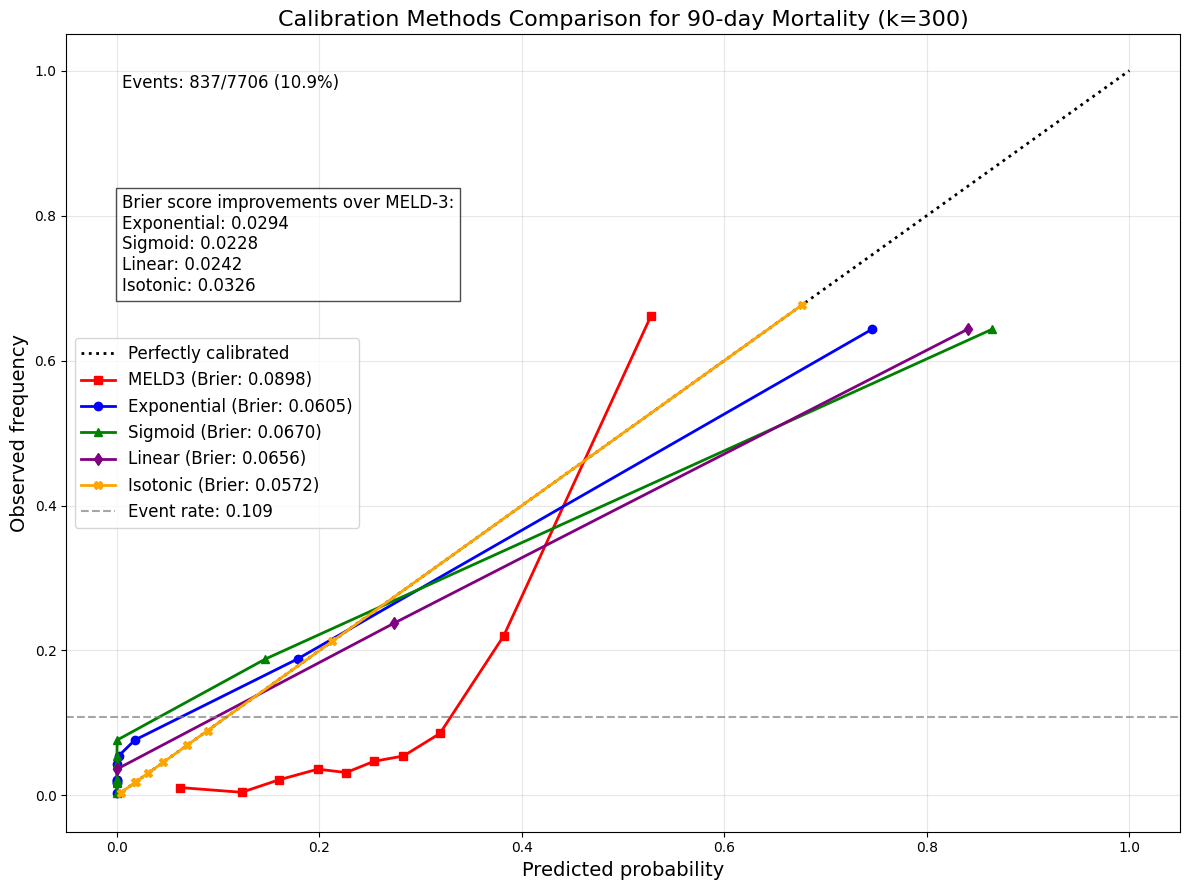

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression

def plot_calibration_methods_k300(df, timepoint=90, k=300, figsize=(12, 9), save_path=None):
    """
    Create a calibration plot that accurately reflects the Brier scores in the data table.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    figsize : tuple
        Figure size
    save_path : str, optional
        Path to save the figure

    Returns:
    --------
    matplotlib.figure.Figure
    """
    # Create binary outcome: 1 if died within timepoint days, 0 otherwise
    # Define at-risk set: those who have not died before t, or died by t
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    # Event indicator: 1 if died by day t, else 0
    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    event_rate = event_indicator.mean()

    # Get MELD3 scores as baseline
    meld_col = 'meld3'
    meld_scores = df_at_risk[meld_col].copy().dropna()

    # Match indices for common subset
    common_index = meld_scores.index.intersection(event_indicator.index)
    meld_scores = meld_scores.loc[common_index]
    event_indicator_meld = event_indicator.loc[common_index]

    # Get min/max for scaling
    meld_min, meld_max = df[meld_col].dropna().min(), df[meld_col].dropna().max()
    denom_meld = (meld_max - meld_min) if (meld_max > meld_min) else 1.0

    # Scale to [0,1]
    meld_prob = (meld_scores - meld_min) / denom_meld
    meld_prob = np.clip(meld_prob, 0, 1)
    meld_brier = brier_score_loss(event_indicator_meld, meld_prob)

    # Get prediction column for k=200
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions (non-NaN)
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # 1. Exponential transform: P(death) = exp(-TTE / timepoint)
    prob_exp = np.exp(-tte_series / float(timepoint))
    prob_exp = np.clip(prob_exp, 0, 1)
    exp_brier = brier_score_loss(evt, prob_exp)

    # 2. Sigmoid transform: P(death) = 1/(1 + exp((TTE - timepoint)/scale))
    sigmoid_scale = 30.0
    prob_sig = 1.0 / (1.0 + np.exp((tte_series - float(timepoint))/sigmoid_scale))
    prob_sig = np.clip(prob_sig, 0, 1)
    sigmoid_brier = brier_score_loss(evt, prob_sig)

    # 3. Linear transform: P(death) = max(0, 1 - TTE/cutoff)
    cutoff = 2.0 * float(timepoint)
    prob_lin = np.maximum(0, 1 - tte_series/cutoff)
    prob_lin = np.clip(prob_lin, 0, 1)
    linear_brier = brier_score_loss(evt, prob_lin)

    # 4. Isotonic transform
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Apply calibration
    prob_iso = ir.predict(X)
    iso_brier = brier_score_loss(Y, prob_iso)

    # Set up the figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the diagonal (perfect calibration)
    ax.plot([0, 1], [0, 1], "k:", linewidth=2, label="Perfectly calibrated")

    # Plot calibration curves

    # MELD3
    meld_fraction_pos, meld_mean_pred_proba = calibration_curve(
        event_indicator_meld, meld_prob, n_bins=10, strategy='quantile'
    )
    ax.plot(meld_mean_pred_proba, meld_fraction_pos, "s-", color='red', linewidth=2,
           label=f"MELD3 (Brier: {meld_brier:.4f})")

    # Exponential
    exp_fraction_pos, exp_mean_pred_proba = calibration_curve(
        evt, prob_exp, n_bins=10, strategy='quantile'
    )
    ax.plot(exp_mean_pred_proba, exp_fraction_pos, "o-", color='blue', linewidth=2,
           label=f"Exponential (Brier: {exp_brier:.4f})")

    # Sigmoid
    sigmoid_fraction_pos, sigmoid_mean_pred_proba = calibration_curve(
        evt, prob_sig, n_bins=10, strategy='quantile'
    )
    ax.plot(sigmoid_mean_pred_proba, sigmoid_fraction_pos, "^-", color='green', linewidth=2,
           label=f"Sigmoid (Brier: {sigmoid_brier:.4f})")

    # Linear
    linear_fraction_pos, linear_mean_pred_proba = calibration_curve(
        evt, prob_lin, n_bins=10, strategy='quantile'
    )
    ax.plot(linear_mean_pred_proba, linear_fraction_pos, "d-", color='purple', linewidth=2,
           label=f"Linear (Brier: {linear_brier:.4f})")

    # Isotonic
    iso_fraction_pos, iso_mean_pred_proba = calibration_curve(
        evt, prob_iso, n_bins=10, strategy='quantile'
    )
    ax.plot(iso_mean_pred_proba, iso_fraction_pos, "X-", color='orange', linewidth=2,
           label=f"Isotonic (Brier: {iso_brier:.4f})")

    # Add horizontal line at event rate
    ax.axhline(y=event_rate, color='gray', linestyle='--', alpha=0.7,
              label=f"Event rate: {event_rate:.3f}")

    # Add labels and decorations
    ax.set_xlabel("Predicted probability", fontsize=14)
    ax.set_ylabel("Observed frequency", fontsize=14)
    ax.set_title(f"Calibration Methods Comparison for {timepoint}-day Mortality (k={k})", fontsize=16)
    ax.legend(loc="best", fontsize=12)
    ax.grid(alpha=0.3)

    # Add text with event info
    event_count = evt.sum()
    total_count = len(evt)
    ax.text(0.05, 0.95, f"Events: {event_count}/{total_count} ({event_rate:.1%})",
           transform=ax.transAxes, fontsize=12, va='top')

    # Add text with improvement over MELD
    improvements_text = (
        f"Brier score improvements over MELD-3:\n"
        f"Exponential: {meld_brier - exp_brier:.4f}\n"
        f"Sigmoid: {meld_brier - sigmoid_brier:.4f}\n"
        f"Linear: {meld_brier - linear_brier:.4f}\n"
        f"Isotonic: {meld_brier - iso_brier:.4f}"
    )

    ax.text(0.05, 0.8, improvements_text, transform=ax.transAxes,
            fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.7))

    # Adjust layout
    plt.tight_layout()

    # Save if specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print("Brier Scores:")
    print(f"MELD3: {meld_brier:.4f}")
    print(f"Exponential: {exp_brier:.4f}")
    print(f"Sigmoid: {sigmoid_brier:.4f}")
    print(f"Linear: {linear_brier:.4f}")
    print(f"Isotonic: {iso_brier:.4f}")

    return fig

# Example usage:
fig = plot_calibration_methods_k300(
    real_df,
    timepoint=90,
    k=300,
    save_path='corrected_calibration_methods_comparison_k300.png'
)
plt.show()

In [ ]:
# Save the calibration plot as a high-resolution (300dpi) figure
fig = plot_calibration_methods_k300(
    real_df,
    timepoint=90,
    k=300,
    save_path='calibration_methods_k300_300dpi.png'
)

# If you want to explicitly set the DPI in the function call:
plt.savefig('calibration_methods_k300_300dpi.png', dpi=300, bbox_inches='tight')

# Close the figure to free memory (optional)
plt.close(fig)

Brier Scores:
MELD3: 0.0898
Exponential: 0.0605
Sigmoid: 0.0670
Linear: 0.0656
Isotonic: 0.0572


In [ ]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

def add_isotonic_90days_k300(df,
                             t=90,
                             tte_col='predicted_death_tte_k300',
                             outcome_col='outcome',
                             event_col_name='risk_k300_iso_90'):
    """
    Adds a new column to df: 'risk_k100_iso_90', which is the isotonic-calibrated
    probability of death by day t=90 for the TTE predictions in 'tte_col' (k=100).

    NOTE: This is an in-sample fit. For real usage, you'd do train/test splits.
    """

    # 1) Work on a copy for the subset to fit isotonic
    df_iso = df.copy()

    # Create event=1 if outcome=0 (death) AND TTE <= 90, else 0
    df_iso['death_event_90'] = ((df_iso[outcome_col] == 0) & (df_iso['tte'] <= t)).astype(int)

    # Censor: If TTE > 90 => set TTE=90 => event=0
    # (So we align with 'death by day 90' labeling)
    mask_censor = df_iso['tte'] > t
    df_iso.loc[mask_censor, 'tte'] = t
    df_iso.loc[mask_censor, 'death_event_90'] = 0

    # We only want rows that have a valid TTE prediction
    # (some might be NaN if no neighbors)
    # But we also want to keep track so we can do iso.predict(...) for them
    valid_mask = df_iso[tte_col].notna()

    # 2) For isotonic, we need "bigger X => bigger risk."
    # TTE is "shorter => bigger risk," so we invert TTE, e.g. X = - TTE.
    # However, we also want to keep the "in-sample" approach consistent:
    # We'll fit iso only on the subset of patients we have event info for.
    df_iso['X'] = -df_iso[tte_col]

    # 3) Fit isotonic on that subset
    # We'll drop rows with missing X, or missing event
    iso_fit_mask = valid_mask & df_iso['X'].notna() & df_iso['death_event_90'].notna()

    fit_X = df_iso.loc[iso_fit_mask, 'X'].values
    fit_Y = df_iso.loc[iso_fit_mask, 'death_event_90'].values

    if len(fit_X) == 0:
        print("No valid data to fit isotonic. Exiting.")
        df[event_col_name] = np.nan
        return df

    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(fit_X, fit_Y)

    # 4) Transform ALL patients with a valid TTE into an iso probability
    # (some might not be in the at-risk subset, but we can still produce a probability)
    # We'll store them in a new column in the original df

    # Initialize column to NaN
    df[event_col_name] = np.nan

    # For those with valid TTE, apply iso
    all_valid_indices = df_iso.index[valid_mask]
    X_all = df_iso.loc[all_valid_indices, 'X'].values  # the -TTE
    iso_probs_all = iso.predict(X_all)

    # Put them back into df
    df.loc[all_valid_indices, event_col_name] = iso_probs_all

    print(f"Added column '{event_col_name}' with isotonic probabilities for 90-day death.")
    return df


In [ ]:
real_df = add_isotonic_90days_k300(
    real_df,  # your dataset
    t=90,
    tte_col='predicted_death_tte_k300',
    outcome_col='outcome',
    event_col_name='risk_k300_iso_90'
)

# Now real_df has a new column 'risk_k100_iso_90' which is the
# in-sample isotonic-calibrated probability that the patient dies by day 90.


Added column 'risk_k300_iso_90' with isotonic probabilities for 90-day death.


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def c_index_90_transformed(df,
                           risk_col="risk_k300_iso_90",  # your isotonic or other transform col
                           meld_col="meld3",
                           outcome_col="outcome",
                           tte_col="tte",
                           horizon=90):
    """
    Compare Harrell's C-index at 90 days for:
      1) Transformed risk_col (bigger => higher risk),
      2) MELD-3.

    We create a 90-day subset:
     - Censor those who survive beyond 90 days at day 90
     - Event=1 if outcome=0 & tte <= 90.
    """

    data_90 = df.copy()

    # 1) Mark events (death by day 90)
    data_90['death_event'] = ((data_90[outcome_col]==0) & (data_90[tte_col] <= horizon)).astype(int)

    # 2) Censor if tte > 90
    data_90.loc[data_90[tte_col] > horizon, tte_col] = horizon
    data_90.loc[data_90[tte_col] == horizon, 'death_event'] = 0  # ensure they're censored if they survive to day 90

    # We'll do a small helper for c-index using a Cox model on each predictor:
    cph_risk = CoxPHFitter()
    sub_risk = data_90[[tte_col, 'death_event', risk_col]].dropna()
    cph_risk.fit(sub_risk, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_risk = cph_risk.concordance_index_

    cph_meld = CoxPHFitter()
    sub_meld = data_90[[tte_col, 'death_event', meld_col]].dropna()
    cph_meld.fit(sub_meld, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_meld = cph_meld.concordance_index_

    print(f"\n--- Harrell’s C-index at {horizon} days ---")
    print(f"{risk_col}: {c_index_risk:.4f}")
    print(f"{meld_col}: {c_index_meld:.4f}")
    print(f"Difference: {(c_index_risk - c_index_meld):.4f}")

    return c_index_risk, c_index_meld
# Suppose you have real_df with columns:
#   - outcome, tte, meld3
#   - risk_k100_iso_90 (the isotonic or other transform for k=100 at 90 days)
c_risk, c_meld = c_index_90_transformed(real_df)



--- Harrell’s C-index at 90 days ---
risk_k300_iso_90: 0.8593
meld3: 0.8416
Difference: 0.0177


In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index

def direct_cindex_at_90(df,
                        risk_col="risk_k300_iso_90",
                        meld_col="meld3",
                        outcome_col="outcome",
                        tte_col="tte",
                        horizon=90):
    """
    Compute c-index at 90 days for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.
    """
    data_90 = df.copy()

    # Label event=1 if death <= 90, else 0
    data_90['event_90'] = ((data_90[outcome_col] == 0) & (data_90[tte_col] <= horizon)).astype(int)
    # times_90 = min(tte, 90)
    data_90['time_90'] = np.minimum(data_90[tte_col], horizon)

    # Drop rows missing risk or meld
    needed_cols = ['time_90','event_90', risk_col, meld_col]
    data_90 = data_90[needed_cols].dropna()
    if data_90.empty:
        raise ValueError("No valid rows after dropping missing data for direct c-index at 90.")

    # c-index for risk_col - FIXED: using negative of risk score
    c_risk = concordance_index(
        data_90['time_90'],
        -data_90[risk_col],  # Negate the risk score
        data_90['event_90']
    )
    # c-index for meld_col - FIXED: using negative of meld score
    c_meld = concordance_index(
        data_90['time_90'],
        -data_90[meld_col],  # Negate the meld score
        data_90['event_90']
    )

    return c_risk, c_meld


def bootstrap_direct_cindex_90(df,
                               risk_col="risk_k300_iso_90",
                               meld_col="meld3",
                               outcome_col="outcome",
                               tte_col="tte",
                               horizon=90,
                               n_bootstraps=500,
                               random_state=42):
    """
    Bootstrap the difference in c-index at day 90 using direct lifelines.utils.concordance_index
    (no repeated CoxPH fits).

    Return distribution of (c_risk, c_meld, diff).
    """
    np.random.seed(random_state)

    # 1) Prepare the main subset
    df_90 = df.copy()
    df_90['event_90'] = ((df_90[outcome_col]==0) & (df_90[tte_col] <= horizon)).astype(int)
    df_90['time_90'] = np.minimum(df_90[tte_col], horizon)
    needed = ['time_90','event_90', risk_col, meld_col]
    df_90 = df_90[needed].dropna()
    if df_90.empty:
        raise ValueError("No valid data after dropping NAs for direct c-index bootstrapping.")

    # 2) Full-sample c-index - FIXED: using negative of risk scores
    c_risk_full = concordance_index(df_90['time_90'], -df_90[risk_col], df_90['event_90'])
    c_meld_full = concordance_index(df_90['time_90'], -df_90[meld_col], df_90['event_90'])
    orig_diff = c_risk_full - c_meld_full

    # 3) Bootstrapping
    n = len(df_90)
    c_risk_boot = []
    c_meld_boot = []
    for _ in range(n_bootstraps):
        sample_idx = np.random.randint(0, n, size=n)
        df_boot = df_90.iloc[sample_idx]

        # c-index for risk - FIXED: using negative of risk score
        c_risk_b = concordance_index(df_boot['time_90'],
                                     -df_boot[risk_col],
                                     df_boot['event_90'])
        # c-index for meld - FIXED: using negative of meld score
        c_meld_b = concordance_index(df_boot['time_90'],
                                     -df_boot[meld_col],
                                     df_boot['event_90'])

        c_risk_boot.append(c_risk_b)
        c_meld_boot.append(c_meld_b)

    c_risk_boot = np.array(c_risk_boot)
    c_meld_boot = np.array(c_meld_boot)
    diff_boot = c_risk_boot - c_meld_boot

    # 4) Confidence intervals
    ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
    ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
    ci_diff = np.percentile(diff_boot, [2.5, 97.5])

    # 5) Two-sided p-value for diff=0
    if orig_diff >= 0:
        p_one_sided = np.mean(diff_boot < 0)
    else:
        p_one_sided = np.mean(diff_boot > 0)
    p_value = min(2 * p_one_sided, 1.0)

    # Return
    return {
        'c_risk_full': c_risk_full,
        'c_meld_full': c_meld_full,
        'orig_diff': orig_diff,
        'c_risk_boot': c_risk_boot,
        'c_meld_boot': c_meld_boot,
        'diff_boot': diff_boot,
        'ci_risk': ci_risk,
        'ci_meld': ci_meld,
        'ci_diff': ci_diff,
        'p_value': p_value
    }


def show_bootstrap_results(res):
    """
    Nicely print the bootstrap results from above function.
    """
    print("\n--- Direct Concordance Index at 90 days (Bootstrap) ---")
    print(f"risk_col c-index: {res['c_risk_full']:.4f}   (95% CI: [{res['ci_risk'][0]:.4f}, {res['ci_risk'][1]:.4f}])")
    print(f"meld_col c-index: {res['c_meld_full']:.4f}   (95% CI: [{res['ci_meld'][0]:.4f}, {res['ci_meld'][1]:.4f}])")
    print(f"Difference:       {res['orig_diff']:.4f}   (95% CI: [{res['ci_diff'][0]:.4f}, {res['ci_diff'][1]:.4f}])")
    print(f"p-value (2-sided): {res['p_value']:.4f}")

In [ ]:
# 1) Direct c-index on full data (no bootstrap)
c_risk, c_meld = direct_cindex_at_90(real_df,
                                     risk_col="risk_k300_iso_90",
                                     meld_col="meld3")

print(f"\n*** 90-day c-index ***")
print(f"risk_k200_iso_90: {c_risk:.4f}")
print(f"meld3: {c_meld:.4f}")
print(f"Difference: {c_risk - c_meld:.4f}")

# 2) Bootstrap
res = bootstrap_direct_cindex_90(real_df,
                                 risk_col="risk_k300_iso_90",
                                 meld_col="meld3",
                                 n_bootstraps=1000)

show_bootstrap_results(res)



*** 90-day c-index ***
risk_k200_iso_90: 0.8588
meld3: 0.8411
Difference: 0.0178

--- Direct Concordance Index at 90 days (Bootstrap) ---
risk_col c-index: 0.8588   (95% CI: [0.8462, 0.8701])
meld_col c-index: 0.8411   (95% CI: [0.8278, 0.8535])
Difference:       0.0178   (95% CI: [0.0118, 0.0243])
p-value (2-sided): 0.0000



*** Time-Dependent C-index Results ***
   horizon  c_risk_k300_iso_90   c_meld3  difference  n_patients  n_events
0        7            0.901205  0.879827    0.021379       14632       171
1       14            0.903714  0.886309    0.017406       14632       318
2       30            0.893725  0.877182    0.016543       14632       498
3       90            0.858832  0.841078    0.017754       14632       837
4      180            0.829623  0.813478    0.016146       14632      1139
5      360            0.804896  0.789856    0.015040       14632      1533
Bootstrapping horizon: 7 days
Bootstrapping horizon: 14 days
Bootstrapping horizon: 30 days
Bootstrapping horizon: 90 days
Bootstrapping horizon: 180 days
Bootstrapping horizon: 360 days

=== Time-Dependent Concordance Index (Bootstrap) ===


--- 7.0-day Concordance Index ---
Patients: 14632.0, Events: 171.0 (1.2% event rate)
risk_k300_iso_90 c-index: 0.9012   (95% CI: [0.8824, 0.9178])
meld3 c-index: 0.8798   (95% CI: [0.8563, 0.8

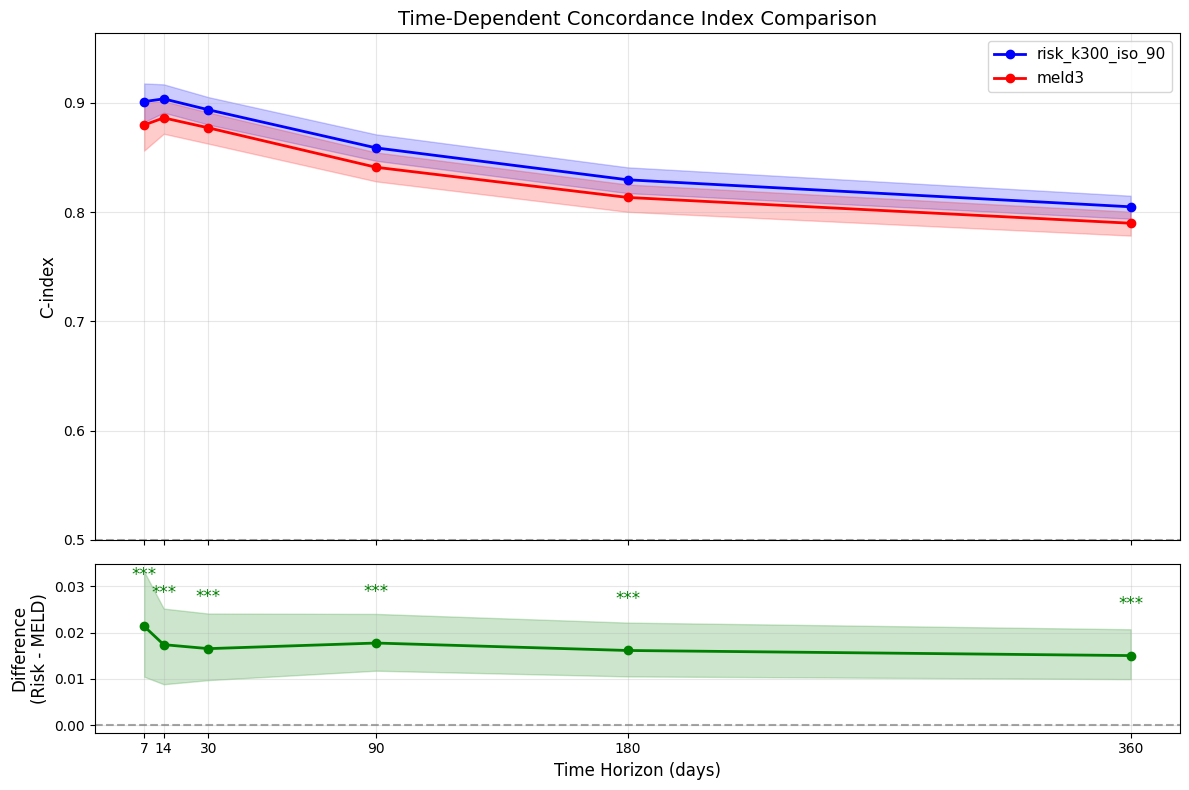

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def direct_cindex_at_horizons(df,
                             risk_col="risk_k300_iso_90",
                             meld_col="meld3",
                             outcome_col="outcome",
                             tte_col="tte",
                             horizons=[7, 14, 30, 90, 180, 360]):
    """
    Compute c-index at multiple horizons for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate

    Returns:
        DataFrame with c-index results for each horizon
    """
    results = []

    for horizon in horizons:
        data_t = df.copy()

        # Label event=1 if death <= horizon, else 0
        data_t['event_t'] = ((data_t[outcome_col] == 0) & (data_t[tte_col] <= horizon)).astype(int)
        # times_t = min(tte, horizon)
        data_t['time_t'] = np.minimum(data_t[tte_col], horizon)

        # Drop rows missing risk or meld
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        data_t = data_t[needed_cols].dropna()

        if data_t.empty:
            print(f"Warning: No valid rows after dropping missing data for horizon {horizon}.")
            c_risk = c_meld = np.nan
        else:
            # Count events for reporting
            n_patients = len(data_t)
            n_events = data_t['event_t'].sum()

            # c-index for risk_col - using negative of risk score
            c_risk = concordance_index(
                data_t['time_t'],
                -data_t[risk_col],  # Negate the risk score
                data_t['event_t']
            )
            # c-index for meld_col - using negative of meld score
            c_meld = concordance_index(
                data_t['time_t'],
                -data_t[meld_col],  # Negate the meld score
                data_t['event_t']
            )

        results.append({
            'horizon': horizon,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': c_risk - c_meld if not np.isnan(c_risk) and not np.isnan(c_meld) else np.nan,
            'n_patients': n_patients if 'n_patients' in locals() else 0,
            'n_events': n_events if 'n_events' in locals() else 0
        })

    return pd.DataFrame(results)


def bootstrap_direct_cindex_at_horizons(df,
                                      risk_col="risk_k300_iso_90",
                                      meld_col="meld3",
                                      outcome_col="outcome",
                                      tte_col="tte",
                                      horizons=[7, 14, 30, 90, 180, 360],
                                      n_bootstraps=500,
                                      random_state=42):
    """
    Bootstrap the difference in c-index at multiple horizons using direct
    lifelines.utils.concordance_index (no repeated CoxPH fits).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility

    Returns:
        DataFrame with bootstrap results for each horizon
    """
    np.random.seed(random_state)
    results = []

    for horizon in horizons:
        print(f"Bootstrapping horizon: {horizon} days")

        # 1) Prepare the main subset
        df_t = df.copy()
        df_t['event_t'] = ((df_t[outcome_col]==0) & (df_t[tte_col] <= horizon)).astype(int)
        df_t['time_t'] = np.minimum(df_t[tte_col], horizon)
        needed = ['time_t', 'event_t', risk_col, meld_col]
        df_t = df_t[needed].dropna()

        if df_t.empty:
            print(f"Warning: No valid data after dropping NAs for horizon {horizon}.")
            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': np.nan,
                f'c_{meld_col}_full': np.nan,
                'orig_diff': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan,
                'n_patients': 0,
                'n_events': 0
            }
        else:
            # 2) Full-sample c-index - using negative of risk scores
            c_risk_full = concordance_index(df_t['time_t'], -df_t[risk_col], df_t['event_t'])
            c_meld_full = concordance_index(df_t['time_t'], -df_t[meld_col], df_t['event_t'])
            orig_diff = c_risk_full - c_meld_full

            # Count patients and events
            n_patients = len(df_t)
            n_events = df_t['event_t'].sum()

            # 3) Bootstrapping
            n = len(df_t)
            c_risk_boot = []
            c_meld_boot = []

            for _ in range(n_bootstraps):
                sample_idx = np.random.randint(0, n, size=n)
                df_boot = df_t.iloc[sample_idx]

                # Skip bootstrap samples with no events or all events
                if df_boot['event_t'].sum() == 0 or df_boot['event_t'].sum() == len(df_boot):
                    continue

                # c-index for risk - using negative of risk score
                c_risk_b = concordance_index(df_boot['time_t'],
                                           -df_boot[risk_col],
                                           df_boot['event_t'])
                # c-index for meld - using negative of meld score
                c_meld_b = concordance_index(df_boot['time_t'],
                                           -df_boot[meld_col],
                                           df_boot['event_t'])

                c_risk_boot.append(c_risk_b)
                c_meld_boot.append(c_meld_b)

            c_risk_boot = np.array(c_risk_boot)
            c_meld_boot = np.array(c_meld_boot)
            diff_boot = c_risk_boot - c_meld_boot

            # 4) Confidence intervals
            ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
            ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
            ci_diff = np.percentile(diff_boot, [2.5, 97.5])

            # 5) Two-sided p-value for diff=0
            if orig_diff >= 0:
                p_one_sided = np.mean(diff_boot < 0)
            else:
                p_one_sided = np.mean(diff_boot > 0)
            p_value = min(2 * p_one_sided, 1.0)

            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': c_risk_full,
                f'c_{meld_col}_full': c_meld_full,
                'orig_diff': orig_diff,
                'ci_risk_lower': ci_risk[0],
                'ci_risk_upper': ci_risk[1],
                'ci_meld_lower': ci_meld[0],
                'ci_meld_upper': ci_meld[1],
                'ci_diff_lower': ci_diff[0],
                'ci_diff_upper': ci_diff[1],
                'p_value': p_value,
                'n_patients': n_patients,
                'n_events': n_events
            }

        results.append(result)

    return pd.DataFrame(results)


def show_bootstrap_results_at_horizons(bootstrap_results, risk_col="risk_k300_iso_90", meld_col="meld3"):
    """
    Nicely print the bootstrap results from all horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
    """
    print("\n=== Time-Dependent Concordance Index (Bootstrap) ===\n")

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']
        print(f"\n--- {horizon}-day Concordance Index ---")
        print(f"Patients: {row['n_patients']}, Events: {row['n_events']} " +
              f"({row['n_events']/row['n_patients']*100:.1f}% event rate)")

        # Risk score c-index
        risk_name = f'c_{risk_col}_full'
        if not pd.isna(row[risk_name]):
            print(f"{risk_col} c-index: {row[risk_name]:.4f}   " +
                  f"(95% CI: [{row['ci_risk_lower']:.4f}, {row['ci_risk_upper']:.4f}])")
        else:
            print(f"{risk_col} c-index: N/A (insufficient data)")

        # MELD score c-index
        meld_name = f'c_{meld_col}_full'
        if not pd.isna(row[meld_name]):
            print(f"{meld_col} c-index: {row[meld_name]:.4f}   " +
                  f"(95% CI: [{row['ci_meld_lower']:.4f}, {row['ci_meld_upper']:.4f}])")
        else:
            print(f"{meld_col} c-index: N/A (insufficient data)")

        # Difference
        if not pd.isna(row['orig_diff']):
            print(f"Difference:       {row['orig_diff']:.4f}   " +
                  f"(95% CI: [{row['ci_diff_lower']:.4f}, {row['ci_diff_upper']:.4f}])")

            # Add significance indicators
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            print(f"p-value (2-sided): {row['p_value']:.4f} {sig}")
        else:
            print("Difference: N/A (insufficient data)")


def plot_cindex_over_time(bootstrap_results, risk_col="risk_k300_iso_90", meld_col="meld3",
                          figsize=(12, 8), save_path=None):
    """
    Plot c-index values and their differences over different time horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
        figsize: Figure size as tuple (width, height)
        save_path: Path to save the figure (optional)
    """
    risk_name = f'c_{risk_col}_full'
    meld_name = f'c_{meld_col}_full'

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Plot c-indices with confidence intervals
    horizons = bootstrap_results['horizon'].values

    # Risk score
    risk_cindices = bootstrap_results[risk_name].values
    risk_lower = bootstrap_results['ci_risk_lower'].values
    risk_upper = bootstrap_results['ci_risk_upper'].values

    ax1.plot(horizons, risk_cindices, 'o-', label=risk_col, color='blue', linewidth=2)
    ax1.fill_between(horizons, risk_lower, risk_upper, alpha=0.2, color='blue')

    # MELD score
    meld_cindices = bootstrap_results[meld_name].values
    meld_lower = bootstrap_results['ci_meld_lower'].values
    meld_upper = bootstrap_results['ci_meld_upper'].values

    ax1.plot(horizons, meld_cindices, 'o-', label=meld_col, color='red', linewidth=2)
    ax1.fill_between(horizons, meld_lower, meld_upper, alpha=0.2, color='red')

    # Formatting for c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title('Time-Dependent Concordance Index Comparison', fontsize=14)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, min(1.0, max(bootstrap_results['ci_risk_upper'].max(),
                                 bootstrap_results['ci_meld_upper'].max()) * 1.05))

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = bootstrap_results['orig_diff'].values
    diff_lower = bootstrap_results['ci_diff_lower'].values
    diff_upper = bootstrap_results['ci_diff_upper'].values

    ax2.plot(horizons, diff_values, 'o-', color='green', linewidth=2)
    ax2.fill_between(horizons, diff_lower, diff_upper, alpha=0.2, color='green')

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(bootstrap_results['p_value']):
        if p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.01 if diff_values[i] > 0 else diff_values[i] - 0.02
            ax2.text(horizons[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Formatting for difference plot
    ax2.set_xlabel('Time Horizon (days)', fontsize=12)
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set x-ticks to be exactly the time points
    plt.xticks(horizons, labels=horizons)

    # Adjust layout and save if requested
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def create_cindex_table(bootstrap_results, risk_col="risk_k300_iso_90", meld_col="meld3"):
    """
    Create a formatted table of c-index results suitable for publication.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    # Prepare table columns
    table_data = []

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']

        # Format values with proper precision
        risk_name = f'c_{risk_col}_full'
        meld_name = f'c_{meld_col}_full'

        if pd.isna(row[risk_name]) or pd.isna(row[meld_name]):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[risk_name]:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[meld_name]:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['orig_diff']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        table_data.append({
            'Horizon (days)': horizon,
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': f"{row['n_events']/row['n_patients']*100:.1f}%" if row['n_patients'] > 0 else "N/A",
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # List of time horizons to evaluate
    horizons = [7, 14, 30, 90, 180, 360]

    # 1) Direct c-index on full data (no bootstrap)
    cindex_results = direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k300_iso_90",
        meld_col="meld3",
        horizons=horizons
    )
    print("\n*** Time-Dependent C-index Results ***")
    print(cindex_results)

    # 2) Bootstrap
    bootstrap_results = bootstrap_direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k300_iso_90",
        meld_col="meld3",
        horizons=horizons,
        n_bootstraps=1000
    )

    # 3) Show results
    show_bootstrap_results_at_horizons(bootstrap_results)

    # 4) Plot results
    plot_cindex_over_time(bootstrap_results, save_path="cindex_over_time.png")

    # 5) Create publication-ready table
    table = create_cindex_table(bootstrap_results)
    print("\n*** Publication-Ready Table ***")
    print(table)
    # Optionally save to CSV
    # table.to_csv("cindex_results_table.csv", index=False)

Processing time point: 7 days...
Processing time point: 14 days...
Processing time point: 30 days...
Processing time point: 90 days...
Processing time point: 180 days...
Processing time point: 360 days...

TIME-DEPENDENT AUC FOR MORTALITY PREDICTION

------------------------------ 7-DAY MORTALITY ------------------------------
Patients: 12188, Deaths: 171 (1.4%)

meld3               : AUC = 0.9114 (95% CI: 0.8908-0.9296)
risk_k300_iso_90    : AUC = 0.9300 (95% CI: 0.9142-0.9436)

DeLong Test Comparisons:
risk_k300_iso_90 > meld3 : Δ = 0.0186, p = 0.0004 ***

------------------------------ 14-DAY MORTALITY ------------------------------
Patients: 10911, Deaths: 318 (2.9%)

meld3               : AUC = 0.9234 (95% CI: 0.9092-0.9365)
risk_k300_iso_90    : AUC = 0.9381 (95% CI: 0.9260-0.9496)

DeLong Test Comparisons:
risk_k300_iso_90 > meld3 : Δ = 0.0148, p = 0.0000 ***

------------------------------ 30-DAY MORTALITY ------------------------------
Patients: 9653, Deaths: 498 (5.2%)

meld3

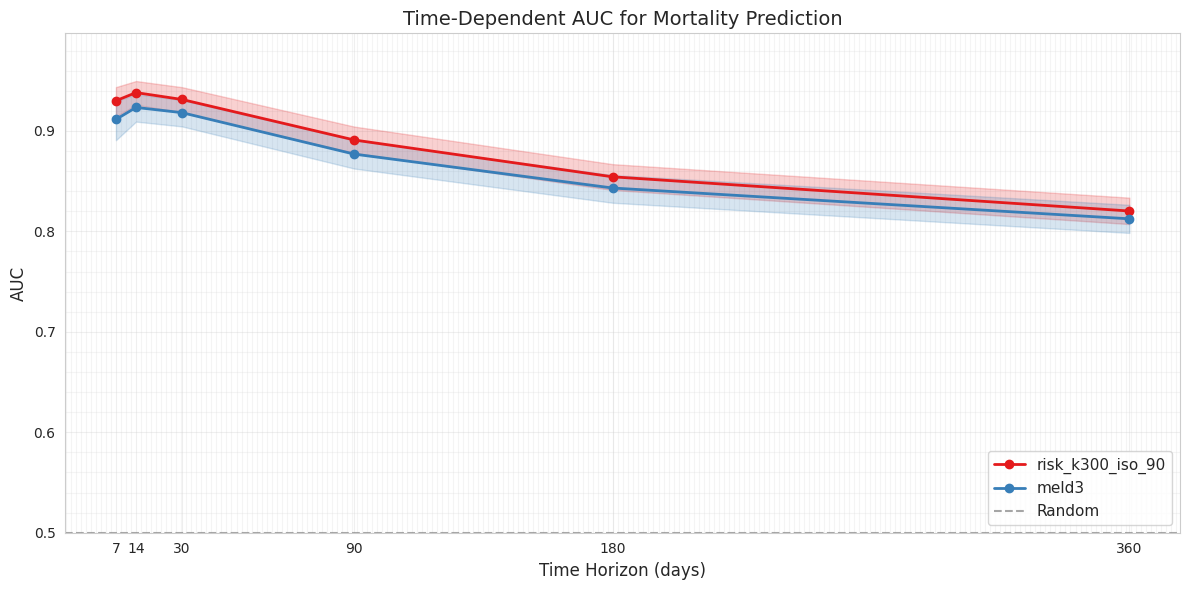

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def delong_test(y_true, y_pred1, y_pred2):
    """
    Implementation of DeLong's test for comparing two AUCs.

    Parameters:
    -----------
    y_true : array-like
        Binary ground truth (0/1)
    y_pred1 : array-like
        Predictions from first model
    y_pred2 : array-like
        Predictions from second model

    Returns:
    --------
    auc1 : float
        AUC of first model
    auc2 : float
        AUC of second model
    p_value : float
        Two-sided p-value from DeLong's test
    """
    # Calculate AUCs
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)

    # Get positive and negative indices
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]

    # Get predictions for positives and negatives
    pos_pred1 = y_pred1[pos_idx]
    neg_pred1 = y_pred1[neg_idx]
    pos_pred2 = y_pred2[pos_idx]
    neg_pred2 = y_pred2[neg_idx]

    # Calculate V10 and V01 (components of variance)
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    # Calculate psi matrix
    psi1_pos = np.zeros(n_pos)
    psi1_neg = np.zeros(n_neg)
    psi2_pos = np.zeros(n_pos)
    psi2_neg = np.zeros(n_neg)

    # For each positive example
    for i in range(n_pos):
        psi1_pos[i] = (np.sum(neg_pred1 < pos_pred1[i]) + 0.5 * np.sum(neg_pred1 == pos_pred1[i])) / n_neg
        psi2_pos[i] = (np.sum(neg_pred2 < pos_pred2[i]) + 0.5 * np.sum(neg_pred2 == pos_pred2[i])) / n_neg

    # For each negative example
    for i in range(n_neg):
        psi1_neg[i] = (np.sum(pos_pred1 > neg_pred1[i]) + 0.5 * np.sum(pos_pred1 == neg_pred1[i])) / n_pos
        psi2_neg[i] = (np.sum(pos_pred2 > neg_pred2[i]) + 0.5 * np.sum(pos_pred2 == neg_pred2[i])) / n_pos

    # Calculate variances
    var_pos = np.var(psi1_pos - psi2_pos, ddof=1) / n_pos
    var_neg = np.var(psi1_neg - psi2_neg, ddof=1) / n_neg
    var = var_pos + var_neg

    # Calculate z-score and p-value
    if var == 0:
        return auc1, auc2, 1.0  # No difference or insufficient data

    z = (auc1 - auc2) / np.sqrt(var)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-sided p-value

    return auc1, auc2, p_value


def time_dependent_auc_with_delong(
    df,
    risk_cols=['risk_k300_iso_90', 'meld3'],
    outcome_col='outcome',
    tte_col='tte',
    time_points=[7, 14, 30, 90, 180, 360],
    bootstrap=True,
    n_bootstrap=1000,
    random_state=42
):
    """
    Compute time-dependent AUC for mortality prediction at various horizons,
    with DeLong's test for comparing AUCs.

    Args:
        df (pd.DataFrame): Must contain:
            - tte_col: Time to event or censor
            - outcome_col: Outcome (0=death, 1=censoring, 2=transplant)
            - risk_cols: Risk score columns (higher => higher risk)
        risk_cols (list): Column names for risk scores
        outcome_col (str): Column name for outcome
        tte_col (str): Column name for time-to-event
        time_points (list): List of integer day horizons
        bootstrap (bool): Whether to perform bootstrap for CIs
        n_bootstrap (int): Number of bootstrap iterations
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (results_df, comparison_df)
    """
    # Set random seed
    np.random.seed(random_state)

    # Ensure required columns exist
    required_cols = [tte_col, outcome_col] + risk_cols
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe.")

    results = []
    comparisons = []

    # Copy data to avoid modifying original
    df_all = df.copy()

    # For each time point
    for t in time_points:
        print(f"Processing time point: {t} days...")

        # 'At-risk' set: those who have sufficient follow-up
        at_risk_mask = (
            (df_all[tte_col] >= t) |
            ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # Define event indicator: 1 if died by time t, 0 otherwise
        event_mask = (
            (df_at_risk[outcome_col] == 0) &
            (df_at_risk[tte_col] <= t)
        )
        df_at_risk['event_indicator'] = event_mask.astype(int)

        # Store relevant data for each model
        model_data = {}
        model_aucs = {}

        # Calculate AUC for each risk model and store data for DeLong test
        for risk_col in risk_cols:
            # Drop rows with missing risk scores
            valid_data = df_at_risk[['event_indicator', risk_col]].dropna()

            if (valid_data['event_indicator'].sum() > 0 and
                valid_data['event_indicator'].sum() < len(valid_data)):

                # Store data for DeLong test
                model_data[risk_col] = valid_data

                # Calculate AUC
                auc = roc_auc_score(valid_data['event_indicator'], valid_data[risk_col])
                model_aucs[risk_col] = auc

                # Bootstrap confidence intervals if requested
                if bootstrap:
                    bootstrap_aucs = []

                    for _ in range(n_bootstrap):
                        # Sample with replacement
                        bootstrap_sample = valid_data.sample(n=len(valid_data), replace=True)

                        # Skip if bootstrap sample has all events or no events
                        if (bootstrap_sample['event_indicator'].sum() == 0 or
                            bootstrap_sample['event_indicator'].sum() == len(bootstrap_sample)):
                            continue

                        bootstrap_auc = roc_auc_score(
                            bootstrap_sample['event_indicator'],
                            bootstrap_sample[risk_col]
                        )
                        bootstrap_aucs.append(bootstrap_auc)

                    # Calculate confidence intervals
                    if bootstrap_aucs:
                        lower_ci, upper_ci = np.percentile(bootstrap_aucs, [2.5, 97.5])
                    else:
                        lower_ci = upper_ci = np.nan
                else:
                    lower_ci = upper_ci = np.nan
            else:
                auc = lower_ci = upper_ci = np.nan

            # Store results
            results.append({
                'time_point': t,
                'model': risk_col,
                'auc': auc,
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'n_patients': len(valid_data) if 'valid_data' in locals() else 0,
                'n_events': valid_data['event_indicator'].sum() if 'valid_data' in locals() and not valid_data.empty else 0
            })

        # Perform DeLong's test for pairwise comparisons
        if len(risk_cols) > 1:
            for i, model_i in enumerate(risk_cols):
                for j, model_j in enumerate(risk_cols):
                    if i < j:  # Only compare each pair once
                        # Get the intersection of patients with valid scores for both models
                        if model_i in model_data and model_j in model_data:
                            common_indices = model_data[model_i].index.intersection(model_data[model_j].index)

                            if len(common_indices) == 0:
                                continue

                            # Extract data for common patients
                            y_true = df_at_risk.loc[common_indices, 'event_indicator'].values
                            y_pred1 = df_at_risk.loc[common_indices, model_i].values
                            y_pred2 = df_at_risk.loc[common_indices, model_j].values

                            # Check if we have both positive and negative cases
                            if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
                                # Perform DeLong's test
                                auc1, auc2, p_value = delong_test(y_true, y_pred1, y_pred2)

                                # Store comparison results
                                comparisons.append({
                                    'time_point': t,
                                    'model_i': model_i,
                                    'model_j': model_j,
                                    'auc_i': auc1,
                                    'auc_j': auc2,
                                    'auc_diff': auc1 - auc2,
                                    'p_value': p_value,
                                    'significant': p_value < 0.05,
                                    'test': 'DeLong'
                                })

    # Convert to DataFrames
    results_df = pd.DataFrame(results)
    comparison_df = pd.DataFrame(comparisons)

    return results_df, comparison_df


def plot_time_dependent_auc(results_df, models=None, figsize=(12, 6), save_path=None):
    """
    Plot time-dependent AUC with confidence intervals.

    Args:
        results_df (pd.DataFrame): Results from time_dependent_auc_with_delong
        models (list, optional): Models to include (default: all)
        figsize (tuple): Figure size
        save_path (str, optional): Path to save the figure

    Returns:
        matplotlib.pyplot.Figure: The figure object
    """
    if models is None:
        models = results_df['model'].unique()

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Color palette
    colors = sns.color_palette("Set1", len(models))

    for i, model in enumerate(models):
        model_data = results_df[results_df['model'] == model]

        # Skip if empty
        if model_data.empty:
            continue

        # Sort by time point
        model_data = model_data.sort_values('time_point')

        # Plot AUC line
        plt.plot(model_data['time_point'], model_data['auc'],
                marker='o', linewidth=2, label=model, color=colors[i])

        # Add confidence intervals
        if not model_data['lower_ci'].isna().all():
            plt.fill_between(
                model_data['time_point'],
                model_data['lower_ci'],
                model_data['upper_ci'],
                alpha=0.2,
                color=colors[i]
            )

    # Add reference line for random classifier
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Customize plot
    plt.xlabel('Time Horizon (days)', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.title('Time-Dependent AUC for Mortality Prediction', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, min(1.0, results_df['upper_ci'].max() * 1.05))

    # Set x-ticks to be exactly the time points
    time_points = sorted(results_df['time_point'].unique())
    plt.xticks(time_points, labels=time_points)

    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.2)
    plt.minorticks_on()

    # Tight layout
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt.gcf()


def print_auc_report(results_df, comparison_df):
    """
    Print a formatted report of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame): Comparison DataFrame with DeLong test results
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    print("\n" + "="*70)
    print("TIME-DEPENDENT AUC FOR MORTALITY PREDICTION")
    print("="*70)

    for t in time_points:
        print(f"\n{'-'*30} {t}-DAY MORTALITY {'-'*30}")

        # Get results for this time point
        time_results = results_df[results_df['time_point'] == t]

        # Print sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()
        print(f"Patients: {n_patients}, Deaths: {n_events} ({n_events/n_patients*100:.1f}%)\n")

        # Print AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    print(f"{model:20s}: AUC = {auc:.4f} (95% CI: {lower_ci:.4f}-{upper_ci:.4f})")
                else:
                    print(f"{model:20s}: AUC = {auc:.4f}")
            else:
                print(f"{model:20s}: AUC = N/A (insufficient data)")

        # Print DeLong test comparisons
        time_comparisons = comparison_df[comparison_df['time_point'] == t]

        if not time_comparisons.empty:
            print("\nDeLong Test Comparisons:")
            for _, row in time_comparisons.iterrows():
                model_i = row['model_i']
                model_j = row['model_j']
                auc_diff = row['auc_diff']
                p_value = row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = " ***"
                    elif p_value < 0.01:
                        sig = " **"
                    elif p_value < 0.05:
                        sig = " *"

                    if auc_diff > 0:
                        comparison_text = f"{model_i} > {model_j}"
                    elif auc_diff < 0:
                        comparison_text = f"{model_i} < {model_j}"
                    else:
                        comparison_text = f"{model_i} = {model_j}"

                    print(f"{comparison_text:25s}: Δ = {auc_diff:.4f}, p = {p_value:.4f}{sig}")


def create_auc_table(results_df, comparison_df=None):
    """
    Create a formatted table of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame, optional): Comparison DataFrame with DeLong test results

    Returns:
        pd.DataFrame: Formatted results table
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    # Create table structure
    table_data = []

    for t in time_points:
        time_results = results_df[results_df['time_point'] == t]

        # Get sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()

        row = {
            'Time Point (days)': t,
            'N Patients': n_patients,
            'N Deaths': n_events,
            '% Deaths': f"{n_events/n_patients*100:.1f}%"
        }

        # Add AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    row[f'{model} AUC (95% CI)'] = f"{auc:.4f} ({lower_ci:.4f}-{upper_ci:.4f})"
                else:
                    row[f'{model} AUC'] = f"{auc:.4f}"
            else:
                row[f'{model} AUC'] = "N/A"

        # Add comparison results if provided
        if comparison_df is not None:
            time_comparisons = comparison_df[comparison_df['time_point'] == t]

            for _, comp_row in time_comparisons.iterrows():
                model_i = comp_row['model_i']
                model_j = comp_row['model_j']
                auc_diff = comp_row['auc_diff']
                p_value = comp_row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = "***"
                    elif p_value < 0.01:
                        sig = "**"
                    elif p_value < 0.05:
                        sig = "*"

                    row[f'{model_i} vs {model_j} (p-value)'] = f"{auc_diff:.4f} ({p_value:.4f}){sig}"
                else:
                    row[f'{model_i} vs {model_j} (p-value)'] = "N/A"

        table_data.append(row)

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # Example dataframe (replace with your actual data)
    # Assuming:
    # - 'tte': Time to event in days
    # - 'outcome': 0=death, 1=censored, 2=transplant
    # - 'risk_k200_iso_90': Your isotonic risk score
    # - 'meld3': MELD-3 score

    results_df, comparison_df = time_dependent_auc_with_delong(
        df=real_df,
        risk_cols=['risk_k300_iso_90', 'meld3'],
        outcome_col='outcome',
        tte_col='tte',
        time_points=[7, 14, 30, 90, 180, 360],
        bootstrap=True,
        n_bootstrap=1000
    )

    # # Create visualization
    plot_time_dependent_auc(results_df, save_path='time_dependent_auc.png')

    # # Print detailed report
    print_auc_report(results_df, comparison_df)

    # # Create formatted table
    results_table = create_auc_table(results_df, comparison_df)
    results_table.to_csv('time_dependent_auc_results.csv', index=False)
    print("\nResults saved to 'time_dependent_auc_results.csv'")

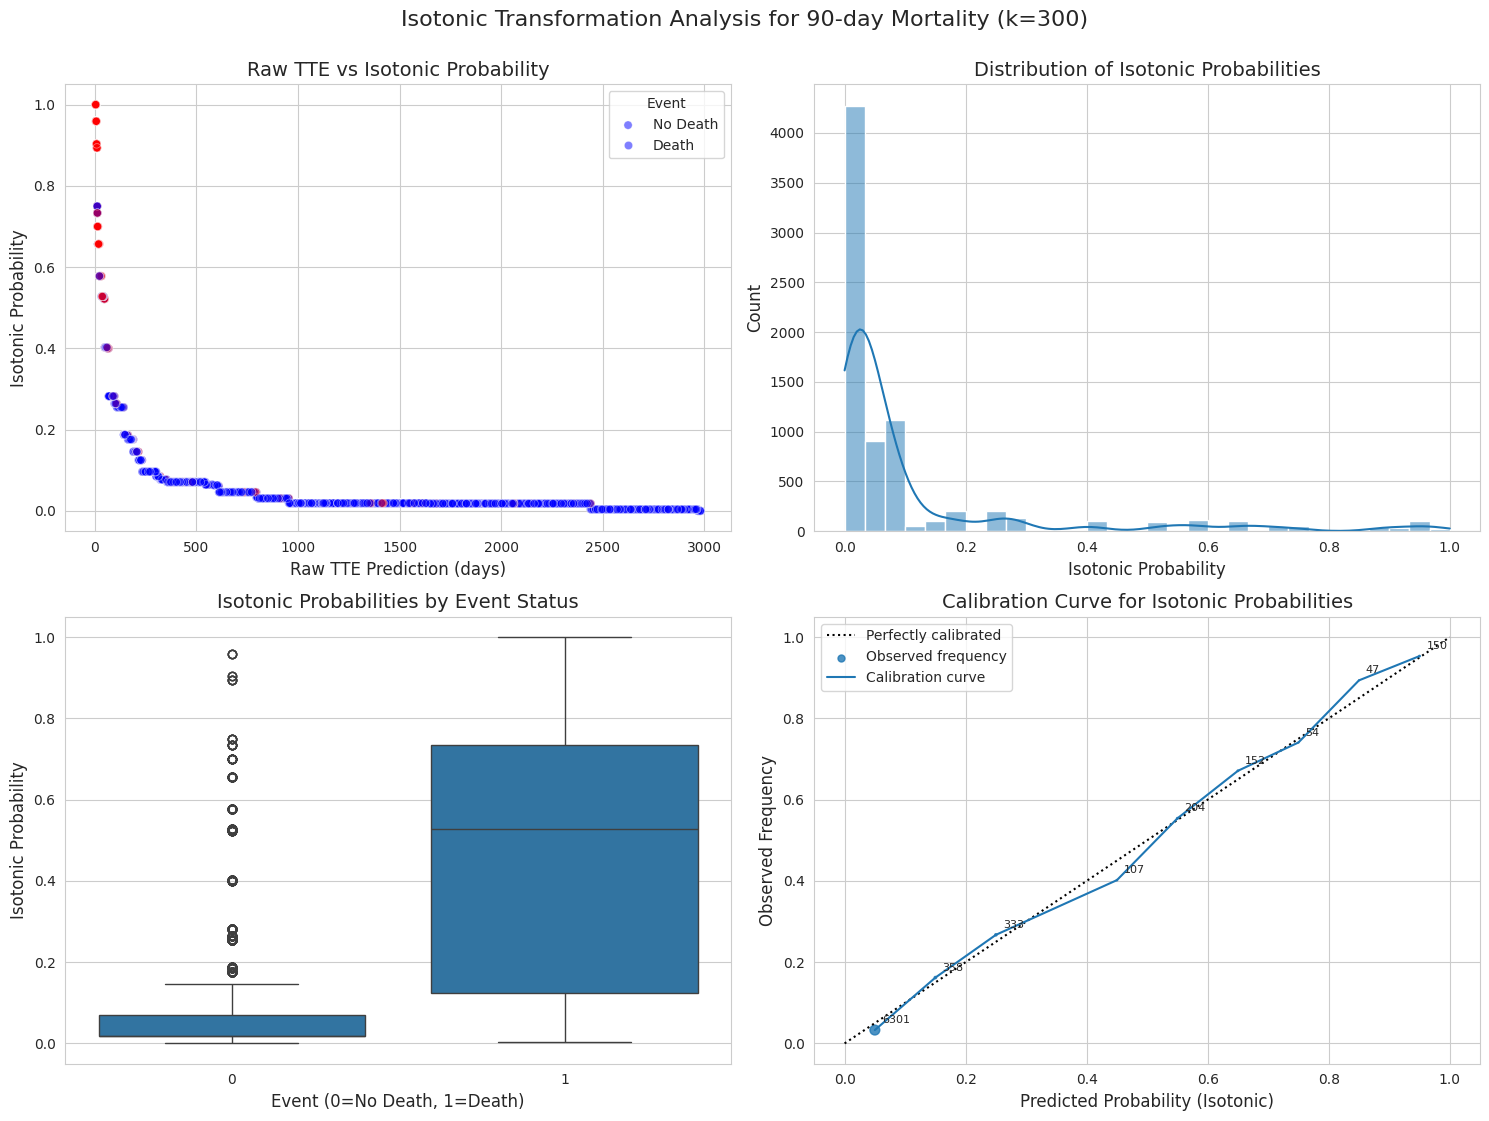

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

def visualize_isotonic_transform(df, timepoint=90, k=300, figsize=(15, 12), save_path=None):
    """
    Visualize the isotonic transformation of TTE predictions for k=200.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    figsize : tuple
        Figure size
    save_path : str, optional
        Path to save the figure

    Returns:
    --------
    matplotlib.figure.Figure
    """
    # Define at-risk set and event indicator
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    # Get prediction column
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # Compute isotonic calibration
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Apply calibration
    iso_probs = ir.predict(X)

    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        'Raw_TTE': tte_series.values,
        'Negative_TTE': X,
        'Isotonic_Prob': iso_probs,
        'Event': Y
    })

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # 1. Raw TTE vs Isotonic probability
    ax1 = axes[0, 0]
    sns.scatterplot(
        data=plot_df,
        x='Raw_TTE',
        y='Isotonic_Prob',
        hue='Event',
        palette={0:'blue', 1:'red'},
        alpha=0.5,
        ax=ax1
    )
    ax1.set_xlabel('Raw TTE Prediction (days)', fontsize=12)
    ax1.set_ylabel('Isotonic Probability', fontsize=12)
    ax1.set_title('Raw TTE vs Isotonic Probability', fontsize=14)
    ax1.legend(title='Event', labels=['No Death', 'Death'])

    # 2. Histogram of isotonic probabilities
    ax2 = axes[0, 1]
    sns.histplot(
        data=plot_df,
        x='Isotonic_Prob',
        bins=30,
        kde=True,
        ax=ax2
    )
    ax2.set_xlabel('Isotonic Probability', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Distribution of Isotonic Probabilities', fontsize=14)

    # 3. Isotonic probability by event status
    ax3 = axes[1, 0]
    sns.boxplot(
        data=plot_df,
        x='Event',
        y='Isotonic_Prob',
        ax=ax3
    )
    ax3.set_xlabel('Event (0=No Death, 1=Death)', fontsize=12)
    ax3.set_ylabel('Isotonic Probability', fontsize=12)
    ax3.set_title('Isotonic Probabilities by Event Status', fontsize=14)

    # 4. Calibration curve for isotonic probability
    ax4 = axes[1, 1]

    # Create bins and calculate observed frequencies
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(iso_probs, bin_edges[1:-1])

    observed_freqs = []
    bin_counts = []
    for i in range(n_bins):
        mask = (bin_indices == i)
        if np.sum(mask) > 0:
            observed_freqs.append(np.mean(Y[mask]))
            bin_counts.append(np.sum(mask))
        else:
            observed_freqs.append(np.nan)
            bin_counts.append(0)

    # Plot calibration curve
    ax4.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    # Only plot points with data
    valid_indices = [i for i, count in enumerate(bin_counts) if count > 0]
    valid_centers = [bin_centers[i] for i in valid_indices]
    valid_freqs = [observed_freqs[i] for i in valid_indices]
    valid_counts = [bin_counts[i] for i in valid_indices]

    # Scale point sizes by count
    sizes = [50 * (count / max(valid_counts)) for count in valid_counts]
    ax4.scatter(valid_centers, valid_freqs, s=sizes, alpha=0.8, label='Observed frequency')

    for i, (x, y, count) in enumerate(zip(valid_centers, valid_freqs, valid_counts)):
        ax4.annotate(f"{count}", (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.plot(valid_centers, valid_freqs, '-', label='Calibration curve')
    ax4.set_xlabel('Predicted Probability (Isotonic)', fontsize=12)
    ax4.set_ylabel('Observed Frequency', fontsize=12)
    ax4.set_title('Calibration Curve for Isotonic Probabilities', fontsize=14)
    ax4.legend(loc='upper left')

    # # Add summary statistics
    # stats_text = (
    #     f"Isotonic Probability Statistics:\n"
    #     f"Min: {plot_df['Isotonic_Prob'].min():.4f}\n"
    #     f"Max: {plot_df['Isotonic_Prob'].max():.4f}\n"
    #     f"Mean: {plot_df['Isotonic_Prob'].mean():.4f}\n"
    #     f"Median: {plot_df['Isotonic_Prob'].median():.4f}\n"
    #     f"Std Dev: {plot_df['Isotonic_Prob'].std():.4f}\n\n"
    #     f"For patients who died (Event=1):\n"
    #     f"Mean Prob: {plot_df[plot_df['Event']==1]['Isotonic_Prob'].mean():.4f}\n"
    #     f"For patients who survived (Event=0):\n"
    #     f"Mean Prob: {plot_df[plot_df['Event']==0]['Isotonic_Prob'].mean():.4f}"
    # )

    # # Add text to the figure
    # fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the text at the bottom

    # Add overall title
    fig.suptitle(f'Isotonic Transformation Analysis for {timepoint}-day Mortality (k={k})',
                 fontsize=16, y=0.98)

    # Save if specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

# Example usage:
fig = visualize_isotonic_transform(
    real_df,
    timepoint=90,
    k=300,
    save_path='isotonic_transform_analysis_k300.png'
)
plt.show()

In [ ]:
def add_isotonic_risk_scores_to_df(df, timepoint=90, k=300, min_score=1, max_score=100, save_path=None):
    """
    Calculate isotonic probabilities, transform them to risk scores (1-100),
    and add them to the original dataframe.

    Parameters:
    -----------
    df : pandas DataFrame
        Original DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    min_score : int
        Minimum score value (default: 1)
    max_score : int
        Maximum score value (default: 100)
    save_path : str, optional
        Path to save the CSV file (default: None)

    Returns:
    --------
    df_with_scores : pandas DataFrame
        Original DataFrame with added risk score columns
    """
    import numpy as np
    import pandas as pd
    from sklearn.isotonic import IsotonicRegression

    # Create a copy of the original dataframe to avoid modifying it
    df_with_scores = df.copy()

    # Define at-risk set and event indicator
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    # Get prediction column
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # Compute isotonic calibration
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Initialize new columns with NaN values
    isotonic_col = f'isotonic_prob_k{k}_t{timepoint}'
    risk_score_col = f'risk_score_k{k}_t{timepoint}'
    df_with_scores[isotonic_col] = np.nan
    df_with_scores[risk_score_col] = np.nan

    # Calculate isotonic probabilities for all patients with valid predictions
    for idx, row in df.iterrows():
        if pd.notna(row[pred_col]):
            # Use negative TTE for prediction (same as in training)
            neg_tte = -row[pred_col]

            # Get isotonic probability
            iso_prob = ir.predict([neg_tte])[0]

            # Transform to risk score
            risk_score = int(np.round(min_score + (max_score - min_score) * iso_prob))
            risk_score = max(min_score, min(max_score, risk_score))

            # Add to dataframe
            df_with_scores.loc[idx, isotonic_col] = iso_prob
            df_with_scores.loc[idx, risk_score_col] = risk_score

    # Print summary statistics
    valid_scores = df_with_scores[risk_score_col].dropna()
    print(f"Added {len(valid_scores)} risk scores to dataframe")
    print(f"New columns: '{isotonic_col}' and '{risk_score_col}'")
    print("\nRisk Score Statistics:")
    print(f"Min: {valid_scores.min()}")
    print(f"Max: {valid_scores.max()}")
    print(f"Mean: {valid_scores.mean():.1f}")
    print(f"Median: {valid_scores.median():.1f}")

    # Save to CSV if specified
    if save_path:
        df_with_scores.to_csv(save_path, index=True)
        print(f"\nSaved complete dataframe to: {save_path}")

    return df_with_scores

# Example usage:
real_df_with_scores = add_isotonic_risk_scores_to_df(
    real_df,
    timepoint=90,
    k=300,
    save_path='real_df_with_risk_scores.csv'
)

Added 14632 risk scores to dataframe
New columns: 'isotonic_prob_k300_t90' and 'risk_score_k300_t90'

Risk Score Statistics:
Min: 1.0
Max: 100.0
Mean: 26.2
Median: 8.0

Saved complete dataframe to: real_df_with_risk_scores.csv


In [ ]:
real_df = pd.read_csv('/content/real_df_with_risk_scores.csv')

In [ ]:
real_df

Unnamed: 0  Age Gender ABO        BMI     Na    Cr Dialysis   INR  Bili  Albumin  MELD  outcome  tte Etiology               Ethnicity diab_group_labeled Encephalopathy_Status Ascites_Status  meld3  predicted_death_tte_k100  predicted_death_tte_k200  predicted_death_tte_k300  predicted_death_tte_k500  predicted_death_tte_k750  predicted_death_tte_k1000  risk_k300_iso_90  isotonic_prob_k300_t90  risk_score_k300_t90
0               0   54      F   O  19.753265  134.0  0.90        N  1.40   4.9      2.8    18        2   48  Biliary                   White        No Diabetes             Grade 1-2         Slight     20                835.950815                835.950815                825.299582                735.888198                700.736690                 602.039001          0.023018                0.030853                  4.0
1               1   45      M   O  43.625332  133.0  5.94        N  2.20  34.1      2.7    42        2   11  Alcohol  Black/African American        No Diabetes             Grade 1-2       Moderate     41                  7.505273                  8.939535                  8.000000                  8.000000                  7.582932                   7.582932          0.113786                0.959184                 96.0
2               2   62      F   O  26.477456  135.0  0.91        N  3.80   3.3      3.4    27        1  999     NASH                   White        No Diabetes             Grade 1-2         Slight     26                125.611786                198.544570                198.544570                228.011890                243.919728                 265.377337          0.069519                0.145631                 15.0
3               3   71      F   O  25.087994  135.0  0.94        N  1.69   5.7      2.5    20        2   13     NASH                   White           Diabetes             Grade 1-2         Slight     23                288.698061                220.321031                208.994629                211.201152                212.956032                 226.445270          0.056604                0.145631                 15.0
4               4   64      M   O  39.195016  139.0  1.02        N  1.20   0.4      4.0     8        0  780    Viral  Black/African American           Diabetes                   NaN         Slight      8               2494.889760               2494.889760               2517.194086               2894.679744               2517.194086                2494.889760          0.003356                0.003807                  1.0
...           ...  ...    ...  ..        ...    ...   ...      ...   ...   ...      ...   ...      ...  ...      ...                     ...                ...                   ...            ...    ...                       ...                       ...                       ...                       ...                       ...                        ...               ...                     ...                  ...
14627       14627   49      M  AB  32.764703  145.0  0.91        N  3.00  10.5      2.9    28        0   13    Viral                   Asian        No Diabetes                   NaN       Moderate     28                 27.743956                 37.043016                 37.394988                 34.492513                 31.470823                  27.703495          0.104663                0.527778                 53.0
14628       14628   59      M   O  30.131523  127.0  0.82        N  1.40   3.3      3.0    23        2   52  Alcohol                   White           Diabetes             Grade 1-2         Slight     21                986.927992                583.625388                668.347544                668.347544                675.098195                 685.444611          0.031419                0.046252                  6.0
14629       14629   56      M   O  34.299991  134.0  0.88        N  4.40   4.9      1.4    30        2   13  Alcohol  Black/African American        No Diabetes             Grade 1-2       Mod

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import os

# Define the save directory
save_dir = '/content/drive/MyDrive/SyntheticData/saved_models'
os.makedirs(save_dir, exist_ok=True)

# 1. Save the trained model
torch.save(model_metric.state_dict(), f'{save_dir}/metric_model.pth')

# 2. Save synthetic embeddings
np.save(f'{save_dir}/synthetic_embeddings.npy', syn_embeddings)

# 3. Save reference synthetic data with necessary columns
syn_df_processed[['tte', 'outcome']].to_csv(f'{save_dir}/synthetic_reference_data.csv', index=True)

# 4. Save the scaler used for feature normalization
with open(f'{save_dir}/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# 5. Save the categorical feature names for encoding
with open(f'{save_dir}/cat_feature_names.pkl', 'wb') as f:
    pickle.dump(list(cat_feature_names), f)

# 6. Save the isotonic regression model if you're using it
# (If you're using the model from add_isotonic_90days_k300 function)
try:
    ir = IsotonicRegression(out_of_bounds='clip')
    # Get TTE values and event indicators for fitting
    tte_series = real_df['predicted_death_tte_k300'].dropna()
    common_idx = tte_series.index.intersection(real_df['outcome'].index)
    X = -tte_series.loc[common_idx].values  # Negative TTE
    Y = (real_df.loc[common_idx, 'outcome'] == 0).astype(int).values  # Death event

    ir.fit(X, Y)

    with open(f'{save_dir}/isotonic_model_k300.pkl', 'wb') as f:
        pickle.dump(ir, f)
    print("Isotonic model saved")
except Exception as e:
    print(f"Could not save isotonic model: {str(e)}")

# 7. Save other important parameters
params = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'input_dim': input_dim,
    'embedding_dim': 64,
    'device': str(device),
    'k_neighbors': 300  # For k=300 predictions
}

with open(f'{save_dir}/model_params.pkl', 'wb') as f:
    pickle.dump(params, f)

print(f"All model components saved to {save_dir}")

Isotonic model saved
All model components saved to /content/drive/MyDrive/SyntheticData/saved_models


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.isotonic import IsotonicRegression
from ipywidgets import widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

#############################
# 1) LOAD ALL SAVED ARTIFACTS
#############################

save_dir = '/content/drive/MyDrive/SyntheticData/saved_models'  # adjust if needed

# Load model parameters
with open(os.path.join(save_dir, 'model_params.pkl'), 'rb') as f:
    params = pickle.load(f)

numeric_features = params['numeric_features']
categorical_features = params['categorical_features']
embedding_dim = params['embedding_dim']
k_neighbors = params['k_neighbors']  # typically 300

# Load scaler
with open(os.path.join(save_dir, 'feature_scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

# Load cat_feature_names
with open(os.path.join(save_dir, 'cat_feature_names.pkl'), 'rb') as f:
    cat_feature_names = pickle.load(f)

# Load isotonic model if it exists
iso_model_path = os.path.join(save_dir, 'isotonic_model_k300.pkl')
try:
    with open(iso_model_path, 'rb') as f:
        iso_model = pickle.load(f)
except Exception as e:
    print(f"Warning: Could not load isotonic_model_k300.pkl: {e}")
    iso_model = None

# Load synthetic embeddings (numpy array)
syn_embeddings = np.load(os.path.join(save_dir, 'synthetic_embeddings.npy'))

# Load synthetic reference CSV
syn_reference_path = os.path.join(save_dir, 'synthetic_reference_data.csv')
syn_reference = pd.read_csv(syn_reference_path, index_col=0)  # should have 'tte','outcome'

# MetricNet definition to load state_dict
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()
        layers = []
        current_dim = input_dim

        for hd in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hd),
                nn.BatchNorm1d(hd),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hd
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

# Build a new instance with correct input_dim
input_dim = params['input_dim']
metric_model = MetricNet(input_dim, embedding_dim=embedding_dim)
metric_model.eval()

model_path = os.path.join(save_dir, 'metric_model.pth')
state_dict = torch.load(model_path, map_location='cpu')
metric_model.load_state_dict(state_dict)
print("MetricNet model loaded successfully!")


##############################################
# 2) CLASS FOR PREDICTION USING LOADED ARTIFACTS
##############################################

class LiverPredictor:
    def __init__(
        self,
        model_metric,
        scaler,
        cat_feature_names,
        numeric_features,
        categorical_features,
        syn_embeddings,
        syn_reference,
        iso_model=None,
        k_neighbors=300
    ):
        self.model_metric = model_metric.eval()
        self.scaler = scaler
        self.cat_feature_names = cat_feature_names
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.syn_embeddings = syn_embeddings
        self.syn_reference = syn_reference
        self.iso_model = iso_model
        self.k_neighbors = k_neighbors

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors, algorithm='auto')
        self.nbrs.fit(self.syn_embeddings)

    def _process_input(self, patient_dict):
        df = pd.DataFrame([patient_dict])
        X_num = df[self.numeric_features].astype(float)
        X_num_scaled = self.scaler.transform(X_num)

        X_cat = pd.get_dummies(df[self.categorical_features].astype(str), drop_first=False)
        X_cat = X_cat.reindex(columns=self.cat_feature_names, fill_value=0)

        X_combined = np.hstack([X_num_scaled, X_cat.values]).astype(np.float32)
        return X_combined

    def _embed_patient(self, X):
        with torch.no_grad():
            x_tensor = torch.tensor(X, dtype=torch.float32)
            emb = self.model_metric(x_tensor)
        return emb.numpy()

    def predict(self, patient_dict):
        X = self._process_input(patient_dict)
        emb = self._embed_patient(X)   # shape (1, embed_dim)

        dist, idx = self.nbrs.kneighbors(emb)
        idx = idx.flatten()  # neighbor indices

        neighbor_tte = self.syn_reference.loc[idx, 'tte'].values
        neighbor_outcome = self.syn_reference.loc[idx, 'outcome'].values

        median_tte = np.median(neighbor_tte)

        # isotonic probability => risk
        if self.iso_model is not None:
            neg_tte = -median_tte
            prob_death_90d = float(self.iso_model.predict([neg_tte])[0])
            risk_1_100 = int(round(1 + 99*prob_death_90d))
            risk_1_100 = max(1, min(100, risk_1_100))
        else:
            prob_death_90d = None
            risk_1_100 = None

        return {
            'median_tte': median_tte,
            'neighbor_tte': neighbor_tte,
            'neighbor_outcome': neighbor_outcome,
            'neighbor_idx': idx,           # <-- Add neighbor indices
            'iso_prob_90d': prob_death_90d,
            'risk_1_100': risk_1_100
        }


###################################
# 3) PCA Plot + KM Plot (0..360 days)
###################################

def plot_neighbor_pca_0to360(neighbor_idx, syn_embeddings, syn_reference):
    """
    Perform a PCA on the embeddings of the chosen neighbors.
    Color points by TTE (capped at 360).
    """
    # Subset the neighbors' embeddings
    emb_neighbors = syn_embeddings[neighbor_idx]

    # Get neighbor TTE, outcome from syn_reference
    df_neighbors = syn_reference.iloc[neighbor_idx].copy()
    # clip TTE to [0..360]
    df_neighbors['tte_clipped'] = np.minimum(df_neighbors['tte'], 360)

    # PCA
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb_neighbors)

    # Plot
    fig, ax = plt.subplots(figsize=(8,6))
    sc = ax.scatter(
        emb_2d[:,0], emb_2d[:,1],
        c=df_neighbors['tte_clipped'],
        cmap='viridis',
        alpha=0.8,
        s=60,
        edgecolors='black'
    )
    cb = plt.colorbar(sc, ax=ax)
    cb.set_label("TTE (days, clipped at 360)")
    ax.set_title("Neighbor PCA (color by TTE up to 360)")
    ax.set_xlabel(f"PC1 (var={pca.explained_variance_ratio_[0]:.2f})")
    ax.set_ylabel(f"PC2 (var={pca.explained_variance_ratio_[1]:.2f})")

    return fig

def plot_neighbor_km_0to360(neighbor_tte, neighbor_outcome):
    """
    KM curve among neighbors, capping TTE at 360 => censor if TTE>360.
    Also draw a horizontal dotted line at 50% survival and vertical dotted line
    at the median survival time if within 0..360.
    """
    # 1) Clip TTE at 360 and create event array
    tte_clipped = np.minimum(neighbor_tte, 360).copy()
    events = []
    for orig_t, outc in zip(neighbor_tte, neighbor_outcome):
        if outc == 0 and orig_t <= 360:
            events.append(1)  # death by <=360
        else:
            events.append(0)  # otherwise censored
    events = np.array(events, dtype=int)

    # 2) Fit the KM
    df_neighbors = pd.DataFrame({'tte': tte_clipped, 'event': events})
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    kmf.fit(df_neighbors['tte'], df_neighbors['event'], label="Neighbors' KM (0..360)")

    # 3) Plot the KM curve
    fig, ax = plt.subplots(figsize=(8,5))
    kmf.plot(ax=ax)
    ax.set_title("Kaplan-Meier of Neighbors (0..360 days)")
    ax.set_xlabel("Days")
    ax.set_ylabel("Survival Probability")
    ax.set_xlim(0, 360)

    # 4) Draw horizontal line at 50% survival
    ax.axhline(y=0.5, color='black', linestyle=':', label="50% survival")

    # 5) Find the median survival time if it exists in the curve
    median_surv = kmf.median_survival_time_
    # lifelines returns None if never crosses 0.5

    if median_surv is not None and not np.isnan(median_surv):
        # If the median is <=360, draw a vertical line
        if median_surv <= 360:
            ax.axvline(x=median_surv, color='black', linestyle=':',
                       label=f"Median={median_surv:.1f} days")
        else:
            # The curve crosses 50% after day 360, so not observed in [0..360]
            ax.text(180, 0.52, "Median > 360 days (not reached)",
                    ha='center', fontsize=10, color='red')
    else:
        # The curve never crosses 50% at all
        ax.text(180, 0.52, "Median not reached in [0..360]",
                ha='center', fontsize=10, color='red')

    ax.legend()
    plt.tight_layout()
    return fig


########################################
# 4) ipywidgets UI to connect everything
########################################

def create_prediction_ui(predictor: LiverPredictor):
    w_na = widgets.FloatText(description='Na:', value=130.0)
    w_cr = widgets.FloatText(description='Cr:', value=1.5)
    w_inr = widgets.FloatText(description='INR:', value=1.5)
    w_bili = widgets.FloatText(description='Bili:', value=5.0)
    w_albumin = widgets.FloatText(description='Albumin:', value=3.0)
    w_gender = widgets.Dropdown(description='Gender:', options=['M','F'], value='M')
    w_dialysis = widgets.Dropdown(description='Dialysis:', options=['N','Y'], value='N')

    predict_button = widgets.Button(description='Predict', button_style='success')
    output_area = widgets.Output()

    form_box = widgets.VBox([w_na, w_cr, w_inr, w_bili, w_albumin, w_gender, w_dialysis, predict_button])
    ui = widgets.VBox([
        widgets.HTML("<h3>Enter Patient Labs/Vars</h3>"),
        form_box,
        output_area
    ])

    def on_predict_clicked(b):
        with output_area:
            clear_output()
            patient_input = {
                'Na': w_na.value,
                'Cr': w_cr.value,
                'INR': w_inr.value,
                'Bili': w_bili.value,
                'Albumin': w_albumin.value,
                'Gender': w_gender.value,
                'Dialysis': w_dialysis.value
            }
            results = predictor.predict(patient_input)

            median_tte = results['median_tte']
            neighbor_idx = results['neighbor_idx']

            print("=== RESULTS ===\n")
            print(f"Median TTE: {median_tte:.1f} days")

            # 1) PCA of neighbors (color by TTE up to 360)
            fig_pca = plot_neighbor_pca_0to360(
                neighbor_idx,
                predictor.syn_embeddings,
                predictor.syn_reference
            )
            plt.show(fig_pca)

            # 2) KM curve limited to 0..360
            fig_km = plot_neighbor_km_0to360(
                results['neighbor_tte'],
                results['neighbor_outcome']
            )
            plt.show(fig_km)

    predict_button.on_click(on_predict_clicked)
    return ui

#########################################
# 5) Construct the predictor and UI
#########################################

predictor = LiverPredictor(
    model_metric=metric_model,
    scaler=scaler,
    cat_feature_names=cat_feature_names,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    syn_embeddings=syn_embeddings,
    syn_reference=syn_reference,
    iso_model=iso_model,
    k_neighbors=k_neighbors
)

ui = create_prediction_ui(predictor)
display(ui)


<ipython-input-97-6d73afddf0fe>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


MetricNet model loaded successfully!


In [ ]:
import pandas as pd

def define_tte_ranges_from_risk(df,
                                tte_col='predicted_death_tte_k300',
                                risk_col='risk_score_k300_t90'):
    """
    Groups your DataFrame by `risk_col` and gathers the min/max TTE
    that appear for each integer risk score in your existing data.

    Returns:
        df_ranges : DataFrame with columns:
            [ risk_score, tte_min, tte_max, count_rows ]
        sorted by risk_score ascending.
    """

    # Drop rows missing either TTE or risk
    df_clean = df.dropna(subset=[tte_col, risk_col])

    # Group by the existing integer risk
    # -> find min and max TTE in each group
    grouped = df_clean.groupby(risk_col)[tte_col].agg(
        tte_min='min',
        tte_max='max',
        count_rows='count'
    ).reset_index()

    # Sort by risk
    df_ranges = grouped.sort_values(risk_col).reset_index(drop=True)
    df_ranges.rename(columns={risk_col: 'risk_score'}, inplace=True)
    return df_ranges


# --- Usage ---
# Suppose `real_df` has columns 'predicted_death_tte_k300' and 'risk_score_k300_t90' already.

df_ranges = define_tte_ranges_from_risk(
    real_df,
    tte_col='predicted_death_tte_k300',
    risk_col='risk_score_k300_t90'
)

print(df_ranges.head(100))  # or display in Jupyter


    risk_score      tte_min      tte_max  count_rows
0          1.0  2440.624806  2981.594367         935
1          3.0   955.647872  2440.410914        3636
2          4.0   795.732405   955.444582         781
3          5.0   795.652215   795.652215           1
4          6.0   611.269894   795.285342         923
5          7.0   545.332052   611.043816         400
6          8.0   356.115205   545.114090        1179
7          9.0   302.451292   355.829213         299
8         11.0   234.144824   302.385009         446
9         13.0   215.199918   233.321749         120
10        15.0   190.176843   215.087960         224
11        16.0   190.085505   190.085505           1
12        18.0   163.768808   189.797044         241
13        19.0   151.956268   163.750310         113
14        20.0   143.316294   151.873252          93
15        22.0   143.195152   143.195152           1
16        24.0   143.073658   143.073658           1
17        26.0   109.516452   142.979364      

In [ ]:
df = real_df.copy()

Number of patients in each risk score category:
risk_score_category
0-10      8154
10-20     1145
20-30     1089
30-40        1
40-50      433
50-60     1060
60-70      655
70-80      664
80-90      377
90-100     945
Name: count, dtype: int64

Using 9 categories with at least 5 patients

Log-rank test across all risk score categories (365-day follow-up):
   test_statistic    p  -log2(p)
0     2724.834974  0.0       inf


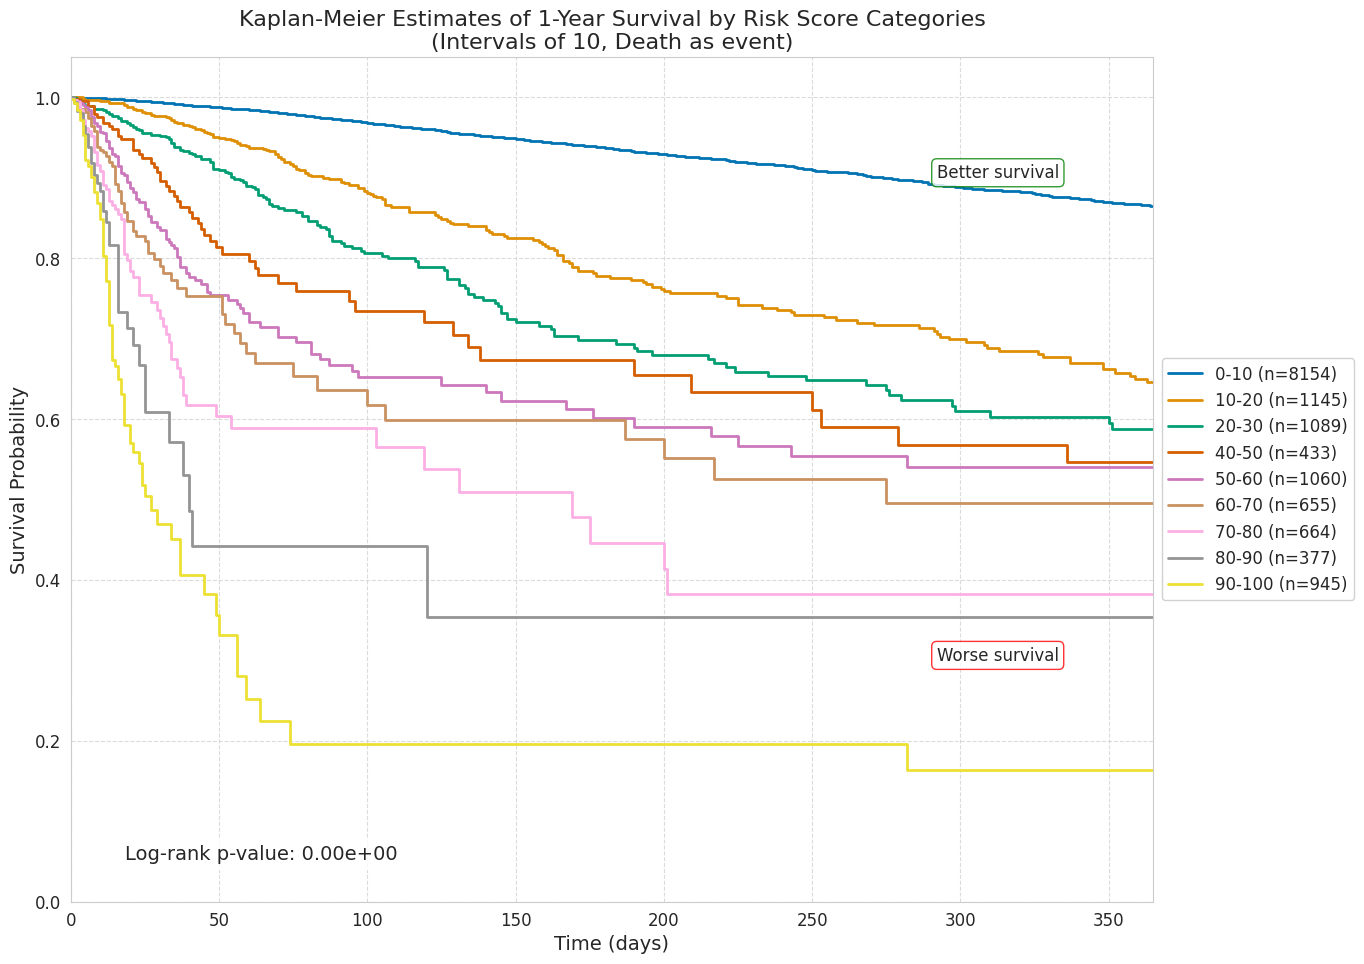

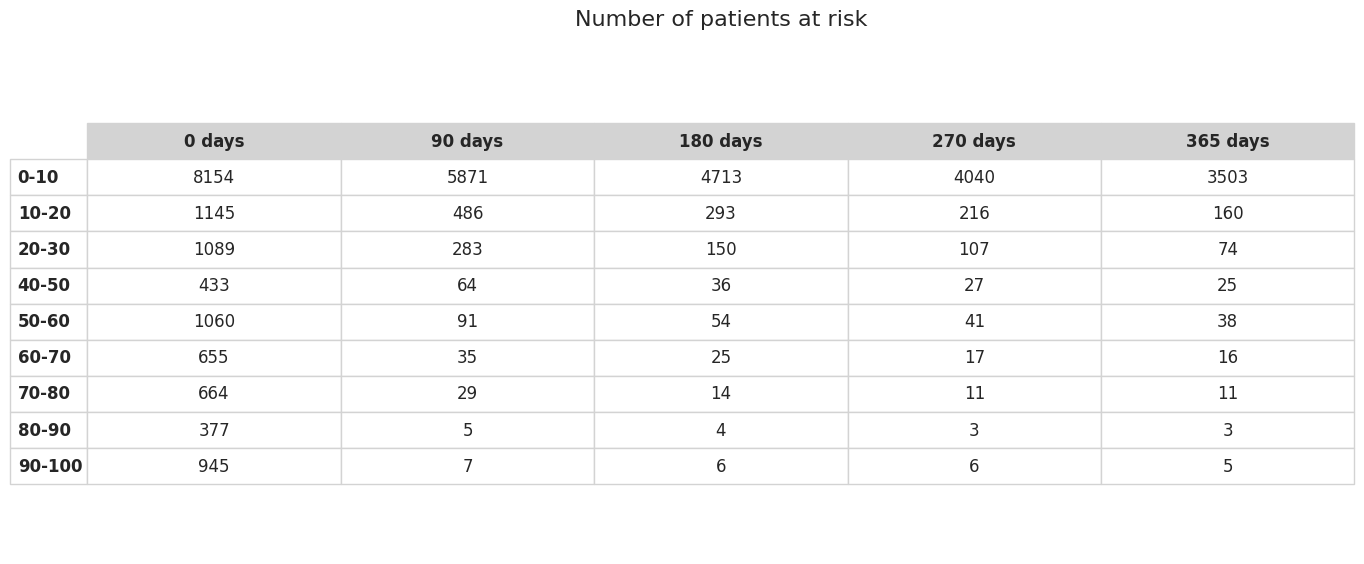


Survival Rates by Risk Score Category:
       90 days 180 days 365 days
0-10     97.3%    93.7%    86.5%
10-20    89.8%    77.8%    64.6%
20-30    82.2%    69.8%    58.8%
40-50    75.9%    67.4%    54.6%
50-60    66.7%    60.1%    54.0%
60-70    63.7%    59.9%    49.5%
70-80    58.9%    44.6%    38.2%
80-90    44.2%    35.4%    35.4%
90-100   19.6%    19.6%    16.3%

Outcomes by Risk Score Category (within 365 days):
outcome_365          Death  Waiting  Transplant  Total  Death %
risk_score_category                                            
0-10                   704     3500        3950   8154      8.6
10-20                  166      159         820   1145     14.5
20-30                  150       74         865   1089     13.8
30-40                    0        0           0      0      NaN
40-50                   55       25         353    433     12.7
50-60                  125       38         897   1060     11.8
60-70                   73       16         566    655     11.1
70

<ipython-input-100-95c82be7b636>:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = outcome_df.groupby(['risk_score_category', 'outcome_365']).size().unstack(fill_value=0)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns

# Assuming df is your dataframe
# For survival analysis with death as the event:
# - Event of interest: death (outcome = 0)
# - Censoring: transplant (outcome = 2) and waiting (outcome = 1)

# Create binary event indicator where 1 = death, 0 = censored (transplant or waiting)
df['death_event'] = (df['outcome'] == 0).astype(int)

# Create risk score categories by intervals of 10
# First, determine the range of the risk score
min_score = np.floor(df['risk_score_k300_t90'].min() / 10) * 10
max_score = np.ceil(df['risk_score_k300_t90'].max() / 10) * 10

# Create bins with width of 10
bins = np.arange(min_score, max_score + 10, 10)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

# Categorize the risk scores
df['risk_score_category'] = pd.cut(df['risk_score_k300_t90'], bins=bins, labels=bin_labels, right=False)

# Count patients in each category to decide which to plot
category_counts = df['risk_score_category'].value_counts().sort_index()
print("Number of patients in each risk score category:")
print(category_counts)

# Filter categories with too few patients (optional)
min_patients = 5  # Minimum number of patients to include a category
valid_categories = category_counts[category_counts >= min_patients].index.tolist()
print(f"\nUsing {len(valid_categories)} categories with at least {min_patients} patients")

# Limit follow-up time to 365 days for all patients
df['tte_365'] = np.minimum(df['tte'], 365)
# If original tte > 365, then the event is censored
df['death_event_365'] = np.where(df['tte'] > 365, 0, df['death_event'])

# Create two separate figures instead of squishing them together
# Figure 1: Survival curves
plt.figure(figsize=(14, 10))
ax = plt.gca()

# Generate colors
colors = sns.color_palette("colorblind", len(valid_categories))

# Setup for at-risk table
at_risk_times = [0, 90, 180, 270, 365]  # Time points for at-risk table
at_risk_data = {category: [] for category in valid_categories}

# Fit and plot KM curves for each category
kmf = KaplanMeierFitter()
median_survival = {}

for i, category in enumerate(valid_categories):
    # Subset data for this category
    mask = df['risk_score_category'] == category
    subset_df = df[mask]

    # Skip categories with too few patients (if we missed any)
    if len(subset_df) < min_patients:
        continue

    # Fit KM curve
    kmf.fit(subset_df['tte_365'],
            subset_df['death_event_365'],
            label=f"{category} (n={len(subset_df)})")

    # Plot with consistent color and line style - NO confidence intervals
    kmf.plot(ax=ax, ci_show=False, color=colors[i], linewidth=2)

    # Store median survival if available
    if kmf.median_survival_time_ is not None:
        median_survival[category] = kmf.median_survival_time_
    else:
        median_survival[category] = "Not reached"

    # Calculate number at risk for each time point
    for t in at_risk_times:
        # Count subjects with tte >= t
        n_at_risk = sum(subset_df['tte_365'] >= t)
        at_risk_data[category].append(n_at_risk)

# Customize plot
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.title('Kaplan-Meier Estimates of 1-Year Survival by Risk Score Categories\n(Intervals of 10, Death as event)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)  # Set y-axis limits
plt.xlim(0, 365)   # Set x-axis limit to 365 days
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Perform log-rank test across all groups
print("\nLog-rank test across all risk score categories (365-day follow-up):")
from lifelines.statistics import multivariate_logrank_test
# Filter to only include valid categories
valid_mask = df['risk_score_category'].isin(valid_categories)
results = multivariate_logrank_test(
    df.loc[valid_mask, 'tte_365'],
    df.loc[valid_mask, 'risk_score_category'],
    df.loc[valid_mask, 'death_event_365']
)
print(results.summary)

# Add p-value from log-rank test to the plot
plt.text(0.05, 0.05, f"Log-rank p-value: {results.p_value:.2e}",
        transform=ax.transAxes, fontsize=14,
        bbox=dict(facecolor='white', alpha=0.8))

# Enhance legend - place it outside the plot to avoid overcrowding
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, framealpha=0.9, fontsize=12)

# Add annotations for better interpretability
plt.annotate("Better survival", xy=(365*0.8, 0.9), fontsize=12,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
plt.annotate("Worse survival", xy=(365*0.8, 0.3), fontsize=12,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

# Adjust layout and save the survival curves
plt.tight_layout(pad=2.0)  # More padding to avoid squishing
plt.savefig('one_year_survival_by_risk_score_intervals_no_ci.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: At-risk table as a separate figure
plt.figure(figsize=(14, 6))
ax_table = plt.gca()
ax_table.axis('off')  # Hide axes

# Prepare table data
table_data = [at_risk_data[category] for category in valid_categories]
rows = valid_categories
columns = [f"{t} days" for t in at_risk_times]

# Add the table
table = ax_table.table(
    cellText=table_data,
    rowLabels=rows,
    colLabels=columns,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Larger font size
table.scale(1, 2.0)  # Make rows taller for better readability
for key, cell in table.get_celld().items():
    cell.set_edgecolor('lightgrey')
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgrey')
    # Make the row labels bold
    if key[1] == -1:
        cell.set_text_props(weight='bold')

# Add a title to the table
plt.title('Number of patients at risk', fontsize=16, pad=20)

# Save the at-risk table
plt.tight_layout(pad=2.0)
plt.savefig('at_risk_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate 3-month, 6-month, and 1-year survival rates by category
print("\nSurvival Rates by Risk Score Category:")
time_points = [90, 180, 365]  # 3 months, 6 months, 1 year
survival_rates = pd.DataFrame(index=valid_categories,
                             columns=[f"{t} days" for t in time_points])

for category in valid_categories:
    mask = df['risk_score_category'] == category
    if sum(mask) >= min_patients:
        kmf = KaplanMeierFitter()
        kmf.fit(df[mask]['tte_365'], df[mask]['death_event_365'])

        # Get survival at specific time points
        for t in time_points:
            try:
                surv_t = kmf.predict(t)
                survival_rates.loc[category, f"{t} days"] = f"{surv_t*100:.1f}%"
            except:
                survival_rates.loc[category, f"{t} days"] = "Not available"

print(survival_rates)

# Count number of deaths, transplants, and waitlist in each category within 365 days
print("\nOutcomes by Risk Score Category (within 365 days):")
# Create a temporary outcome variable for 365-day limited follow-up
df['outcome_365'] = np.where(
    df['tte'] > 365,
    1,  # If followed beyond 365 days, mark as "still waiting" (censored)
    df['outcome']  # Otherwise keep original outcome
)

# Filter to valid categories
outcome_df = df[df['risk_score_category'].isin(valid_categories)]

outcome_counts = outcome_df.groupby(['risk_score_category', 'outcome_365']).size().unstack(fill_value=0)
if 0 in outcome_counts.columns:
    outcome_counts.rename(columns={0: 'Death'}, inplace=True)
if 1 in outcome_counts.columns:
    outcome_counts.rename(columns={1: 'Waiting'}, inplace=True)
if 2 in outcome_counts.columns:
    outcome_counts.rename(columns={2: 'Transplant'}, inplace=True)

# Calculate percentages
outcome_counts['Total'] = outcome_counts.sum(axis=1)
if 'Death' in outcome_counts.columns:
    outcome_counts['Death %'] = (outcome_counts['Death'] / outcome_counts['Total'] * 100).round(1)
print(outcome_counts)

Number of patients in each risk score category:
risk_score_category
0-10      8154
10-20     1145
20-30     1089
30-40        1
40-50      433
50-60     1060
60-70      655
70-80      664
80-90      377
90-100     945
Name: count, dtype: int64

Using 9 categories with at least 5 patients

Log-rank test across all risk score categories (90-day follow-up):
   test_statistic    p  -log2(p)
0     2808.776504  0.0       inf


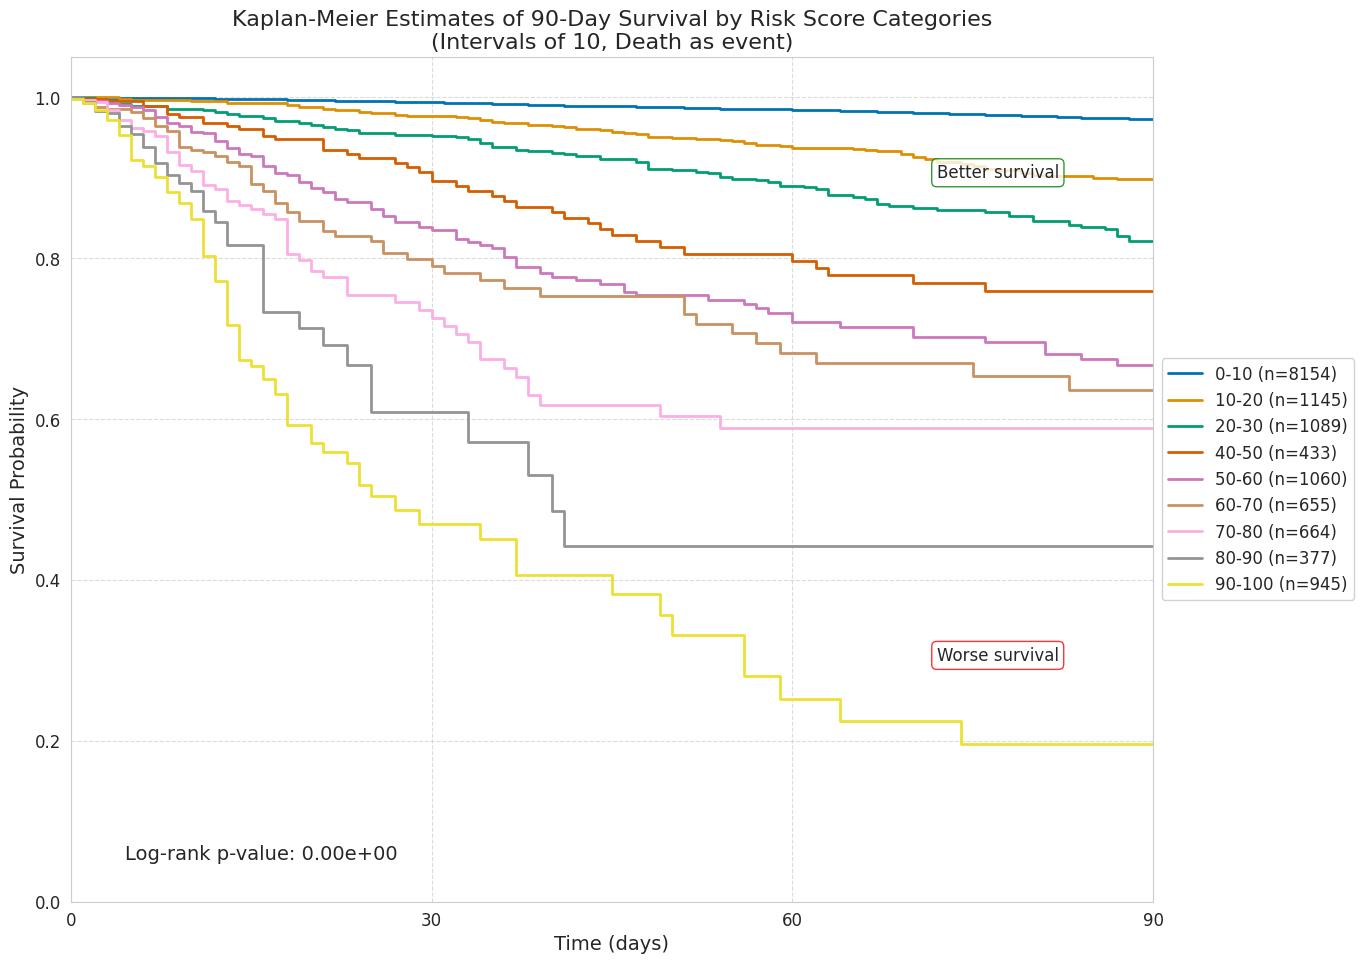

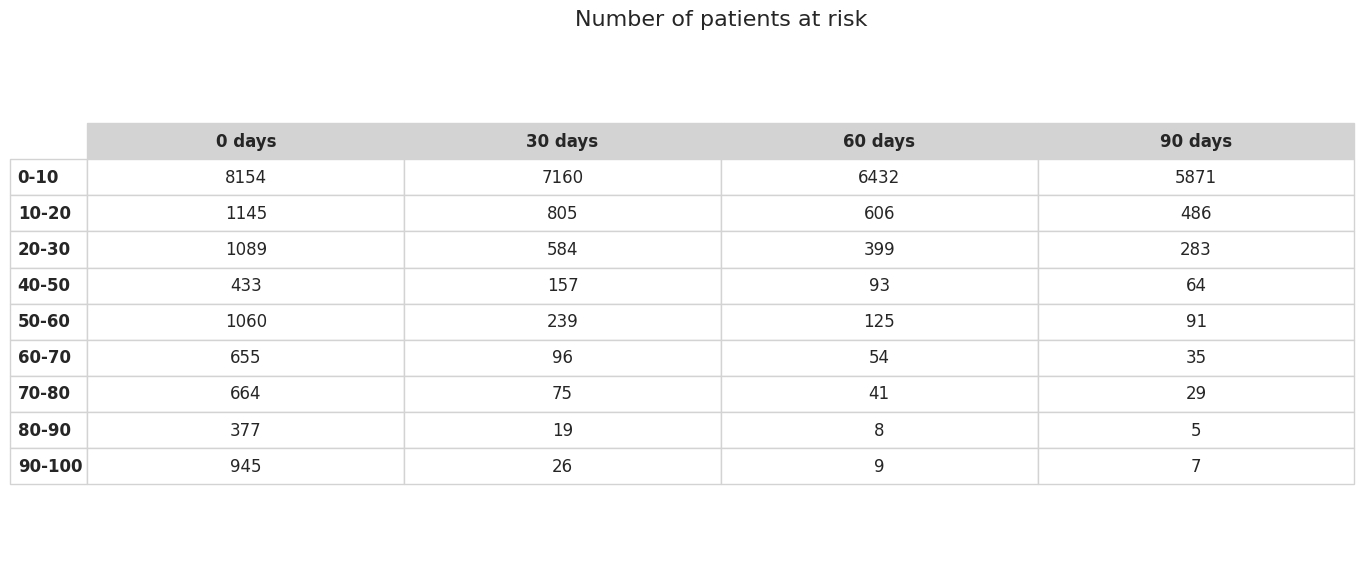


Survival Rates by Risk Score Category:
       30 days 60 days 90 days
0-10     99.4%   98.5%   97.3%
10-20    97.6%   93.7%   89.8%
20-30    95.2%   89.0%   82.2%
40-50    89.6%   79.7%   75.9%
50-60    83.5%   72.1%   66.7%
60-70    79.0%   68.2%   63.7%
70-80    72.6%   58.9%   58.9%
80-90    60.9%   44.2%   44.2%
90-100   46.9%   25.2%   19.6%

Outcomes by Risk Score Category (within 90 days):
outcome_90           Death  Waiting  Transplant  Total  Death %
risk_score_category                                            
0-10                   183     5854        2117   8154      2.2
10-20                   73      486         586   1145      6.4
20-30                   98      280         711   1089      9.0
30-40                    0        0           0      0      NaN
40-50                   43       63         327    433      9.9
50-60                  113       89         858   1060     10.7
60-70                   67       35         553    655     10.2
70-80                  

<ipython-input-101-1da79d7b0297>:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = outcome_df.groupby(['risk_score_category', 'outcome_90']).size().unstack(fill_value=0)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns

# Assuming df is your dataframe
# For survival analysis with death as the event:
# - Event of interest: death (outcome = 0)
# - Censoring: transplant (outcome = 2) and waiting (outcome = 1)

# Create binary event indicator where 1 = death, 0 = censored (transplant or waiting)
df['death_event'] = (df['outcome'] == 0).astype(int)

# Create risk score categories by intervals of 10
# First, determine the range of the risk score
min_score = np.floor(df['risk_score_k300_t90'].min() / 10) * 10
max_score = np.ceil(df['risk_score_k300_t90'].max() / 10) * 10

# Create bins with width of 10
bins = np.arange(min_score, max_score + 10, 10)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

# Categorize the risk scores
df['risk_score_category'] = pd.cut(df['risk_score_k300_t90'], bins=bins, labels=bin_labels, right=False)

# Count patients in each category to decide which to plot
category_counts = df['risk_score_category'].value_counts().sort_index()
print("Number of patients in each risk score category:")
print(category_counts)

# Filter categories with too few patients (optional)
min_patients = 5  # Minimum number of patients to include a category
valid_categories = category_counts[category_counts >= min_patients].index.tolist()
print(f"\nUsing {len(valid_categories)} categories with at least {min_patients} patients")

# Limit follow-up time to 90 days for all patients
df['tte_90'] = np.minimum(df['tte'], 90)
# If original tte > 90, then the event is censored
df['death_event_90'] = np.where(df['tte'] > 90, 0, df['death_event'])

# Create two separate figures instead of squishing them together
# Figure 1: Survival curves
plt.figure(figsize=(14, 10))
ax = plt.gca()

# Generate colors
colors = sns.color_palette("colorblind", len(valid_categories))

# Setup for at-risk table
at_risk_times = [0, 30, 60, 90]  # Time points for at-risk table
at_risk_data = {category: [] for category in valid_categories}

# Fit and plot KM curves for each category
kmf = KaplanMeierFitter()
median_survival = {}

for i, category in enumerate(valid_categories):
    # Subset data for this category
    mask = df['risk_score_category'] == category
    subset_df = df[mask]

    # Skip categories with too few patients (if we missed any)
    if len(subset_df) < min_patients:
        continue

    # Fit KM curve
    kmf.fit(subset_df['tte_90'],
            subset_df['death_event_90'],
            label=f"{category} (n={len(subset_df)})")

    # Plot with consistent color and line style - NO confidence intervals
    kmf.plot(ax=ax, ci_show=False, color=colors[i], linewidth=2)

    # Store median survival if available
    if kmf.median_survival_time_ is not None:
        median_survival[category] = kmf.median_survival_time_
    else:
        median_survival[category] = "Not reached"

    # Calculate number at risk for each time point
    for t in at_risk_times:
        # Count subjects with tte >= t
        n_at_risk = sum(subset_df['tte_90'] >= t)
        at_risk_data[category].append(n_at_risk)

# Customize plot
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.title('Kaplan-Meier Estimates of 90-Day Survival by Risk Score Categories\n(Intervals of 10, Death as event)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)  # Set y-axis limits
plt.xlim(0, 90)    # Set x-axis limit to 90 days
plt.xticks(at_risk_times, fontsize=12)
plt.yticks(fontsize=12)

# Perform log-rank test across all groups
print("\nLog-rank test across all risk score categories (90-day follow-up):")
from lifelines.statistics import multivariate_logrank_test
# Filter to only include valid categories
valid_mask = df['risk_score_category'].isin(valid_categories)
results = multivariate_logrank_test(
    df.loc[valid_mask, 'tte_90'],
    df.loc[valid_mask, 'risk_score_category'],
    df.loc[valid_mask, 'death_event_90']
)
print(results.summary)

# Add p-value from log-rank test to the plot
plt.text(0.05, 0.05, f"Log-rank p-value: {results.p_value:.2e}",
        transform=ax.transAxes, fontsize=14,
        bbox=dict(facecolor='white', alpha=0.8))

# Enhance legend - place it outside the plot to avoid overcrowding
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, framealpha=0.9, fontsize=12)

# Add annotations for better interpretability
plt.annotate("Better survival", xy=(90*0.8, 0.9), fontsize=12,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
plt.annotate("Worse survival", xy=(90*0.8, 0.3), fontsize=12,
           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

# Adjust layout and save the survival curves
plt.tight_layout(pad=2.0)  # More padding to avoid squishing
plt.savefig('90_day_survival_by_risk_score_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: At-risk table as a separate figure
plt.figure(figsize=(14, 6))
ax_table = plt.gca()
ax_table.axis('off')  # Hide axes

# Prepare table data
table_data = [at_risk_data[category] for category in valid_categories]
rows = valid_categories
columns = [f"{t} days" for t in at_risk_times]

# Add the table
table = ax_table.table(
    cellText=table_data,
    rowLabels=rows,
    colLabels=columns,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Larger font size
table.scale(1, 2.0)  # Make rows taller for better readability
for key, cell in table.get_celld().items():
    cell.set_edgecolor('lightgrey')
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgrey')
    # Make the row labels bold
    if key[1] == -1:
        cell.set_text_props(weight='bold')

# Add a title to the table
plt.title('Number of patients at risk', fontsize=16, pad=20)

# Save the at-risk table
plt.tight_layout(pad=2.0)
plt.savefig('90_day_at_risk_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate 30, 60, and 90-day survival rates by category
print("\nSurvival Rates by Risk Score Category:")
time_points = [30, 60, 90]  # 30, 60, 90 days
survival_rates = pd.DataFrame(index=valid_categories,
                             columns=[f"{t} days" for t in time_points])

for category in valid_categories:
    mask = df['risk_score_category'] == category
    if sum(mask) >= min_patients:
        kmf = KaplanMeierFitter()
        kmf.fit(df[mask]['tte_90'], df[mask]['death_event_90'])

        # Get survival at specific time points
        for t in time_points:
            try:
                surv_t = kmf.predict(t)
                survival_rates.loc[category, f"{t} days"] = f"{surv_t*100:.1f}%"
            except:
                survival_rates.loc[category, f"{t} days"] = "Not available"

print(survival_rates)

# Count number of deaths, transplants, and waitlist in each category within 90 days
print("\nOutcomes by Risk Score Category (within 90 days):")
# Create a temporary outcome variable for 90-day limited follow-up
df['outcome_90'] = np.where(
    df['tte'] > 90,
    1,  # If followed beyond 90 days, mark as "still waiting" (censored)
    df['outcome']  # Otherwise keep original outcome
)

# Filter to valid categories
outcome_df = df[df['risk_score_category'].isin(valid_categories)]

outcome_counts = outcome_df.groupby(['risk_score_category', 'outcome_90']).size().unstack(fill_value=0)
if 0 in outcome_counts.columns:
    outcome_counts.rename(columns={0: 'Death'}, inplace=True)
if 1 in outcome_counts.columns:
    outcome_counts.rename(columns={1: 'Waiting'}, inplace=True)
if 2 in outcome_counts.columns:
    outcome_counts.rename(columns={2: 'Transplant'}, inplace=True)

# Calculate percentages
outcome_counts['Total'] = outcome_counts.sum(axis=1)
if 'Death' in outcome_counts.columns:
    outcome_counts['Death %'] = (outcome_counts['Death'] / outcome_counts['Total'] * 100).round(1)
print(outcome_counts)


MELD-3 ≤ 15:
Number of patients: 2868
Patients per risk score category:
risk_score_category
0-10      2866
10-20        1
20-30        0
30-40        0
40-50        1
50-60        0
60-70        0
70-80        0
80-90        0
90-100       0
Name: count, dtype: int64
Insufficient categories for log-rank test

MELD-3 16-20:
Number of patients: 3453
Patients per risk score category:
risk_score_category
0-10      3409
10-20       21
20-30       10
30-40        0
40-50        6
50-60        2
60-70        3
70-80        1
80-90        1
90-100       0
Name: count, dtype: int64
Log-rank p-value: 0.0000

MELD-3 21-25:
Number of patients: 2959
Patients per risk score category:
risk_score_category
0-10      1803
10-20      862
20-30      205
30-40        0
40-50       11
50-60       29
60-70       16
70-80       18
80-90       10
90-100       5
Name: count, dtype: int64
Log-rank p-value: 0.0000

MELD-3 26-30:
Number of patients: 2139
Patients per risk score category:
risk_score_category
0-10 

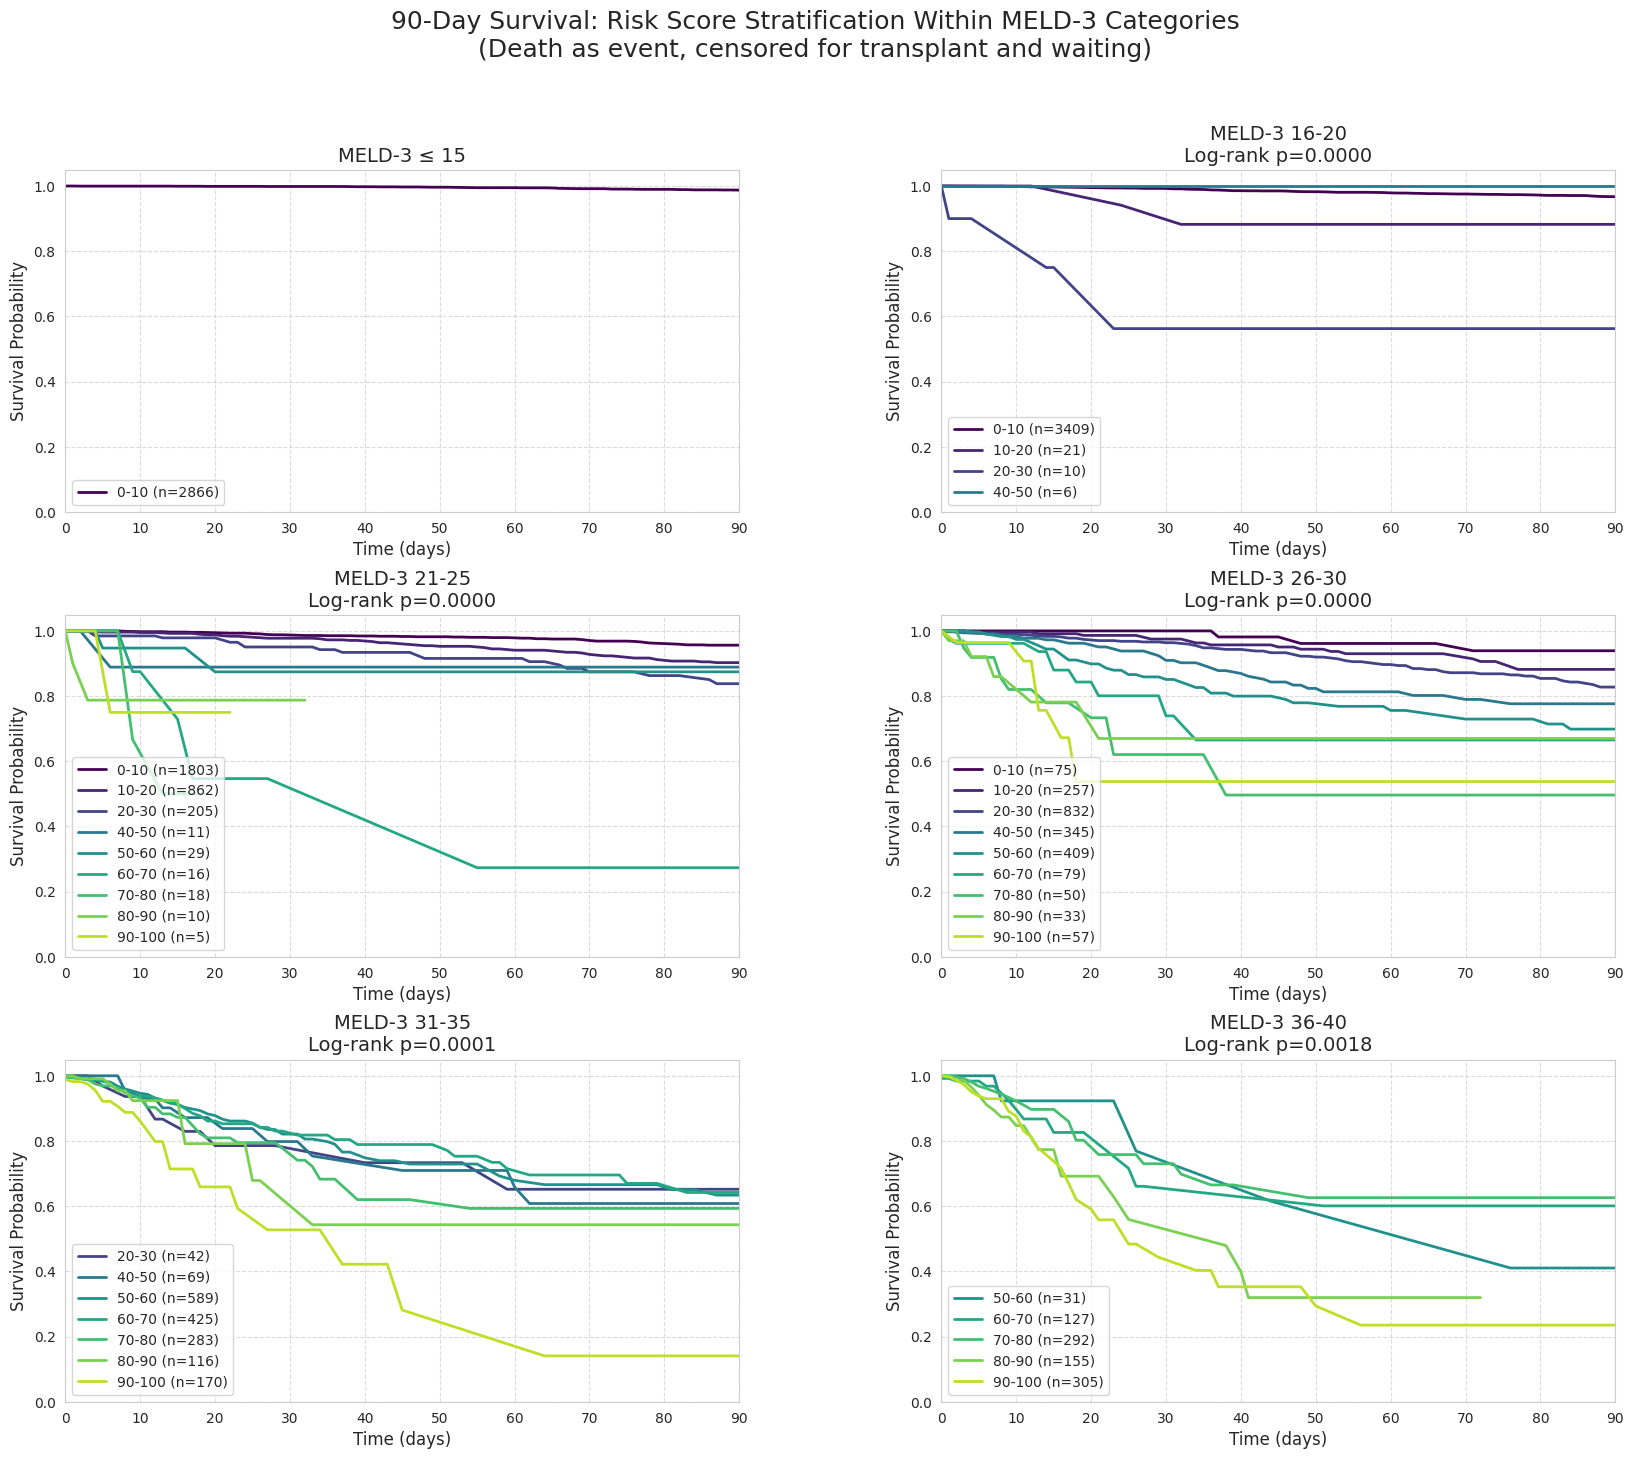


Survival rates by MELD range and Risk Score category:
      MELD Range Risk Category  Patients 90-day Survival
0    MELD-3 ≤ 15          0-10      2866           98.7%
1   MELD-3 16-20          0-10      3409           96.7%
2   MELD-3 16-20         10-20        21           88.2%
3   MELD-3 16-20         20-30        10           56.2%
4   MELD-3 16-20         40-50         6          100.0%
5   MELD-3 21-25          0-10      1803           95.6%
6   MELD-3 21-25         10-20       862           90.3%
7   MELD-3 21-25         20-30       205           83.8%
8   MELD-3 21-25         40-50        11           88.9%
9   MELD-3 21-25         50-60        29           87.4%
10  MELD-3 21-25         60-70        16           27.3%
11  MELD-3 21-25         70-80        18           50.0%
12  MELD-3 21-25         80-90        10           78.8%
13  MELD-3 21-25        90-100         5           75.0%
14  MELD-3 26-30          0-10        75           93.9%
15  MELD-3 26-30         10-20   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Assuming df is your dataframe
# For survival analysis with death as the event:
# - Event of interest: death (outcome = 0)
# - Censoring: transplant (outcome = 2) and waiting (outcome = 1)

# Create binary event indicator where 1 = death, 0 = censored (transplant or waiting)
df['death_event'] = (df['outcome'] == 0).astype(int)

# Define MELD-3 ranges to analyze
meld_ranges = [
    (0, 15, "MELD-3 ≤ 15"),
    (16, 20, "MELD-3 16-20"),
    (21, 25, "MELD-3 21-25"),
    (26, 30, "MELD-3 26-30"),
    (31, 35, "MELD-3 31-35"),
    (36, 40, "MELD-3 36-40")
]

# Create risk score categories by intervals of 10
# First, determine the range of the risk score for the entire dataset
min_score = np.floor(df['risk_score_k300_t90'].min() / 10) * 10
max_score = np.ceil(df['risk_score_k300_t90'].max() / 10) * 10
bins = np.arange(min_score, max_score + 10, 10)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

# Categorize all patients by risk score
df['risk_score_category'] = pd.cut(df['risk_score_k300_t90'], bins=bins, labels=bin_labels, right=False)

# Limit follow-up time to 90 days for all patients
df['tte_90'] = np.minimum(df['tte'], 90)
# If original tte > 90, then the event is censored
df['death_event_90'] = np.where(df['tte'] > 90, 0, df['death_event'])

# Set up the multi-panel figure
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(3, 2, figure=fig)  # 3 rows, 2 columns

# Storage for legend handles and labels
all_handles = []
all_labels = []

# Storage for survival rates and log-rank p-values
survival_stats = []

# Generate colors - reuse the same colors across panels
colormap = plt.cm.viridis
all_categories = sorted(bin_labels)
color_dict = {cat: colormap(i/len(all_categories)) for i, cat in enumerate(all_categories)}

# Create a panel for each MELD-3 range
for i, (lower, upper, title) in enumerate(meld_ranges):
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])

    # Filter patients in this MELD-3 range
    if lower == 0:
        mask = df['meld3'] <= upper
    else:
        mask = (df['meld3'] >= lower) & (df['meld3'] <= upper)

    meld_subset = df[mask].copy()

    print(f"\n{title}:")
    print(f"Number of patients: {len(meld_subset)}")

    # Check if there are patients in this MELD range
    if len(meld_subset) == 0:
        ax.text(0.5, 0.5, f"No patients in {title}",
                ha='center', va='center', fontsize=14,
                transform=ax.transAxes)
        ax.set_title(title, fontsize=14)
        continue

    # Count patients in each risk score category
    category_counts = meld_subset['risk_score_category'].value_counts().sort_index()
    print(f"Patients per risk score category:")
    print(category_counts)

    # Filter categories with too few patients
    min_patients = 5  # Minimum patients per category
    valid_categories = category_counts[category_counts >= min_patients].index.tolist()

    # Check if there are valid categories with enough patients
    if not valid_categories:
        ax.text(0.5, 0.5, f"No risk categories with ≥{min_patients} patients",
                ha='center', va='center', fontsize=14,
                transform=ax.transAxes)
        ax.set_title(title, fontsize=14)
        continue

    # Plot KM curves for each valid risk score category
    kmf = KaplanMeierFitter()
    panel_handles = []
    panel_labels = []

    for category in valid_categories:
        cat_mask = meld_subset['risk_score_category'] == category
        subset_df = meld_subset[cat_mask]

        # Fit KM curve
        kmf.fit(subset_df['tte_90'],
                subset_df['death_event_90'],
                label=f"{category} (n={len(subset_df)})")

        # Plot with consistent color
        # Use a separate line to create and store the line handle properly
        line, = ax.plot(kmf.timeline, kmf.survival_function_.values.flatten(),
                       label=f"{category} (n={len(subset_df)})",
                       color=color_dict[category], linewidth=2)

        panel_handles.append(line)
        panel_labels.append(f"{category} (n={len(subset_df)})")

        # Calculate 90-day survival rate
        try:
            surv_90 = kmf.predict(90)
            survival_stats.append({
                'MELD Range': title,
                'Risk Category': category,
                'Patients': len(subset_df),
                '90-day Survival': f"{surv_90*100:.1f}%"
            })
        except:
            survival_stats.append({
                'MELD Range': title,
                'Risk Category': category,
                'Patients': len(subset_df),
                '90-day Survival': "N/A"
            })

    # Perform log-rank test if there are multiple valid categories
    if len(valid_categories) > 1:
        valid_mask = meld_subset['risk_score_category'].isin(valid_categories)
        lr_results = multivariate_logrank_test(
            meld_subset.loc[valid_mask, 'tte_90'],
            meld_subset.loc[valid_mask, 'risk_score_category'],
            meld_subset.loc[valid_mask, 'death_event_90']
        )
        p_value = lr_results.p_value
        print(f"Log-rank p-value: {p_value:.4f}")
    else:
        p_value = None
        print("Insufficient categories for log-rank test")

    # Create a legend for this panel
    ax.legend(panel_handles, panel_labels, loc='lower left', fontsize=10)

    # Customize panel
    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f"{title}", fontsize=14)
    if p_value is not None:
        ax.set_title(f"{title}\nLog-rank p={p_value:.4f}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 90)  # Limit x-axis to 90 days

    # Save the first panel's handles for shared legend if needed
    if not all_handles and panel_handles:
        all_handles.extend(panel_handles)
        all_labels.extend(panel_labels)

# Adjust layout and add overall title
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('90-Day Survival: Risk Score Stratification Within MELD-3 Categories\n(Death as event, censored for transplant and waiting)',
            fontsize=18, y=0.98)

# Save the figure
plt.savefig('90day_survival_stratification_by_meld3_ranges.png', dpi=300, bbox_inches='tight')
plt.show()

# Convert survival stats to DataFrame
if survival_stats:
    survival_df = pd.DataFrame(survival_stats)
    print("\nSurvival rates by MELD range and Risk Score category:")
    print(survival_df)

    # Also create a cross-tabulation
    survival_pivot = survival_df.pivot(index='MELD Range', columns='Risk Category', values='90-day Survival')
    print("\n90-day Survival Rate (%) by MELD Range and Risk Score Category:")
    print(survival_pivot)
else:
    print("\nNo survival statistics available - check if data is properly categorized.")

# Calculate statistics for each subgroup
print("\nPatient counts and outcomes by MELD Range and Risk Score Category:")
stats_list = []

for lower, upper, title in meld_ranges:
    if lower == 0:
        mask = df['meld3'] <= upper
    else:
        mask = (df['meld3'] >= lower) & (df['meld3'] <= upper)

    meld_subset = df[mask].copy()

    # Check if the subset is empty
    if len(meld_subset) == 0:
        continue

    # Handle case where risk_score_category might have NaN values
    valid_categories = meld_subset['risk_score_category'].dropna().unique()

    for category in valid_categories:
        cat_mask = meld_subset['risk_score_category'] == category
        if cat_mask.sum() < 5:  # Skip categories with very few patients
            continue

        subset = meld_subset[cat_mask]
        deaths = (subset['outcome'] == 0).sum()
        transplants = (subset['outcome'] == 2).sum() if 2 in subset['outcome'].values else 0
        waiting = (subset['outcome'] == 1).sum() if 1 in subset['outcome'].values else 0
        total = len(subset)

        stats_list.append({
            'MELD Range': title,
            'Risk Category': category,
            'Patients': total,
            'Deaths': deaths,
            'Death %': f"{deaths/total*100:.1f}%",
            'Transplants': transplants,
            'Waiting': waiting,
            'Mean MELD-3': subset['meld3'].mean().round(1),
            'Mean Risk Score': subset['risk_score_k300_t90'].mean().round(1)
        })

if stats_list:
    stats_df = pd.DataFrame(stats_list)
    print(stats_df)
else:
    print("No statistics available - check if data is properly categorized.")

Comparing risk_score_k300_t90 vs meld3 across MELD3 strata
Time horizon: 90 days
Number of bootstrap samples: 500

Analyzing MELD-3 ≤ 15...
  Patients: 2868, Events: 33 (1.2%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.6350 (95% CI: 0.5649-0.7000)
  meld3 c-index: 0.6092 (95% CI: 0.4997-0.6993)
  Difference: 0.0258 (95% CI: -0.0655-0.1257)
  p-value: 0.5520

Analyzing MELD-3 16-20...
  Patients: 3453, Events: 99 (2.9%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.6661 (95% CI: 0.6068-0.7255)
  meld3 c-index: 0.5270 (95% CI: 0.4642-0.5886)
  Difference: 0.1391 (95% CI: 0.0806-0.1962)
  p-value: 0.0000

Analyzing MELD-3 21-25...
  Patients: 2959, Events: 139 (4.7%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.6970 (95% CI: 0.6495-0.7389)
  meld3 c-index: 0.5953 (95% CI: 0.5474-0.6395)
  Difference: 0.1016 (95% CI: 0.0590-0.1433)
  p-value: 0.0000

Analyzing MELD-3 26-30...
  Patients: 2139, Events: 195 (9.1%)

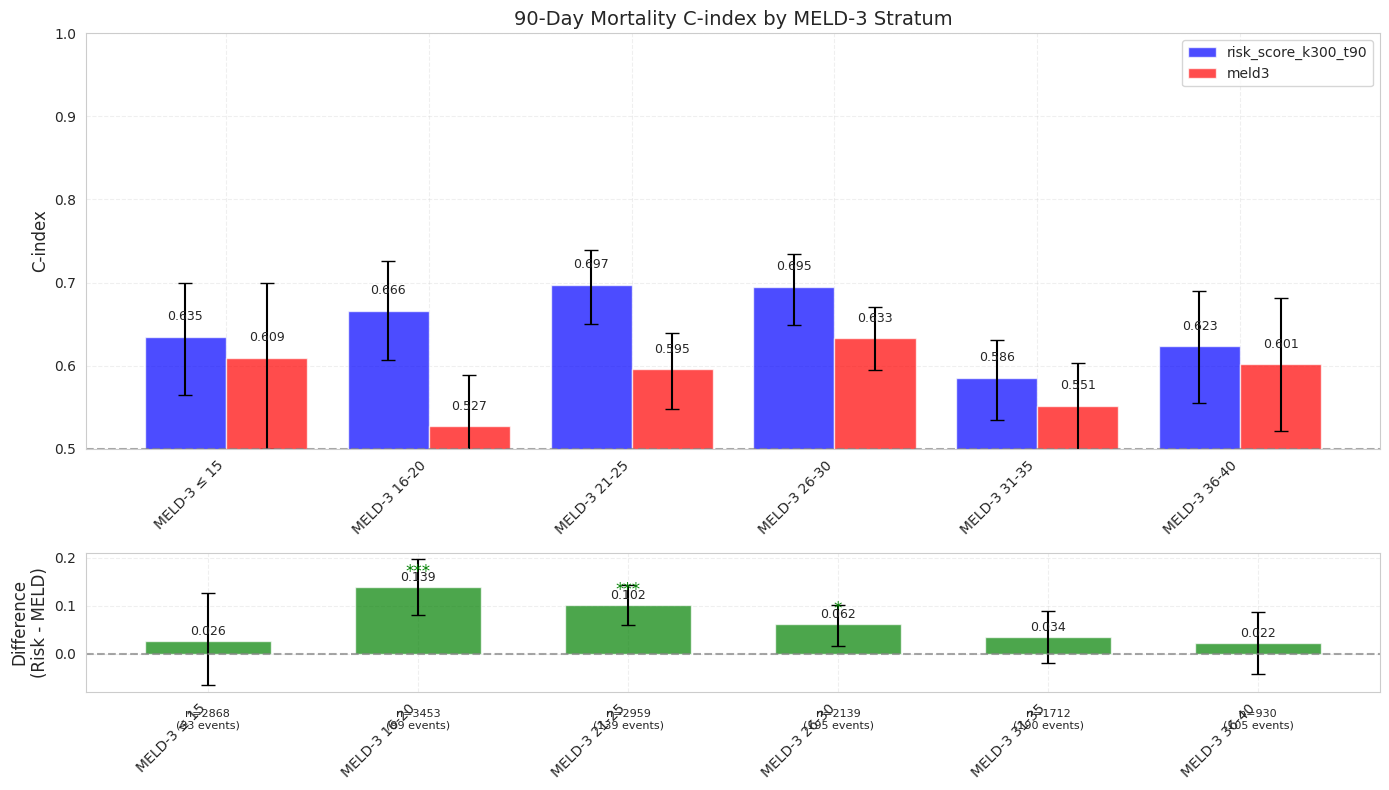

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def stratified_cindex_comparison(df,
                               risk_col="risk_score_k300_t90",
                               meld_col="meld3",
                               outcome_col="outcome",
                               tte_col="tte",
                               horizon=90,
                               strata_ranges=[(0, 15), (16, 20), (21, 25),
                                             (26, 30), (31, 35), (36, 40)],
                               n_bootstraps=500,
                               random_state=42):
    """
    Compute and compare c-indices for risk score and MELD3 within different
    MELD3 strata, focusing on a specific horizon (e.g., 90-day mortality).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizon: Time horizon in days (default: 90 days)
        strata_ranges: List of tuples defining MELD3 strata ranges
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility

    Returns:
        DataFrame with c-index results for each stratum
    """
    np.random.seed(random_state)
    results = []

    # Create labels for the strata
    strata_labels = []
    for lower, upper in strata_ranges:
        if lower == 0:
            strata_labels.append(f"MELD-3 ≤ {upper}")
        else:
            strata_labels.append(f"MELD-3 {lower}-{upper}")

    # Analyze each stratum
    for i, (lower, upper) in enumerate(strata_ranges):
        stratum_label = strata_labels[i]
        print(f"\nAnalyzing {stratum_label}...")

        # Filter patients in this MELD-3 range
        if lower == 0:
            stratum_mask = df[meld_col] <= upper
        else:
            stratum_mask = (df[meld_col] >= lower) & (df[meld_col] <= upper)

        stratum_df = df[stratum_mask].copy()

        if len(stratum_df) == 0:
            print(f"  No patients in {stratum_label}")
            results.append({
                'stratum': stratum_label,
                'n_patients': 0,
                'n_events': 0,
                'event_rate': 0,
                f'c_{risk_col}': np.nan,
                f'c_{meld_col}': np.nan,
                'difference': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan
            })
            continue

        # Prepare data for 90-day analysis
        stratum_df['event_t'] = ((stratum_df[outcome_col] == 0) &
                                 (stratum_df[tte_col] <= horizon)).astype(int)
        stratum_df['time_t'] = np.minimum(stratum_df[tte_col], horizon)

        # Drop rows with missing data
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        clean_df = stratum_df[needed_cols].dropna()

        if len(clean_df) == 0 or clean_df['event_t'].sum() == 0:
            print(f"  Insufficient data in {stratum_label} after cleaning")
            results.append({
                'stratum': stratum_label,
                'n_patients': len(stratum_df),
                'n_events': 0,
                'event_rate': 0,
                f'c_{risk_col}': np.nan,
                f'c_{meld_col}': np.nan,
                'difference': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan
            })
            continue

        # Count patients and events
        n_patients = len(clean_df)
        n_events = clean_df['event_t'].sum()
        event_rate = n_events / n_patients

        print(f"  Patients: {n_patients}, Events: {n_events} ({event_rate*100:.1f}%)")

        # Calculate c-indices on full data
        # Note: Using positive values because higher risk/MELD = worse outcome
        c_risk = concordance_index(
            clean_df['time_t'],
            -clean_df[risk_col],  # Higher is worse
            clean_df['event_t']
        )

        c_meld = concordance_index(
            clean_df['time_t'],
            -clean_df[meld_col],  # Higher is worse
            clean_df['event_t']
        )

        orig_diff = c_risk - c_meld

        # Bootstrap to get confidence intervals
        print(f"  Running {n_bootstraps} bootstrap iterations...")

        # Arrays to store bootstrap results
        c_risk_boot = []
        c_meld_boot = []

        for _ in range(n_bootstraps):
            # Sample with replacement
            boot_idx = np.random.randint(0, n_patients, size=n_patients)
            boot_df = clean_df.iloc[boot_idx]

            # Skip iterations with no events or all events
            if boot_df['event_t'].sum() == 0 or boot_df['event_t'].sum() == len(boot_df):
                continue

            # Calculate c-indices for this bootstrap sample
            c_risk_b = concordance_index(
                boot_df['time_t'],
                -boot_df[risk_col],
                boot_df['event_t']
            )

            c_meld_b = concordance_index(
                boot_df['time_t'],
                -boot_df[meld_col],
                boot_df['event_t']
            )

            c_risk_boot.append(c_risk_b)
            c_meld_boot.append(c_meld_b)

        c_risk_boot = np.array(c_risk_boot)
        c_meld_boot = np.array(c_meld_boot)
        diff_boot = c_risk_boot - c_meld_boot

        # Calculate confidence intervals
        ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
        ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
        ci_diff = np.percentile(diff_boot, [2.5, 97.5])

        # Calculate p-value
        if orig_diff >= 0:
            p_one_sided = np.mean(diff_boot < 0)
        else:
            p_one_sided = np.mean(diff_boot > 0)
        p_value = min(2 * p_one_sided, 1.0)

        print(f"  {risk_col} c-index: {c_risk:.4f} (95% CI: {ci_risk[0]:.4f}-{ci_risk[1]:.4f})")
        print(f"  {meld_col} c-index: {c_meld:.4f} (95% CI: {ci_meld[0]:.4f}-{ci_meld[1]:.4f})")
        print(f"  Difference: {orig_diff:.4f} (95% CI: {ci_diff[0]:.4f}-{ci_diff[1]:.4f})")
        print(f"  p-value: {p_value:.4f}")

        # Store results
        results.append({
            'stratum': stratum_label,
            'n_patients': n_patients,
            'n_events': n_events,
            'event_rate': event_rate,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': orig_diff,
            'ci_risk_lower': ci_risk[0],
            'ci_risk_upper': ci_risk[1],
            'ci_meld_lower': ci_meld[0],
            'ci_meld_upper': ci_meld[1],
            'ci_diff_lower': ci_diff[0],
            'ci_diff_upper': ci_diff[1],
            'p_value': p_value
        })

    return pd.DataFrame(results)


def create_stratified_cindex_table(results, risk_col="risk_score_k300_t90", meld_col="meld3"):
    """
    Create a formatted table of c-index results by MELD3 stratum.

    Args:
        results: DataFrame from stratified_cindex_comparison
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    table_data = []

    for _, row in results.iterrows():
        if pd.isna(row[f'c_{risk_col}']) or pd.isna(row[f'c_{meld_col}']):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[f'c_{risk_col}']:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[f'c_{meld_col}']:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['difference']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        event_rate = f"{row['event_rate']*100:.1f}%" if row['n_patients'] > 0 else "N/A"

        table_data.append({
            'MELD-3 Stratum': row['stratum'],
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': event_rate,
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


def plot_stratified_cindices(results, risk_col="risk_score_k300_t90", meld_col="meld3",
                           figsize=(14, 8), save_path=None):
    """
    Plot c-indices and their differences across MELD3 strata.

    Args:
        results: DataFrame from stratified_cindex_comparison
        risk_col: Name of risk column
        meld_col: Name of MELD column
        figsize: Figure size
        save_path: Path to save the figure

    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Get x positions and labels
    strata = results['stratum'].values
    x_pos = np.arange(len(strata))

    # Plot c-indices with error bars
    risk_values = results[f'c_{risk_col}'].values
    risk_errors = [
        results[f'c_{risk_col}'].values - results['ci_risk_lower'].values,
        results['ci_risk_upper'].values - results[f'c_{risk_col}'].values
    ]

    meld_values = results[f'c_{meld_col}'].values
    meld_errors = [
        results[f'c_{meld_col}'].values - results['ci_meld_lower'].values,
        results['ci_meld_upper'].values - results[f'c_{meld_col}'].values
    ]

    # Plot bars for risk score
    risk_bars = ax1.bar(x_pos - 0.2, risk_values, width=0.4, color='blue', alpha=0.7,
                      yerr=risk_errors, capsize=5, label=f'{risk_col}')

    # Plot bars for MELD score
    meld_bars = ax1.bar(x_pos + 0.2, meld_values, width=0.4, color='red', alpha=0.7,
                      yerr=meld_errors, capsize=5, label=f'{meld_col}')

    # Format the c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title(f'90-Day Mortality C-index by MELD-3 Stratum', fontsize=14)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(strata, rotation=45, ha='right')
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_ylim(0.5, 1.0)

    # Add value labels on the bars
    for i, v in enumerate(risk_values):
        if not np.isnan(v):
            ax1.text(i - 0.2, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

    for i, v in enumerate(meld_values):
        if not np.isnan(v):
            ax1.text(i + 0.2, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = results['difference'].values
    diff_errors = [
        results['difference'].values - results['ci_diff_lower'].values,
        results['ci_diff_upper'].values - results['difference'].values
    ]

    ax2.bar(x_pos, diff_values, width=0.6, color='green', alpha=0.7,
          yerr=diff_errors, capsize=5)

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(results['p_value']):
        if not np.isnan(p_value) and p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.02 if diff_values[i] >= 0 else diff_values[i] - 0.04
            ax2.text(x_pos[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Format the difference plot
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(strata, rotation=45, ha='right')
    ax2.grid(True, linestyle='--', alpha=0.3)

    # Add value labels on the difference bars
    for i, v in enumerate(diff_values):
        if not np.isnan(v):
            y_pos = v + 0.02 if v >= 0 else v - 0.04
            ax2.text(i, y_pos, f'{v:.3f}', ha='center', va='center', fontsize=9)

    # Add number of patients/events below the x-axis
    for i, row in enumerate(results.itertuples()):
        if row.n_patients > 0:
            ax2.text(i, ax2.get_ylim()[0] - 0.05,
                    f'n={row.n_patients}\n({row.n_events} events)',
                    ha='center', va='top', fontsize=8,
                    transform=ax2.get_xaxis_transform())

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def run_stratified_analysis(df, risk_col="risk_score_k300_t90", meld_col="meld3",
                         horizon=90, n_bootstraps=500):
    """
    Run a complete stratified analysis comparing risk score and MELD3 c-indices
    across different MELD3 strata.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        horizon: Time horizon in days (default: 90)
        n_bootstraps: Number of bootstrap samples

    Returns:
        Dictionary with results, table, and plot
    """
    # Define MELD3 strata
    strata_ranges = [(0, 15), (16, 20), (21, 25), (26, 30), (31, 35), (36, 40)]

    print(f"Comparing {risk_col} vs {meld_col} across MELD3 strata")
    print(f"Time horizon: {horizon} days")
    print(f"Number of bootstrap samples: {n_bootstraps}")

    # Run the stratified analysis
    results = stratified_cindex_comparison(
        df=df,
        risk_col=risk_col,
        meld_col=meld_col,
        horizon=horizon,
        strata_ranges=strata_ranges,
        n_bootstraps=n_bootstraps
    )

    # Create formatted table
    table = create_stratified_cindex_table(results, risk_col=risk_col, meld_col=meld_col)

    # Create plot
    plot = plot_stratified_cindices(
        results,
        risk_col=risk_col,
        meld_col=meld_col,
        save_path=f"stratified_cindex_{risk_col}_vs_{meld_col}_{horizon}days.png"
    )

    # Save results to CSV
    results.to_csv(f"stratified_cindex_results_{horizon}days.csv", index=False)
    table.to_csv(f"stratified_cindex_table_{horizon}days.csv", index=False)

    print("\nStratified 90-day C-index Results Summary:")
    print(table)

    return {
        'results': results,
        'table': table,
        'plot': plot
    }


# Example usage
if __name__ == "__main__":
    # Run the stratified analysis with your dataframe
    results = run_stratified_analysis(
        df=df,  # Your dataframe should be defined elsewhere
        risk_col="risk_score_k300_t90",
        meld_col="meld3",
        horizon=90,
        n_bootstraps=500
    )

Comparing risk_score_k300_t90 vs meld3 across subgroups
Time horizon: 90 days
Minimum patients per subgroup: 20
Number of bootstrap samples: 500

======= ANALYSIS BY Etiology =======

Analyzing Etiology: Alcohol...
  Patients: 6401, Events: 348 (5.4%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8579 (95% CI: 0.8409-0.8761)
  meld3 c-index: 0.8339 (95% CI: 0.8128-0.8534)
  Difference: 0.0240 (95% CI: 0.0139-0.0340)
  p-value: 0.0000

Analyzing Etiology: Autoimmune...
  Patients: 589, Events: 41 (7.0%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8649 (95% CI: 0.8068-0.9208)
  meld3 c-index: 0.8694 (95% CI: 0.8133-0.9243)
  Difference: -0.0045 (95% CI: -0.0266-0.0149)
  p-value: 0.6880

Analyzing Etiology: Biliary...
  Patients: 1296, Events: 74 (5.7%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.9042 (95% CI: 0.8757-0.9318)
  meld3 c-index: 0.8865 (95% CI: 0.8501-0.9210)
  Difference: 0.0177 (95% CI: 0.0042-0

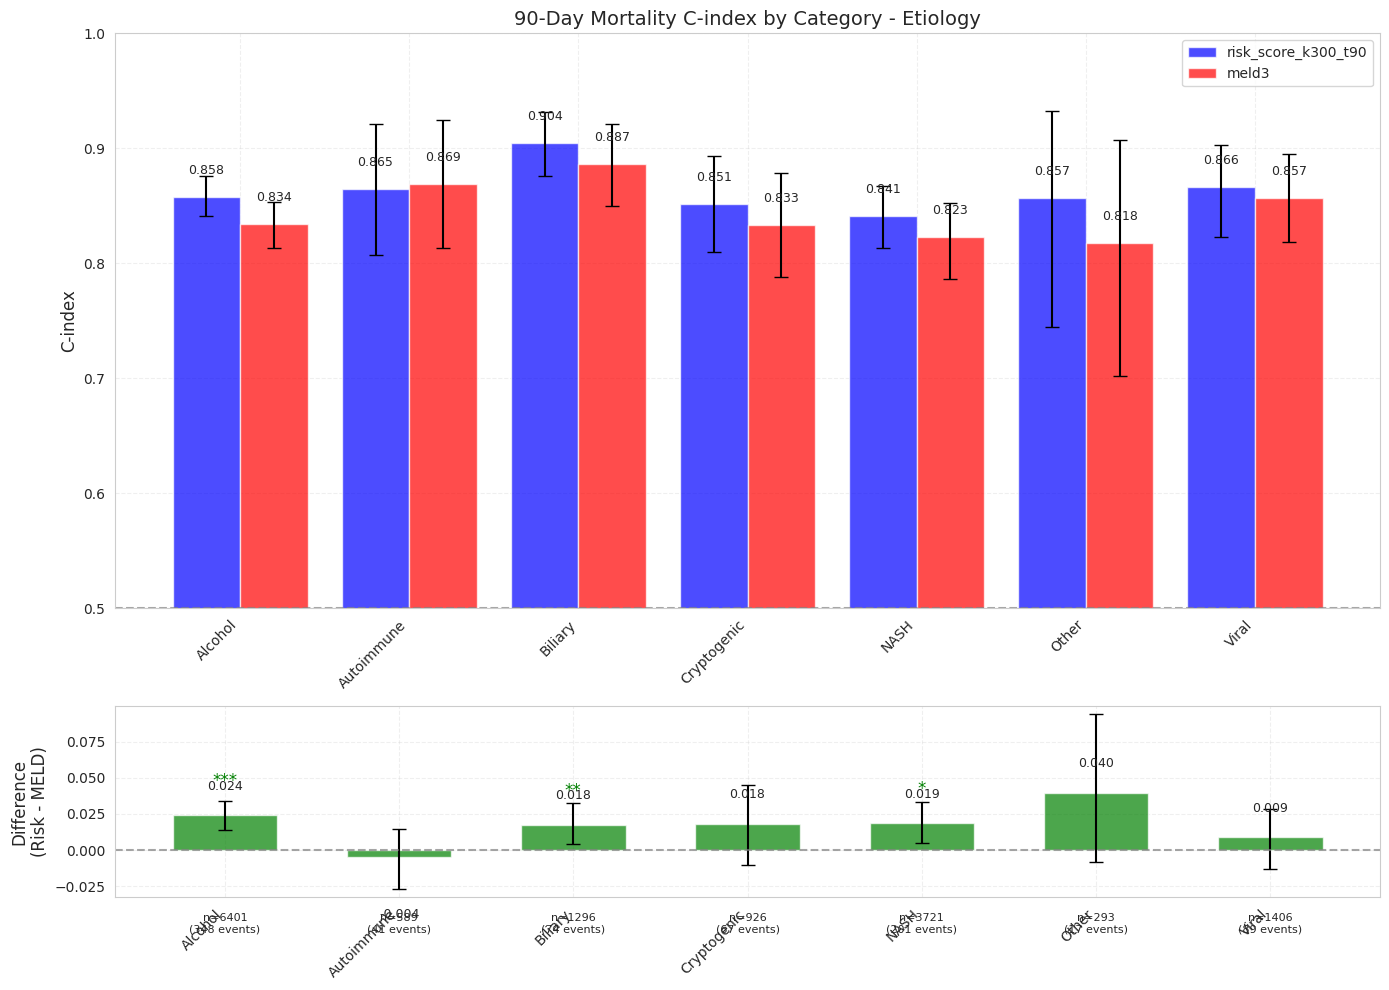

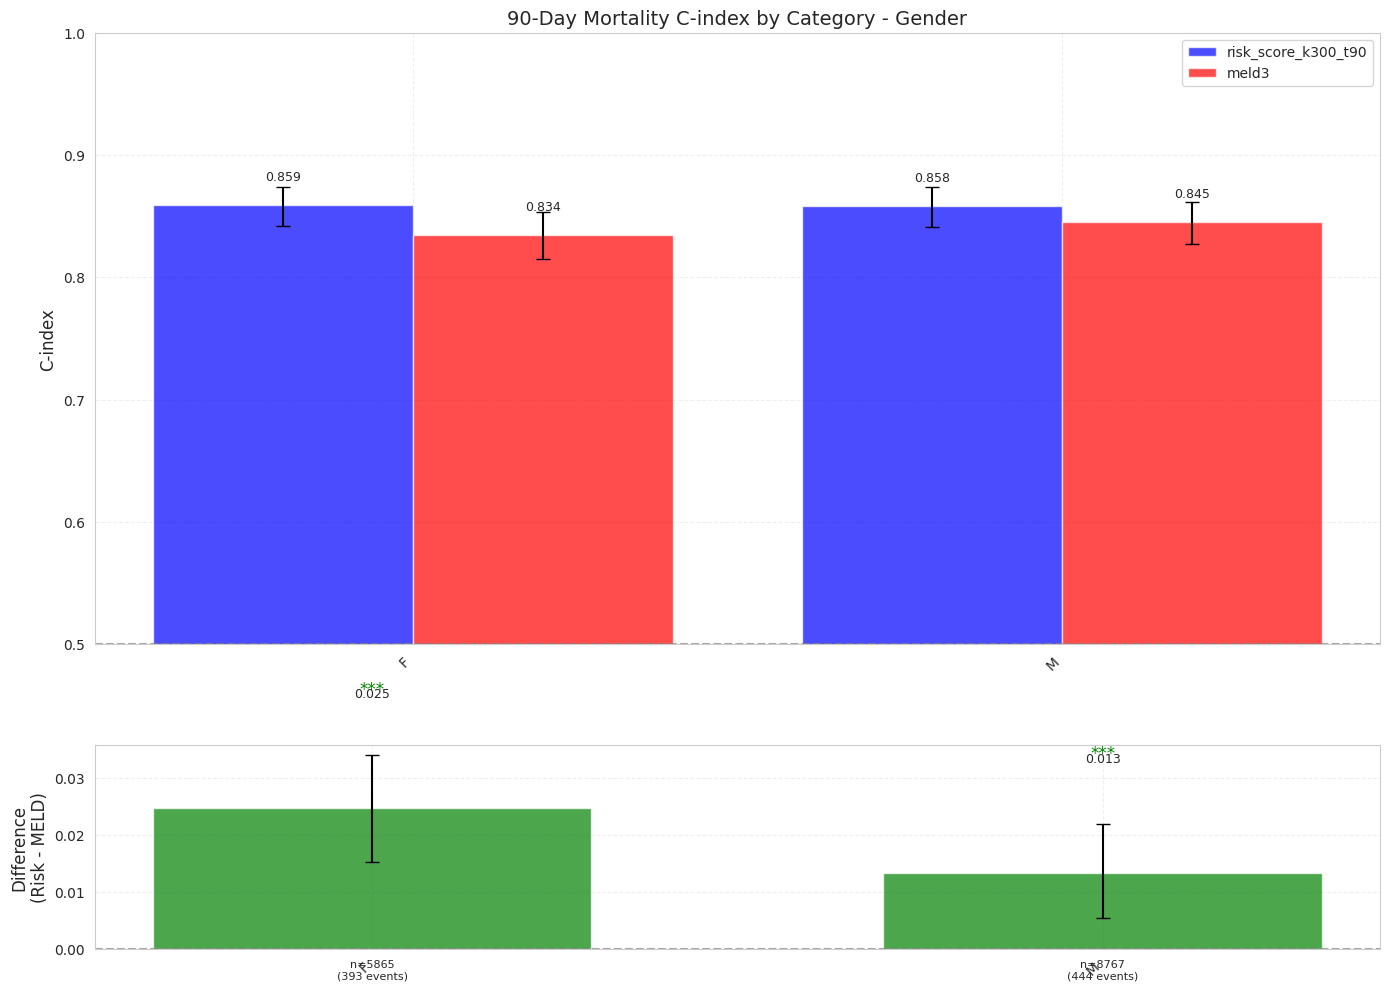

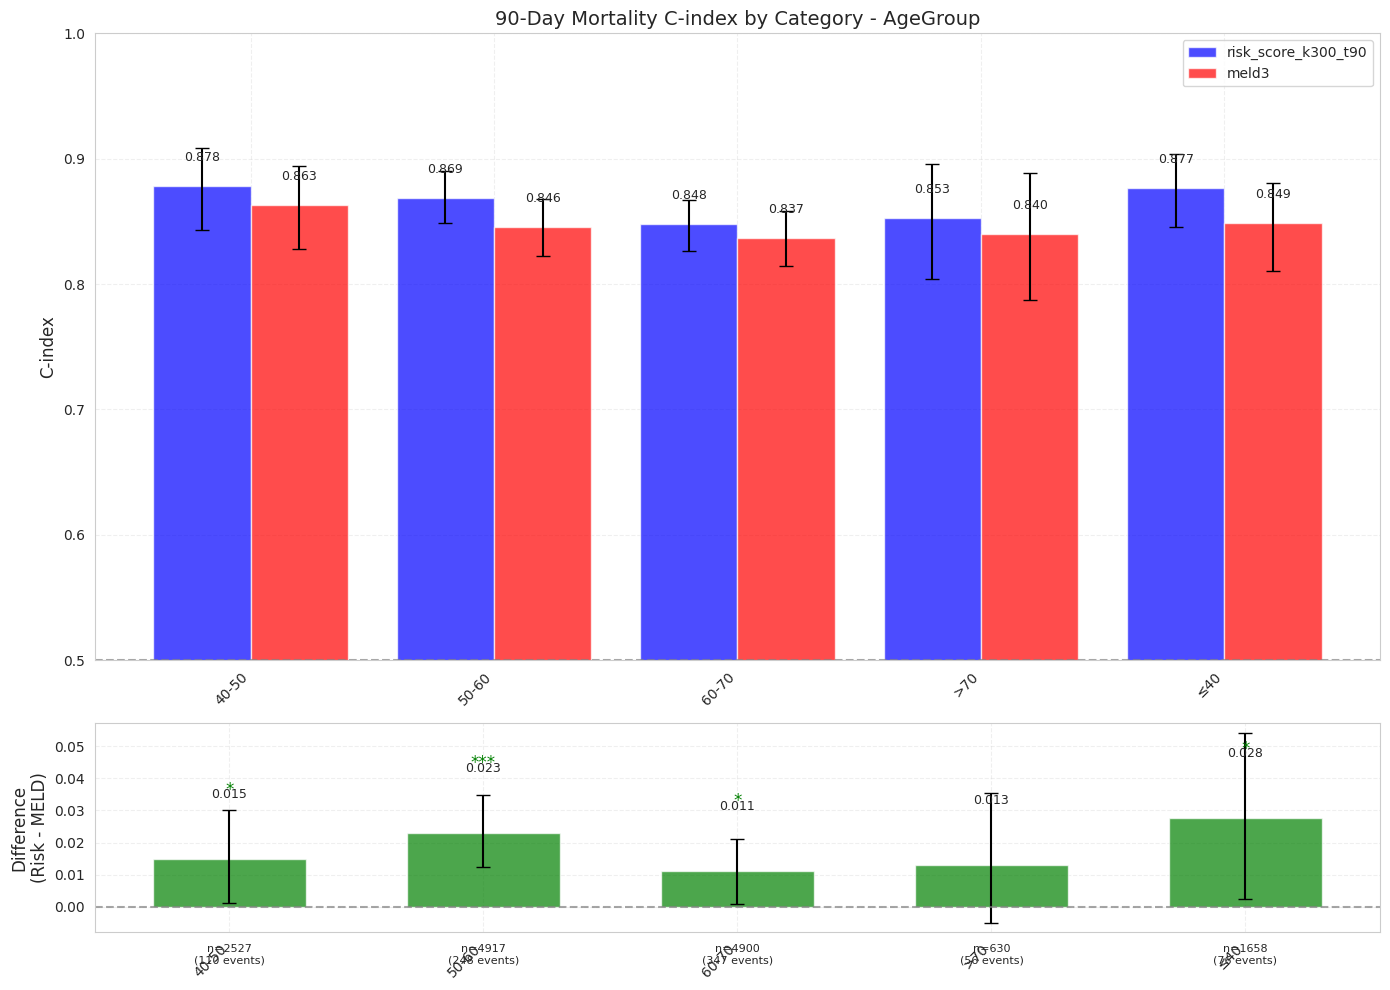

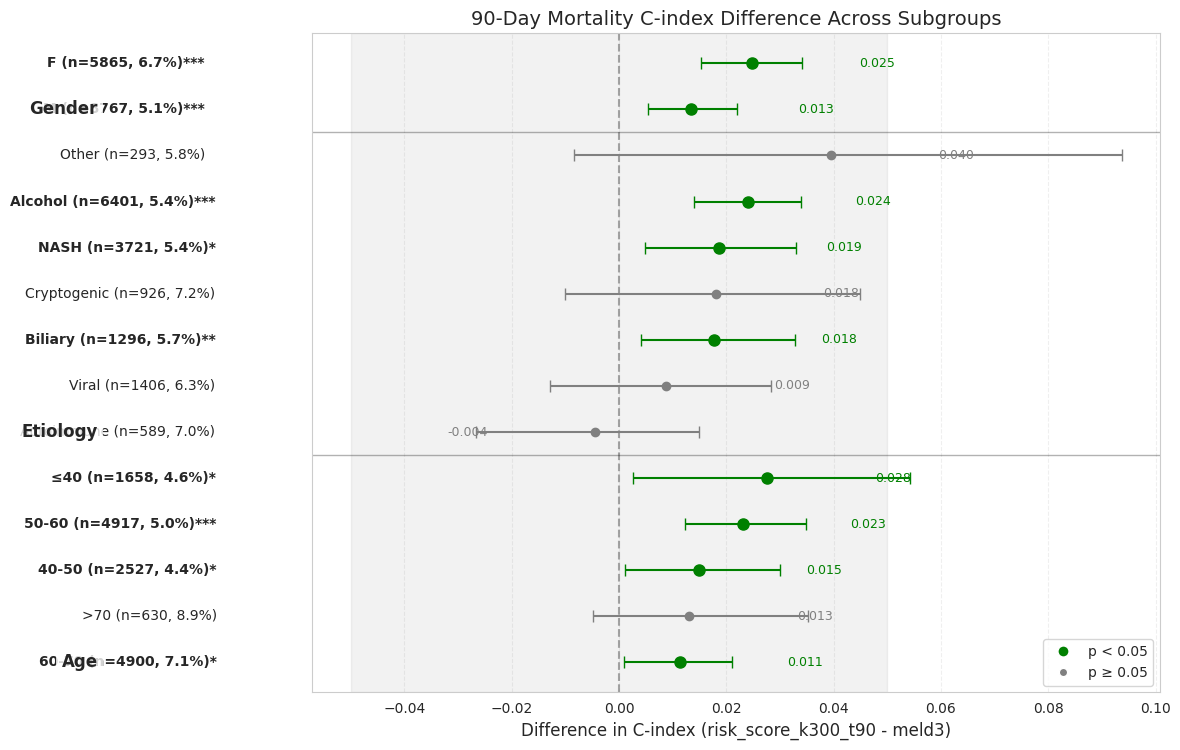

STARTING SUBGROUP C-INDEX ANALYSES
Comparing risk_score_k300_t90 vs meld3 across subgroups
Time horizon: 90 days
Minimum patients per subgroup: 20
Number of bootstrap samples: 500

======= ANALYSIS BY Etiology =======

Analyzing Etiology: Alcohol...
  Patients: 6401, Events: 348 (5.4%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8579 (95% CI: 0.8409-0.8761)
  meld3 c-index: 0.8339 (95% CI: 0.8128-0.8534)
  Difference: 0.0240 (95% CI: 0.0139-0.0340)
  p-value: 0.0000

Analyzing Etiology: Autoimmune...
  Patients: 589, Events: 41 (7.0%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8649 (95% CI: 0.8068-0.9208)
  meld3 c-index: 0.8694 (95% CI: 0.8133-0.9243)
  Difference: -0.0045 (95% CI: -0.0266-0.0149)
  p-value: 0.6880

Analyzing Etiology: Biliary...
  Patients: 1296, Events: 74 (5.7%)
  Running 500 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.9042 (95% CI: 0.8757-0.9318)
  meld3 c-index: 0.8865 (95% CI: 0.8501-0.9210)
  D

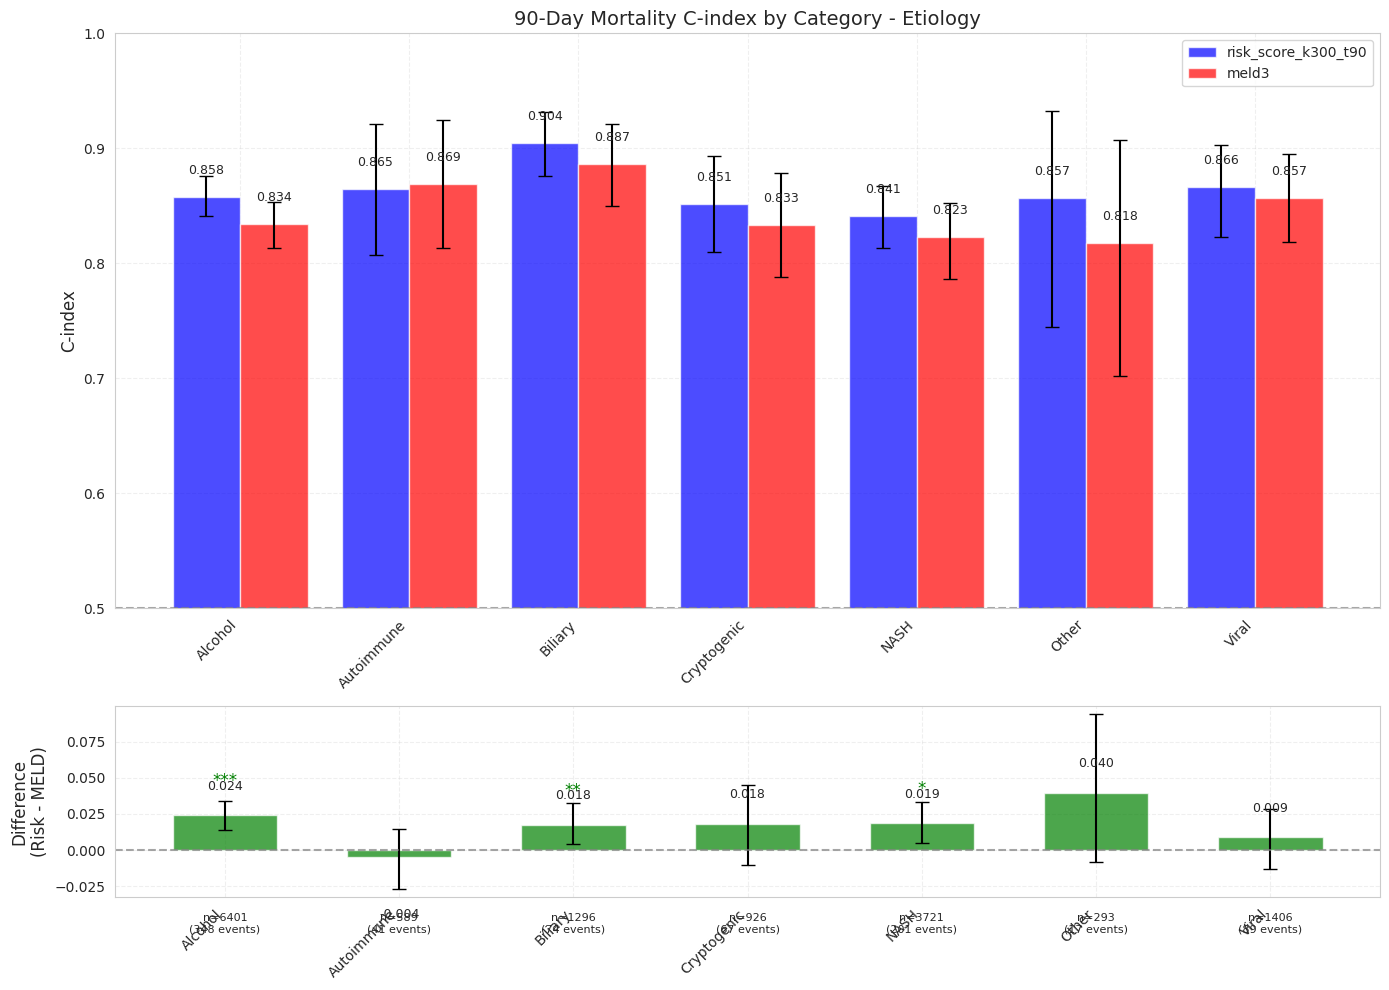

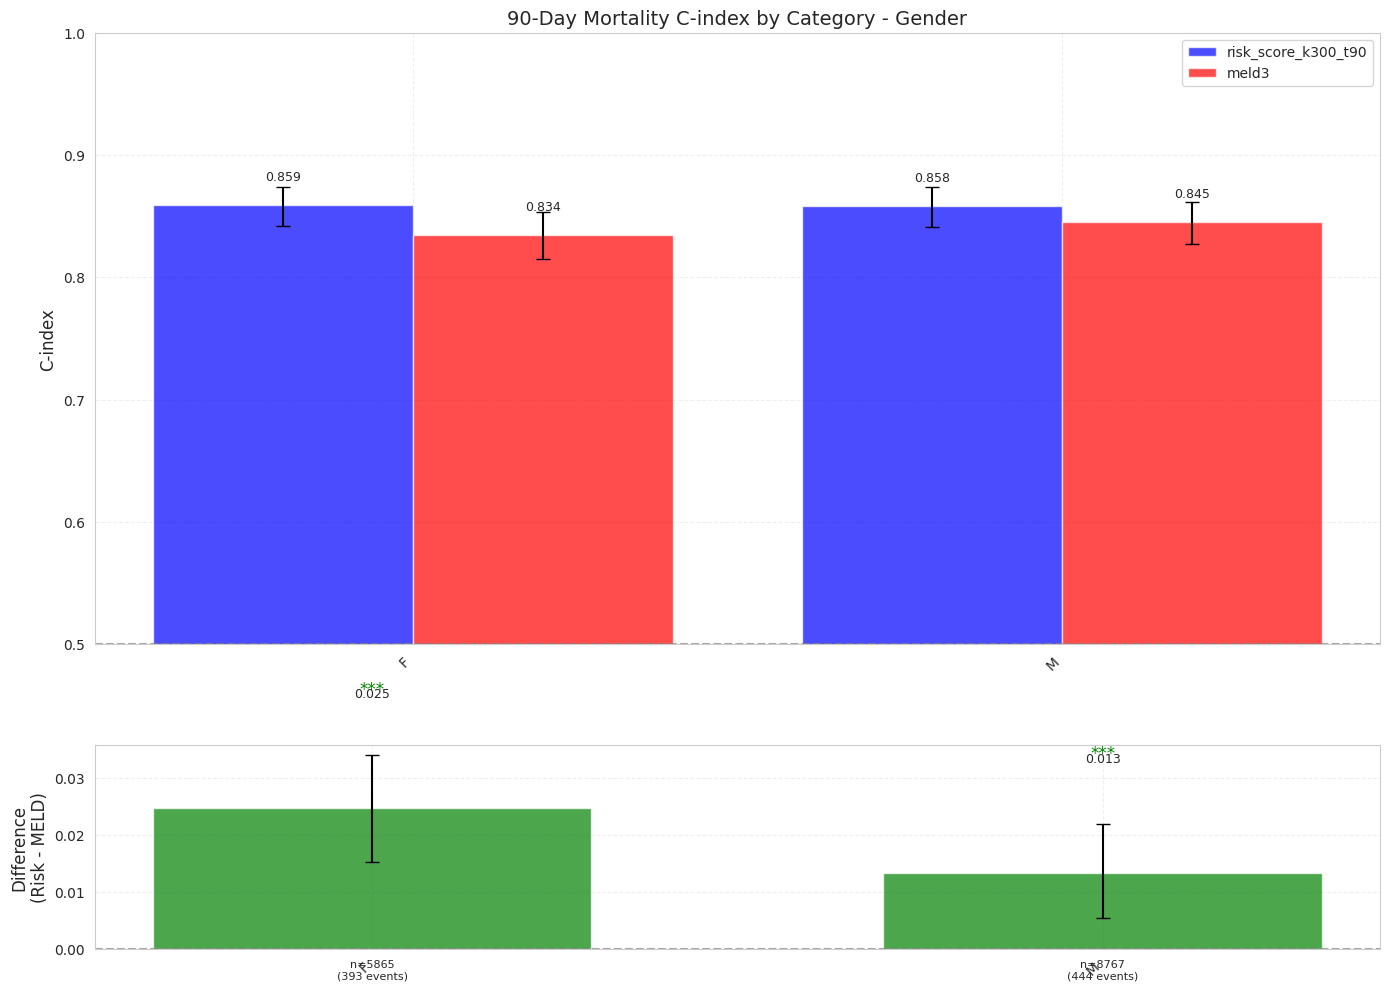

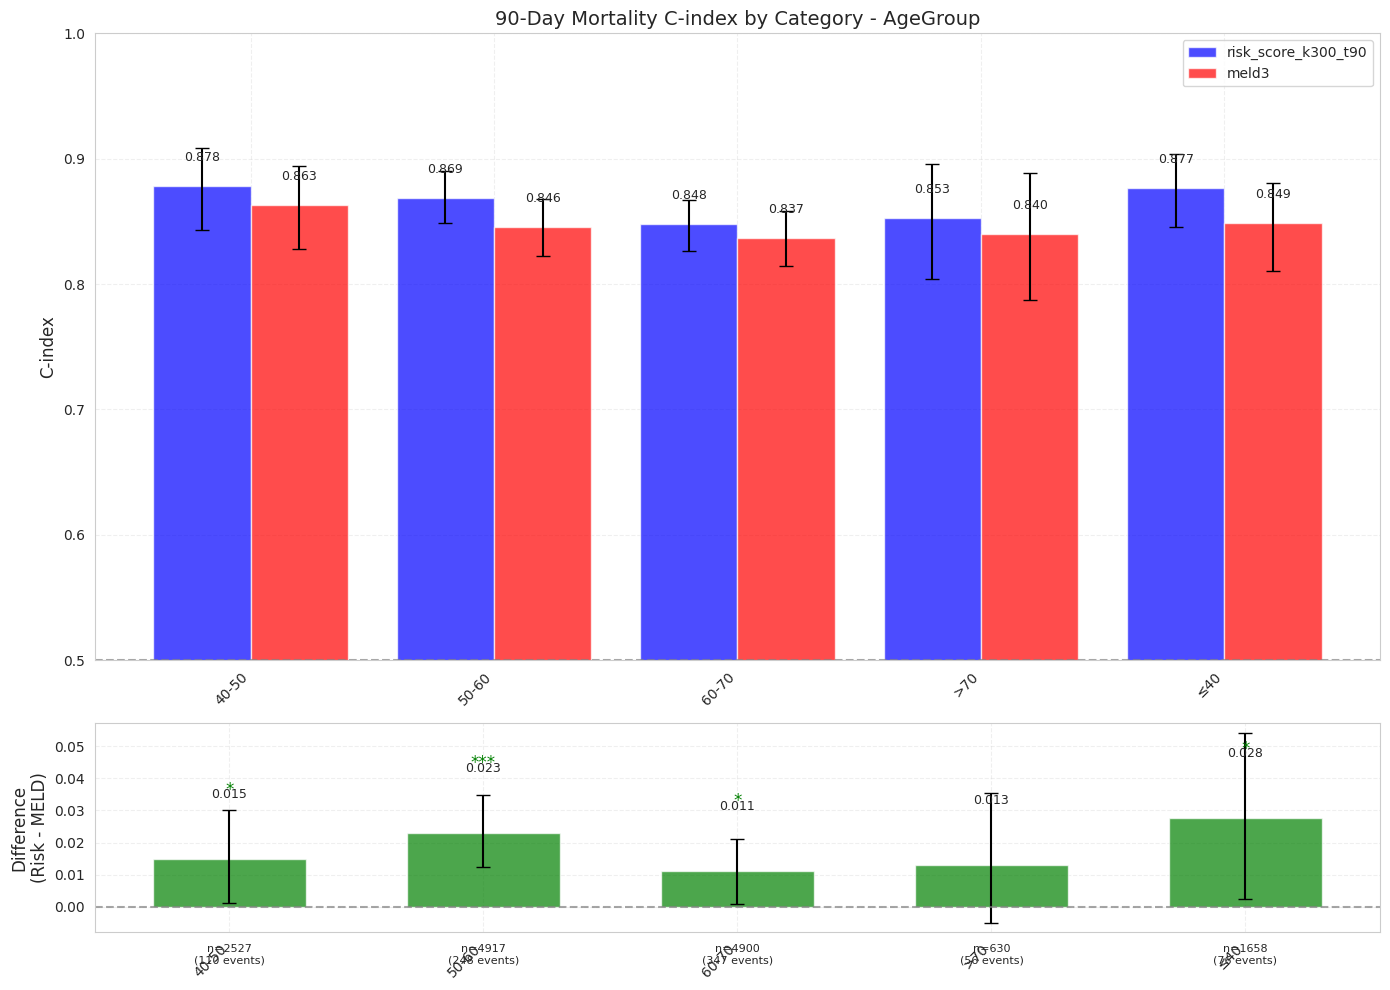

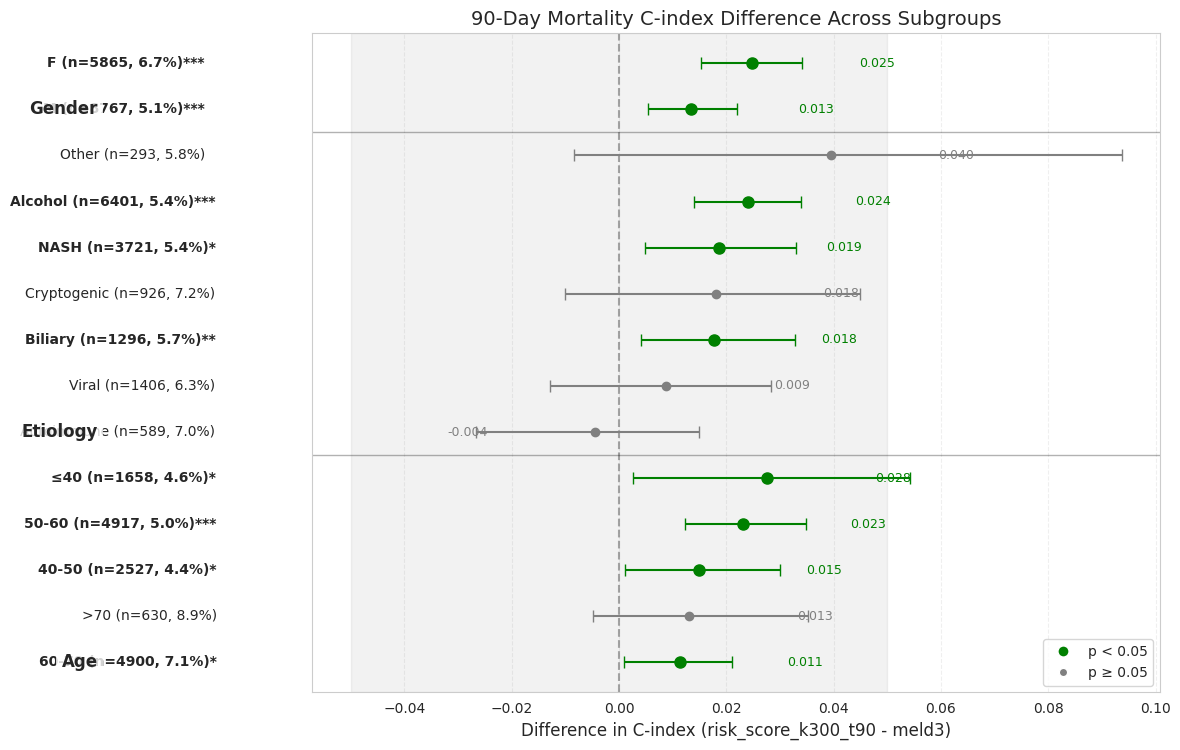


STARTING INTERACTION EFFECT ANALYSES

Testing interaction with Gender...
  risk_score_k300_t90 x Gender interaction: coef=-0.0305, p=0.6164
  meld3 x Gender interaction: coef=0.0052, p=0.9420

Testing interaction with Age Groups...
  risk_score_k300_t90 x age_40-50 interaction: coef=-0.0367, p=0.7936
  meld3 x age_40-50 interaction: coef=0.0137, p=0.9293
  risk_score_k300_t90 x age_50-60 interaction: coef=0.0323, p=0.7955
  meld3 x age_50-60 interaction: coef=0.0911, p=0.5085
  risk_score_k300_t90 x age_60-70 interaction: coef=0.0097, p=0.9357
  meld3 x age_60-70 interaction: coef=0.0426, p=0.7496
  risk_score_k300_t90 x age_>70 interaction: coef=-0.1194, p=0.4549
  meld3 x age_>70 interaction: coef=0.0908, p=0.6241

Testing interaction with Etiology...
  risk_score_k300_t90 x etiology_Autoimmune interaction: coef=0.0835, p=0.5689
  meld3 x etiology_Autoimmune interaction: coef=0.2927, p=0.0910
  risk_score_k300_t90 x etiology_Biliary interaction: coef=0.2965, p=0.0072
  meld3 x etiol

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def categorical_cindex_comparison(df,
                                risk_col="risk_score_k300_t90",
                                meld_col="meld3",
                                outcome_col="outcome",
                                tte_col="tte",
                                category_col=None,
                                horizon=90,
                                n_bootstraps=500,
                                random_state=42,
                                min_patients=20):
    """
    Compute and compare c-indices for risk score and MELD3 within different
    categories (e.g., etiology, gender, age groups).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        category_col: Column name for the categorical variable
        horizon: Time horizon in days (default: 90 days)
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility
        min_patients: Minimum number of patients required for analysis

    Returns:
        DataFrame with c-index results for each category
    """
    np.random.seed(random_state)
    results = []

    if category_col is None or category_col not in df.columns:
        print("Error: Valid category column must be provided")
        return pd.DataFrame()

    # Get unique categories
    categories = df[category_col].dropna().unique()

    # Analyze each category
    for category in sorted(categories):
        print(f"\nAnalyzing {category_col}: {category}...")

        # Filter patients in this category
        category_mask = df[category_col] == category
        category_df = df[category_mask].copy()

        if len(category_df) < min_patients:
            print(f"  Skipping {category} (only {len(category_df)} patients, minimum {min_patients} required)")
            results.append({
                'category_type': category_col,
                'category': category,
                'n_patients': len(category_df),
                'n_events': 0,
                'event_rate': 0,
                f'c_{risk_col}': np.nan,
                f'c_{meld_col}': np.nan,
                'difference': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan
            })
            continue

        # Prepare data for 90-day analysis
        category_df['event_t'] = ((category_df[outcome_col] == 0) &
                                (category_df[tte_col] <= horizon)).astype(int)
        category_df['time_t'] = np.minimum(category_df[tte_col], horizon)

        # Drop rows with missing data
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        clean_df = category_df[needed_cols].dropna()

        if len(clean_df) == 0 or clean_df['event_t'].sum() < 5:
            print(f"  Insufficient data or events in {category} after cleaning")
            results.append({
                'category_type': category_col,
                'category': category,
                'n_patients': len(category_df),
                'n_events': clean_df['event_t'].sum() if len(clean_df) > 0 else 0,
                'event_rate': clean_df['event_t'].mean() if len(clean_df) > 0 else 0,
                f'c_{risk_col}': np.nan,
                f'c_{meld_col}': np.nan,
                'difference': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan
            })
            continue

        # Count patients and events
        n_patients = len(clean_df)
        n_events = clean_df['event_t'].sum()
        event_rate = n_events / n_patients

        print(f"  Patients: {n_patients}, Events: {n_events} ({event_rate*100:.1f}%)")

        # Calculate c-indices on full data
        c_risk = concordance_index(
            clean_df['time_t'],
            -clean_df[risk_col],  # Negate risk score since higher is worse
            clean_df['event_t']
        )

        c_meld = concordance_index(
            clean_df['time_t'],
            -clean_df[meld_col],  # Negate MELD score since higher is worse
            clean_df['event_t']
        )

        orig_diff = c_risk - c_meld

        # Bootstrap to get confidence intervals
        print(f"  Running {n_bootstraps} bootstrap iterations...")

        # Arrays to store bootstrap results
        c_risk_boot = []
        c_meld_boot = []

        for _ in range(n_bootstraps):
            # Sample with replacement
            boot_idx = np.random.randint(0, n_patients, size=n_patients)
            boot_df = clean_df.iloc[boot_idx]

            # Skip iterations with no events or all events
            if boot_df['event_t'].sum() == 0 or boot_df['event_t'].sum() == len(boot_df):
                continue

            # Calculate c-indices for this bootstrap sample
            c_risk_b = concordance_index(
                boot_df['time_t'],
                -boot_df[risk_col],  # Negate risk score
                boot_df['event_t']
            )

            c_meld_b = concordance_index(
                boot_df['time_t'],
                -boot_df[meld_col],  # Negate MELD score
                boot_df['event_t']
            )

            c_risk_boot.append(c_risk_b)
            c_meld_boot.append(c_meld_b)

        # Convert to numpy arrays for calculations
        c_risk_boot = np.array(c_risk_boot)
        c_meld_boot = np.array(c_meld_boot)
        diff_boot = c_risk_boot - c_meld_boot

        # Calculate confidence intervals
        ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
        ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
        ci_diff = np.percentile(diff_boot, [2.5, 97.5])

        # Calculate p-value
        if orig_diff >= 0:
            p_one_sided = np.mean(diff_boot < 0)
        else:
            p_one_sided = np.mean(diff_boot > 0)
        p_value = min(2 * p_one_sided, 1.0)

        print(f"  {risk_col} c-index: {c_risk:.4f} (95% CI: {ci_risk[0]:.4f}-{ci_risk[1]:.4f})")
        print(f"  {meld_col} c-index: {c_meld:.4f} (95% CI: {ci_meld[0]:.4f}-{ci_meld[1]:.4f})")
        print(f"  Difference: {orig_diff:.4f} (95% CI: {ci_diff[0]:.4f}-{ci_diff[1]:.4f})")
        print(f"  p-value: {p_value:.4f}")

        # Store results
        results.append({
            'category_type': category_col,
            'category': category,
            'n_patients': n_patients,
            'n_events': n_events,
            'event_rate': event_rate,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': orig_diff,
            'ci_risk_lower': ci_risk[0],
            'ci_risk_upper': ci_risk[1],
            'ci_meld_lower': ci_meld[0],
            'ci_meld_upper': ci_meld[1],
            'ci_diff_lower': ci_diff[0],
            'ci_diff_upper': ci_diff[1],
            'p_value': p_value
        })

    return pd.DataFrame(results)


def create_categorical_cindex_table(results, risk_col="risk_score_k300_t90", meld_col="meld3"):
    """
    Create a formatted table of c-index results by categories.

    Args:
        results: DataFrame from categorical_cindex_comparison
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    table_data = []

    for _, row in results.iterrows():
        if pd.isna(row[f'c_{risk_col}']) or pd.isna(row[f'c_{meld_col}']):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[f'c_{risk_col}']:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[f'c_{meld_col}']:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['difference']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        event_rate = f"{row['event_rate']*100:.1f}%" if row['n_patients'] > 0 else "N/A"

        table_data.append({
            'Category Type': row['category_type'],
            'Category': row['category'],
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': event_rate,
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


def plot_categorical_cindices(results, risk_col="risk_score_k300_t90", meld_col="meld3",
                           category_type=None, figsize=(14, 10), save_path=None):
    """
    Plot c-indices and their differences across categories.

    Args:
        results: DataFrame from categorical_cindex_comparison
        risk_col: Name of risk column
        meld_col: Name of MELD column
        category_type: Filter for specific category type
        figsize: Figure size
        save_path: Path to save the figure

    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Filter results if category_type is specified
    if category_type is not None:
        plot_data = results[results['category_type'] == category_type].copy()
        title_suffix = f" - {category_type}"
    else:
        plot_data = results.copy()
        title_suffix = ""

    if len(plot_data) == 0:
        print("No data to plot")
        return None

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Get x positions and labels
    categories = plot_data['category'].values
    x_pos = np.arange(len(categories))

    # Plot c-indices with error bars
    risk_values = plot_data[f'c_{risk_col}'].values
    risk_errors = [
        plot_data[f'c_{risk_col}'].values - plot_data['ci_risk_lower'].values,
        plot_data['ci_risk_upper'].values - plot_data[f'c_{risk_col}'].values
    ]

    meld_values = plot_data[f'c_{meld_col}'].values
    meld_errors = [
        plot_data[f'c_{meld_col}'].values - plot_data['ci_meld_lower'].values,
        plot_data['ci_meld_upper'].values - plot_data[f'c_{meld_col}'].values
    ]

    # Plot bars for risk score
    risk_bars = ax1.bar(x_pos - 0.2, risk_values, width=0.4, color='blue', alpha=0.7,
                      yerr=risk_errors, capsize=5, label=f'{risk_col}')

    # Plot bars for MELD score
    meld_bars = ax1.bar(x_pos + 0.2, meld_values, width=0.4, color='red', alpha=0.7,
                      yerr=meld_errors, capsize=5, label=f'{meld_col}')

    # Format the c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title(f'90-Day Mortality C-index by Category{title_suffix}', fontsize=14)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_ylim(0.5, 1.0)

    # Add value labels on the bars
    for i, v in enumerate(risk_values):
        if not np.isnan(v):
            ax1.text(i - 0.2, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

    for i, v in enumerate(meld_values):
        if not np.isnan(v):
            ax1.text(i + 0.2, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = plot_data['difference'].values
    diff_errors = [
        plot_data['difference'].values - plot_data['ci_diff_lower'].values,
        plot_data['ci_diff_upper'].values - plot_data['difference'].values
    ]

    ax2.bar(x_pos, diff_values, width=0.6, color='green', alpha=0.7,
          yerr=diff_errors, capsize=5)

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(plot_data['p_value']):
        if not np.isnan(p_value) and p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.02 if diff_values[i] >= 0 else diff_values[i] - 0.04
            ax2.text(x_pos[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Format the difference plot
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(categories, rotation=45, ha='right')
    ax2.grid(True, linestyle='--', alpha=0.3)

    # Add value labels on the difference bars
    for i, v in enumerate(diff_values):
        if not np.isnan(v):
            y_pos = v + 0.02 if v >= 0 else v - 0.04
            ax2.text(i, y_pos, f'{v:.3f}', ha='center', va='center', fontsize=9)

    # Add number of patients/events below the x-axis
    for i, row in enumerate(plot_data.itertuples()):
        if row.n_patients > 0:
            ax2.text(i, ax2.get_ylim()[0] - 0.05,
                    f'n={row.n_patients}\n({row.n_events} events)',
                    ha='center', va='top', fontsize=8,
                    transform=ax2.get_xaxis_transform())

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def create_age_groups(df, age_col="Age", bins=None):
    """
    Create age groups in the dataframe.

    Args:
        df: DataFrame with patient data
        age_col: Column name for age
        bins: List of age bins boundaries, default is [0, 40, 50, 60, 70, 120]

    Returns:
        pandas.DataFrame: DataFrame with new 'AgeGroup' column
    """
    result_df = df.copy()

    if bins is None:
        bins = [0, 40, 50, 60, 70, 120]

    # Create age group labels
    labels = []
    for i in range(len(bins) - 1):
        if i == 0:
            labels.append(f"≤{bins[i+1]}")
        elif i == len(bins) - 2:
            labels.append(f">{bins[i]}")
        else:
            labels.append(f"{bins[i]}-{bins[i+1]}")

    # Create age groups
    result_df['AgeGroup'] = pd.cut(
        result_df[age_col],
        bins=bins,
        labels=labels,
        right=False
    )

    return result_df


def run_subgroup_analyses(df, risk_col="risk_score_k300_t90", meld_col="meld3",
                        etiology_col="Etiology", gender_col="Gender", age_col="Age",
                        horizon=90, n_bootstraps=500, min_patients=20):
    """
    Run comprehensive subgroup analyses across etiology, gender, and age groups.

    Args:
        df: DataFrame with time-to-event data
        risk_col, meld_col: Names of the risk and MELD columns
        etiology_col, gender_col, age_col: Names of the stratification columns
        horizon: Time horizon in days
        n_bootstraps: Number of bootstrap samples
        min_patients: Minimum patients per subgroup for analysis

    Returns:
        Dictionary with results and plots
    """
    results_dict = {}

    print(f"Comparing {risk_col} vs {meld_col} across subgroups")
    print(f"Time horizon: {horizon} days")
    print(f"Minimum patients per subgroup: {min_patients}")
    print(f"Number of bootstrap samples: {n_bootstraps}")

    # 1. Etiology analysis
    if etiology_col in df.columns:
        print(f"\n======= ANALYSIS BY {etiology_col} =======")
        etiology_results = categorical_cindex_comparison(
            df=df,
            risk_col=risk_col,
            meld_col=meld_col,
            category_col=etiology_col,
            horizon=horizon,
            n_bootstraps=n_bootstraps,
            min_patients=min_patients
        )

        if len(etiology_results) > 0:
            etiology_table = create_categorical_cindex_table(etiology_results, risk_col, meld_col)
            etiology_plot = plot_categorical_cindices(
                etiology_results,
                risk_col,
                meld_col,
                category_type=etiology_col,
                save_path=f"cindex_by_{etiology_col}_{horizon}days.png"
            )

            # Save results
            etiology_results.to_csv(f"cindex_results_by_{etiology_col}_{horizon}days.csv", index=False)
            etiology_table.to_csv(f"cindex_table_by_{etiology_col}_{horizon}days.csv", index=False)

            results_dict['etiology'] = {
                'results': etiology_results,
                'table': etiology_table,
                'plot': etiology_plot
            }

    # 2. Gender analysis
    if gender_col in df.columns:
        print(f"\n======= ANALYSIS BY {gender_col} =======")
        gender_results = categorical_cindex_comparison(
            df=df,
            risk_col=risk_col,
            meld_col=meld_col,
            category_col=gender_col,
            horizon=horizon,
            n_bootstraps=n_bootstraps,
            min_patients=min_patients
        )

        if len(gender_results) > 0:
            gender_table = create_categorical_cindex_table(gender_results, risk_col, meld_col)
            gender_plot = plot_categorical_cindices(
                gender_results,
                risk_col,
                meld_col,
                category_type=gender_col,
                save_path=f"cindex_by_{gender_col}_{horizon}days.png"
            )

            # Save results
            gender_results.to_csv(f"cindex_results_by_{gender_col}_{horizon}days.csv", index=False)
            gender_table.to_csv(f"cindex_table_by_{gender_col}_{horizon}days.csv", index=False)

            results_dict['gender'] = {
                'results': gender_results,
                'table': gender_table,
                'plot': gender_plot
            }

    # 3. Age group analysis
    if age_col in df.columns:
        print(f"\n======= ANALYSIS BY AGE GROUPS =======")
        # Create age groups
        df_with_age_groups = create_age_groups(df, age_col)

        age_results = categorical_cindex_comparison(
            df=df_with_age_groups,
            risk_col=risk_col,
            meld_col=meld_col,
            category_col='AgeGroup',
            horizon=horizon,
            n_bootstraps=n_bootstraps,
            min_patients=min_patients
        )

        if len(age_results) > 0:
            age_table = create_categorical_cindex_table(age_results, risk_col, meld_col)
            age_plot = plot_categorical_cindices(
                age_results,
                risk_col,
                meld_col,
                category_type='AgeGroup',
                save_path=f"cindex_by_AgeGroup_{horizon}days.png"
            )

            # Save results
            age_results.to_csv(f"cindex_results_by_AgeGroup_{horizon}days.csv", index=False)
            age_table.to_csv(f"cindex_table_by_AgeGroup_{horizon}days.csv", index=False)

            results_dict['age'] = {
                'results': age_results,
                'table': age_table,
                'plot': age_plot
            }

    # 4. Combined visualization
    # Create a comprehensive figure with all subgroup analyses
    if len(results_dict) > 0:
        create_comprehensive_plot(results_dict, risk_col, meld_col, horizon)

    return results_dict


def create_comprehensive_plot(results_dict, risk_col="risk_score_k300_t90", meld_col="meld3", horizon=90):
    """
    Create a comprehensive plot showing differences across all subgroups.

    Args:
        results_dict: Dictionary with results from run_subgroup_analyses
        risk_col: Name of risk column
        meld_col: Name of MELD column
        horizon: Time horizon in days
    """
    # Collect all results
    all_rows = []

    for analysis_type, analysis_results in results_dict.items():
        results_df = analysis_results['results']
        for _, row in results_df.iterrows():
            # Skip rows with missing data
            if pd.isna(row[f'c_{risk_col}']) or pd.isna(row[f'c_{meld_col}']):
                continue

            all_rows.append({
                'Analysis': analysis_type.capitalize(),
                'Subgroup': row['category'],
                'Difference': row['difference'],
                'CI_Lower': row['ci_diff_lower'],
                'CI_Upper': row['ci_diff_upper'],
                'P_Value': row['p_value'],
                'N_Patients': row['n_patients'],
                'Event_Rate': row['event_rate']
            })

    if not all_rows:
        print("No valid data for comprehensive plot")
        return

    # Create DataFrame from collected results
    plot_df = pd.DataFrame(all_rows)

    # Sort by Analysis type and then by Difference
    plot_df = plot_df.sort_values(['Analysis', 'Difference'])

    # Create the forest plot
    plt.figure(figsize=(12, len(plot_df) * 0.4 + 2))

    # Plot zero reference line
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # Add shaded area for non-significant differences
    plt.axvspan(-0.05, 0.05, alpha=0.1, color='gray')

    # Plot each subgroup as a point with error bars
    for i, row in enumerate(plot_df.itertuples()):
        # Color based on significance
        color = 'green' if row.P_Value < 0.05 else 'gray'

        # Plot error bar
        plt.errorbar(
            x=row.Difference,
            y=i,
            xerr=[[row.Difference - row.CI_Lower], [row.CI_Upper - row.Difference]],
            fmt='o',
            color=color,
            capsize=4,
            markersize=8 if row.P_Value < 0.05 else 6
        )

        # Add significance markers
        marker = ''
        if row.P_Value < 0.05:
            marker = '*'
            if row.P_Value < 0.01:
                marker = '**'
            if row.P_Value < 0.001:
                marker = '***'

        # Label format: Subgroup (n=X, events=Y%)
        label = f"{row.Subgroup} (n={row.N_Patients}, {row.Event_Rate*100:.1f}%){marker}"

        # Add label on the y-axis
        plt.text(
            x=plt.xlim()[0] - 0.02,
            y=i,
            s=label,
            ha='right',
            va='center',
            fontsize=10,
            fontweight='bold' if row.P_Value < 0.05 else 'normal'
        )

        # Add difference value
        plt.text(
            x=row.Difference + (0.02 if row.Difference >= 0 else -0.02),
            y=i,
            s=f"{row.Difference:.3f}",
            ha='left' if row.Difference >= 0 else 'right',
            va='center',
            fontsize=9,
            color=color
        )

    # Add analysis type separators and labels
    current_analysis = None
    for i, row in enumerate(plot_df.itertuples()):
        if row.Analysis != current_analysis:
            if i > 0:
                plt.axhline(y=i-0.5, color='black', linestyle='-', alpha=0.3, linewidth=1)
            current_analysis = row.Analysis
            plt.text(
                x=plt.xlim()[0] - 0.04,
                y=i,
                s=row.Analysis,
                ha='right',
                va='center',
                fontsize=12,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
            )

    # Format the plot
    plt.yticks([])  # Hide y-axis ticks since we have custom labels
    plt.xlabel(f'Difference in C-index ({risk_col} - {meld_col})', fontsize=12)
    plt.title(f'{horizon}-Day Mortality C-index Difference Across Subgroups', fontsize=14)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)

    # Add legend for significance
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='p < 0.05'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, label='p ≥ 0.05')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(f"comprehensive_cindex_comparison_{horizon}days.png", dpi=300, bbox_inches='tight')
    plt.show()


# Example usage
if __name__ == "__main__":
    # Run the subgroup analyses with your dataframe
    results = run_subgroup_analyses(
        df=df,  # Your dataframe should be defined elsewhere
        risk_col="risk_score_k300_t90",
        meld_col="meld3",
        etiology_col="Etiology",
        gender_col="Gender",
        age_col="Age",
        horizon=90,
        n_bootstraps=500,
        min_patients=20
    )
def test_interaction_effects(df, risk_col="risk_score_k300_t90", meld_col="meld3",
                          etiology_col="Etiology", gender_col="Gender", age_col="Age",
                          horizon=90):
    """
    Test for interaction effects between subgroup variables and risk/MELD scores.
    This helps determine if the prediction models perform differently across subgroups.

    Args:
        df: DataFrame with time-to-event data
        risk_col, meld_col: Names of the risk and MELD columns
        etiology_col, gender_col, age_col: Names of the stratification columns
        horizon: Time horizon in days

    Returns:
        Dictionary with interaction test results
    """
    from lifelines import CoxPHFitter

    results = {}

    # Prepare data for analysis with 90-day outcome
    analysis_df = df.copy()
    analysis_df['event_t'] = ((analysis_df['outcome'] == 0) &
                            (analysis_df['tte'] <= horizon)).astype(int)
    analysis_df['time_t'] = np.minimum(analysis_df['tte'], horizon)

    # Standardize risk and MELD scores for better interpretation
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    analysis_df[[f'{risk_col}_std', f'{meld_col}_std']] = scaler.fit_transform(
        analysis_df[[risk_col, meld_col]])

    # Add age groups if needed
    if age_col in analysis_df.columns:
        analysis_df = create_age_groups(analysis_df, age_col)

    # 1. Test interaction with Gender
    if gender_col in analysis_df.columns:
        print(f"\nTesting interaction with {gender_col}...")

        # Encode gender as numeric if needed
        if analysis_df[gender_col].dtype == 'object':
            gender_values = sorted(analysis_df[gender_col].dropna().unique())
            gender_map = {val: i for i, val in enumerate(gender_values)}
            analysis_df[f'{gender_col}_num'] = analysis_df[gender_col].map(gender_map)
        else:
            analysis_df[f'{gender_col}_num'] = analysis_df[gender_col]

        # Create interaction terms
        analysis_df[f'{risk_col}_x_gender'] = analysis_df[f'{risk_col}_std'] * analysis_df[f'{gender_col}_num']
        analysis_df[f'{meld_col}_x_gender'] = analysis_df[f'{meld_col}_std'] * analysis_df[f'{gender_col}_num']

        # Test risk score interaction
        risk_interaction_df = analysis_df[[
            'time_t', 'event_t', f'{risk_col}_std', f'{gender_col}_num', f'{risk_col}_x_gender'
        ]].dropna()

        risk_model = CoxPHFitter()
        risk_model.fit(risk_interaction_df, duration_col='time_t', event_col='event_t')

        # Test MELD interaction
        meld_interaction_df = analysis_df[[
            'time_t', 'event_t', f'{meld_col}_std', f'{gender_col}_num', f'{meld_col}_x_gender'
        ]].dropna()

        meld_model = CoxPHFitter()
        meld_model.fit(meld_interaction_df, duration_col='time_t', event_col='event_t')

        # Store results
        results[gender_col] = {
            'risk_interaction': {
                'coef': risk_model.summary.loc[f'{risk_col}_x_gender', 'coef'],
                'exp(coef)': risk_model.summary.loc[f'{risk_col}_x_gender', 'exp(coef)'],
                'p': risk_model.summary.loc[f'{risk_col}_x_gender', 'p'],
                'model_summary': risk_model.summary
            },
            'meld_interaction': {
                'coef': meld_model.summary.loc[f'{meld_col}_x_gender', 'coef'],
                'exp(coef)': meld_model.summary.loc[f'{meld_col}_x_gender', 'exp(coef)'],
                'p': meld_model.summary.loc[f'{meld_col}_x_gender', 'p'],
                'model_summary': meld_model.summary
            }
        }

        print(f"  {risk_col} x {gender_col} interaction: coef={results[gender_col]['risk_interaction']['coef']:.4f}, p={results[gender_col]['risk_interaction']['p']:.4f}")
        print(f"  {meld_col} x {gender_col} interaction: coef={results[gender_col]['meld_interaction']['coef']:.4f}, p={results[gender_col]['meld_interaction']['p']:.4f}")

    # 2. Test interaction with Age Groups
    if 'AgeGroup' in analysis_df.columns:
        print(f"\nTesting interaction with Age Groups...")

        # Need to create dummy variables for age groups
        age_dummies = pd.get_dummies(analysis_df['AgeGroup'], prefix='age', drop_first=True)
        analysis_df = pd.concat([analysis_df, age_dummies], axis=1)

        age_groups = age_dummies.columns.tolist()
        age_interactions = {}

        # Test interaction with each age group dummy
        for age_group in age_groups:
            # Create interaction terms
            analysis_df[f'{risk_col}_x_{age_group}'] = analysis_df[f'{risk_col}_std'] * analysis_df[age_group]
            analysis_df[f'{meld_col}_x_{age_group}'] = analysis_df[f'{meld_col}_std'] * analysis_df[age_group]

        # Fit model with all age interactions for risk score
        risk_cols = [f'{risk_col}_std'] + age_groups + [f'{risk_col}_x_{g}' for g in age_groups]
        risk_interaction_df = analysis_df[['time_t', 'event_t'] + risk_cols].dropna()

        risk_model = CoxPHFitter()
        risk_model.fit(risk_interaction_df, duration_col='time_t', event_col='event_t')

        # Fit model with all age interactions for MELD
        meld_cols = [f'{meld_col}_std'] + age_groups + [f'{meld_col}_x_{g}' for g in age_groups]
        meld_interaction_df = analysis_df[['time_t', 'event_t'] + meld_cols].dropna()

        meld_model = CoxPHFitter()
        meld_model.fit(meld_interaction_df, duration_col='time_t', event_col='event_t')

        # Store results
        age_results = {
            'risk_interactions': {},
            'meld_interactions': {}
        }

        for age_group in age_groups:
            int_term_risk = f'{risk_col}_x_{age_group}'
            int_term_meld = f'{meld_col}_x_{age_group}'

            if int_term_risk in risk_model.summary.index:
                age_results['risk_interactions'][age_group] = {
                    'coef': risk_model.summary.loc[int_term_risk, 'coef'],
                    'p': risk_model.summary.loc[int_term_risk, 'p']
                }
                print(f"  {risk_col} x {age_group} interaction: coef={age_results['risk_interactions'][age_group]['coef']:.4f}, p={age_results['risk_interactions'][age_group]['p']:.4f}")

            if int_term_meld in meld_model.summary.index:
                age_results['meld_interactions'][age_group] = {
                    'coef': meld_model.summary.loc[int_term_meld, 'coef'],
                    'p': meld_model.summary.loc[int_term_meld, 'p']
                }
                print(f"  {meld_col} x {age_group} interaction: coef={age_results['meld_interactions'][age_group]['coef']:.4f}, p={age_results['meld_interactions'][age_group]['p']:.4f}")

        age_results['risk_model_summary'] = risk_model.summary
        age_results['meld_model_summary'] = meld_model.summary
        results['AgeGroup'] = age_results

    # 3. Test interaction with Etiology
    if etiology_col in analysis_df.columns:
        print(f"\nTesting interaction with {etiology_col}...")

        # Need to create dummy variables for etiology
        etiology_dummies = pd.get_dummies(analysis_df[etiology_col], prefix='etiology', drop_first=True)
        analysis_df = pd.concat([analysis_df, etiology_dummies], axis=1)

        etiology_groups = etiology_dummies.columns.tolist()

        # Test interaction with each etiology dummy
        for etiology_group in etiology_groups:
            # Create interaction terms
            analysis_df[f'{risk_col}_x_{etiology_group}'] = analysis_df[f'{risk_col}_std'] * analysis_df[etiology_group]
            analysis_df[f'{meld_col}_x_{etiology_group}'] = analysis_df[f'{meld_col}_std'] * analysis_df[etiology_group]

        # Fit model with all etiology interactions for risk score
        risk_cols = [f'{risk_col}_std'] + etiology_groups + [f'{risk_col}_x_{g}' for g in etiology_groups]
        risk_interaction_df = analysis_df[['time_t', 'event_t'] + risk_cols].dropna()

        # Only proceed if there are enough samples
        if len(risk_interaction_df) > len(risk_cols) * 5:  # Rule of thumb: at least 5 samples per predictor
            risk_model = CoxPHFitter()
            risk_model.fit(risk_interaction_df, duration_col='time_t', event_col='event_t')

            # Fit model with all etiology interactions for MELD
            meld_cols = [f'{meld_col}_std'] + etiology_groups + [f'{meld_col}_x_{g}' for g in etiology_groups]
            meld_interaction_df = analysis_df[['time_t', 'event_t'] + meld_cols].dropna()

            meld_model = CoxPHFitter()
            meld_model.fit(meld_interaction_df, duration_col='time_t', event_col='event_t')

            # Store results
            etiology_results = {
                'risk_interactions': {},
                'meld_interactions': {}
            }

            for etiology_group in etiology_groups:
                int_term_risk = f'{risk_col}_x_{etiology_group}'
                int_term_meld = f'{meld_col}_x_{etiology_group}'

                if int_term_risk in risk_model.summary.index:
                    etiology_results['risk_interactions'][etiology_group] = {
                        'coef': risk_model.summary.loc[int_term_risk, 'coef'],
                        'p': risk_model.summary.loc[int_term_risk, 'p']
                    }
                    print(f"  {risk_col} x {etiology_group} interaction: coef={etiology_results['risk_interactions'][etiology_group]['coef']:.4f}, p={etiology_results['risk_interactions'][etiology_group]['p']:.4f}")

                if int_term_meld in meld_model.summary.index:
                    etiology_results['meld_interactions'][etiology_group] = {
                        'coef': meld_model.summary.loc[int_term_meld, 'coef'],
                        'p': meld_model.summary.loc[int_term_meld, 'p']
                    }
                    print(f"  {meld_col} x {etiology_group} interaction: coef={etiology_results['meld_interactions'][etiology_group]['coef']:.4f}, p={etiology_results['meld_interactions'][etiology_group]['p']:.4f}")

            etiology_results['risk_model_summary'] = risk_model.summary
            etiology_results['meld_model_summary'] = meld_model.summary
            results[etiology_col] = etiology_results
        else:
            print(f"  Insufficient samples for {etiology_col} interaction analysis")

    return results


def run_all_analyses(df, risk_col="risk_score_k300_t90", meld_col="meld3",
                   etiology_col="Etiology", gender_col="Gender", age_col="Age",
                   horizon=90, n_bootstraps=500, min_patients=20):
    """
    Run all analyses: subgroup comparisons and interaction tests.

    Args:
        df: DataFrame with time-to-event data
        risk_col, meld_col: Names of the risk and MELD columns
        etiology_col, gender_col, age_col: Names of the stratification columns
        horizon: Time horizon in days
        n_bootstraps: Number of bootstrap samples
        min_patients: Minimum patients per subgroup for analysis

    Returns:
        Dictionary with all analysis results
    """
    # Run subgroup c-index comparisons
    print("==================================================")
    print("STARTING SUBGROUP C-INDEX ANALYSES")
    print("==================================================")
    subgroup_results = run_subgroup_analyses(
        df=df,
        risk_col=risk_col,
        meld_col=meld_col,
        etiology_col=etiology_col,
        gender_col=gender_col,
        age_col=age_col,
        horizon=horizon,
        n_bootstraps=n_bootstraps,
        min_patients=min_patients
    )

    # Run interaction tests
    print("\n==================================================")
    print("STARTING INTERACTION EFFECT ANALYSES")
    print("==================================================")
    interaction_results = test_interaction_effects(
        df=df,
        risk_col=risk_col,
        meld_col=meld_col,
        etiology_col=etiology_col,
        gender_col=gender_col,
        age_col=age_col,
        horizon=horizon
    )

    # Return combined results
    return {
        'subgroup_analyses': subgroup_results,
        'interaction_tests': interaction_results
    }


# Example usage
if __name__ == "__main__":
    # Run all analyses with your dataframe
    all_results = run_all_analyses(
        df=df,  # Your dataframe should be defined elsewhere
        risk_col="risk_score_k300_t90",
        meld_col="meld3",
        etiology_col="Etiology",
        gender_col="Gender",
        age_col="Age",
        horizon=90,
        n_bootstraps=500,
        min_patients=20
    )

Found 7 different ethnicities: ['White' 'Black/African American' 'Hispanic/Latino'
 'American Indian/Alaska Native' 'Asian' 'Multiracial'
 'Pacific Islander/Native Hawaiian']

Analyzing Ethnicity: American Indian/Alaska Native...
  Patients: 128, Events: 6 (4.7%)
  Running 100 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.7940 (95% CI: 0.5747-0.9858)
  meld3 c-index: 0.7883 (95% CI: 0.5524-0.9794)
  Difference: 0.0057 (95% CI: -0.0244-0.0353)
  p-value: 0.5000

Analyzing Ethnicity: Asian...
  Patients: 396, Events: 25 (6.3%)
  Running 100 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8698 (95% CI: 0.8193-0.9247)
  meld3 c-index: 0.8448 (95% CI: 0.7844-0.9078)
  Difference: 0.0250 (95% CI: 0.0046-0.0539)
  p-value: 0.0400

Analyzing Ethnicity: Black/African American...
  Patients: 907, Events: 74 (8.2%)
  Running 100 bootstrap iterations...
  risk_score_k300_t90 c-index: 0.8696 (95% CI: 0.8295-0.9004)
  meld3 c-index: 0.8438 (95% CI: 0.8005-0.8757)
  Difference: 0.

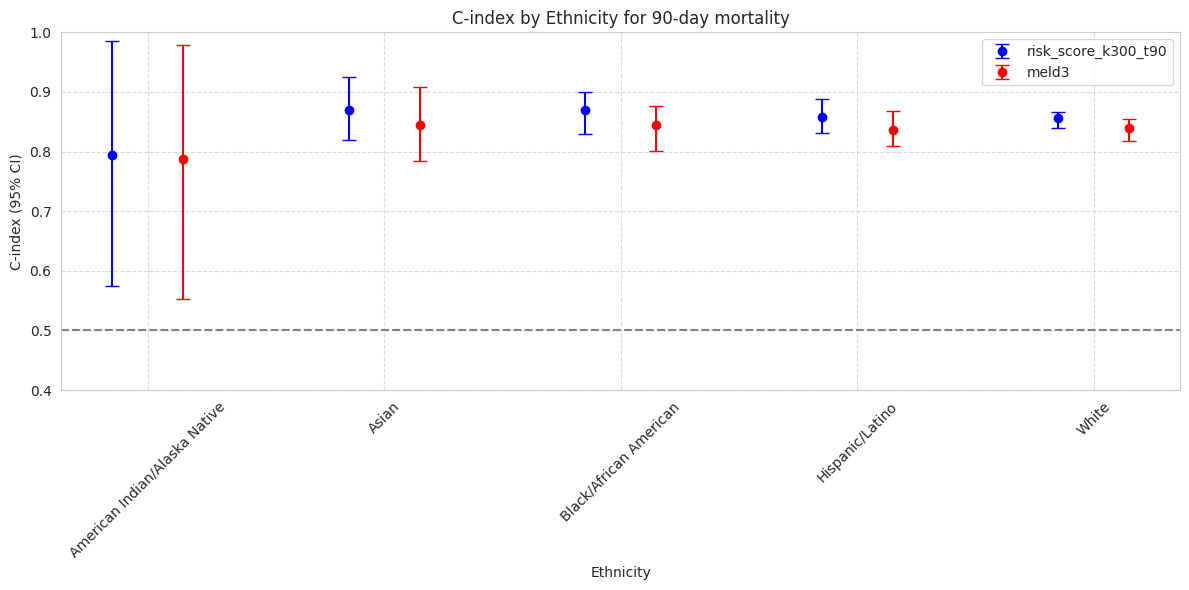


Results Summary:
                       Ethnicity  n_patients  n_events  event_rate  risk_score_k300_t90_c_index  risk_score_k300_t90_ci_lower  risk_score_k300_t90_ci_upper  meld3_c_index  meld3_ci_lower  meld3_ci_upper  difference  diff_ci_lower  diff_ci_upper  p_value
0  American Indian/Alaska Native         128         6    4.687500                     0.793951                      0.574672                      0.985803       0.788280        0.552354        0.979357    0.005671      -0.024440       0.035328     0.50
1                          Asian         396        25    6.313131                     0.869809                      0.819306                      0.924722       0.844766        0.784413        0.907779    0.025043       0.004603       0.053937     0.04
2         Black/African American         907        74    8.158765                     0.869569                      0.829539                      0.900418       0.843785        0.800466        0.875691    0.025784      

In [ ]:
import pandas as pd
import numpy as np
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def ethnicity_subgroup_analysis(df,
                              risk_col="risk_score_k200_t90",
                              meld_col="meld3",
                              ethnicity_col="Ethnicity",
                              outcome_col="outcome",
                              tte_col="tte",
                              horizon=90,
                              n_bootstraps=100,
                              min_patients=20):
    """
    Perform subgroup analysis specifically for ethnicity groups.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        ethnicity_col: Column name for ethnicity
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizon: Time horizon in days
        n_bootstraps: Number of bootstrap samples
        min_patients: Minimum patients per subgroup for analysis

    Returns:
        DataFrame with c-index results for each ethnicity
    """
    np.random.seed(42)  # For reproducibility
    results = []

    # Ensure ethnicity column exists
    if ethnicity_col not in df.columns:
        print(f"Error: {ethnicity_col} column not found in the DataFrame")
        return pd.DataFrame()

    # Get unique ethnicities (excluding missing values)
    ethnicities = df[ethnicity_col].dropna().unique()
    print(f"Found {len(ethnicities)} different ethnicities: {ethnicities}")

    # Analyze each ethnicity group
    for ethnicity in sorted(ethnicities):
        print(f"\nAnalyzing {ethnicity_col}: {ethnicity}...")

        # Filter patients in this ethnicity
        ethnicity_mask = df[ethnicity_col] == ethnicity
        ethnicity_df = df[ethnicity_mask].copy()

        # Check if we have enough patients
        if len(ethnicity_df) < min_patients:
            print(f"  Skipping {ethnicity} (only {len(ethnicity_df)} patients, minimum {min_patients} required)")
            continue

        # Prepare data for analysis at specified time horizon
        ethnicity_df['event_t'] = ((ethnicity_df[outcome_col] == 0) &
                                  (ethnicity_df[tte_col] <= horizon)).astype(int)
        ethnicity_df['time_t'] = np.minimum(ethnicity_df[tte_col], horizon)

        # Drop rows with missing data for required columns
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        clean_df = ethnicity_df[needed_cols].dropna()

        # Check if we have enough events
        if len(clean_df) == 0 or clean_df['event_t'].sum() < 5:
            print(f"  Insufficient data or events in {ethnicity} after cleaning")
            continue

        # Count patients and events
        n_patients = len(clean_df)
        n_events = clean_df['event_t'].sum()
        event_rate = n_events / n_patients

        print(f"  Patients: {n_patients}, Events: {n_events} ({event_rate*100:.1f}%)")

        # Calculate c-indices on full data
        c_risk = concordance_index(
            clean_df['time_t'],
            -clean_df[risk_col],  # Negate because higher risk score = worse outcome
            clean_df['event_t']
        )

        c_meld = concordance_index(
            clean_df['time_t'],
            -clean_df[meld_col],  # Negate because higher MELD = worse outcome
            clean_df['event_t']
        )

        orig_diff = c_risk - c_meld

        # Bootstrap to get confidence intervals
        print(f"  Running {n_bootstraps} bootstrap iterations...")

        c_risk_boot = []
        c_meld_boot = []

        for _ in range(n_bootstraps):
            # Sample with replacement
            boot_idx = np.random.randint(0, n_patients, size=n_patients)
            boot_df = clean_df.iloc[boot_idx]

            # Skip if all or no events
            if boot_df['event_t'].sum() == 0 or boot_df['event_t'].sum() == len(boot_df):
                continue

            # Calculate c-indices for this bootstrap sample
            c_risk_b = concordance_index(
                boot_df['time_t'],
                -boot_df[risk_col],
                boot_df['event_t']
            )

            c_meld_b = concordance_index(
                boot_df['time_t'],
                -boot_df[meld_col],
                boot_df['event_t']
            )

            c_risk_boot.append(c_risk_b)
            c_meld_boot.append(c_meld_b)

        # Calculate confidence intervals
        c_risk_boot = np.array(c_risk_boot)
        c_meld_boot = np.array(c_meld_boot)
        diff_boot = c_risk_boot - c_meld_boot

        ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
        ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
        ci_diff = np.percentile(diff_boot, [2.5, 97.5])

        # Calculate p-value
        if orig_diff >= 0:
            p_one_sided = np.mean(diff_boot < 0)
        else:
            p_one_sided = np.mean(diff_boot > 0)
        p_value = min(2 * p_one_sided, 1.0)

        print(f"  {risk_col} c-index: {c_risk:.4f} (95% CI: {ci_risk[0]:.4f}-{ci_risk[1]:.4f})")
        print(f"  {meld_col} c-index: {c_meld:.4f} (95% CI: {ci_meld[0]:.4f}-{ci_meld[1]:.4f})")
        print(f"  Difference: {orig_diff:.4f} (95% CI: {ci_diff[0]:.4f}-{ci_diff[1]:.4f})")
        print(f"  p-value: {p_value:.4f}")

        # Store results
        results.append({
            'Ethnicity': ethnicity,
            'n_patients': n_patients,
            'n_events': n_events,
            'event_rate': event_rate*100,
            f'{risk_col}_c_index': c_risk,
            f'{risk_col}_ci_lower': ci_risk[0],
            f'{risk_col}_ci_upper': ci_risk[1],
            f'{meld_col}_c_index': c_meld,
            f'{meld_col}_ci_lower': ci_meld[0],
            f'{meld_col}_ci_upper': ci_meld[1],
            'difference': orig_diff,
            'diff_ci_lower': ci_diff[0],
            'diff_ci_upper': ci_diff[1],
            'p_value': p_value
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Create a simple visualization if we have results
    if len(results_df) > 0:
        # Plot the results
        plt.figure(figsize=(12, 6))
        ethnicities = results_df['Ethnicity']
        x_pos = np.arange(len(ethnicities))

        # Plot risk score c-indices
        plt.errorbar(
            x_pos - 0.15,
            results_df[f'{risk_col}_c_index'],
            yerr=[
                results_df[f'{risk_col}_c_index'] - results_df[f'{risk_col}_ci_lower'],
                results_df[f'{risk_col}_ci_upper'] - results_df[f'{risk_col}_c_index']
            ],
            fmt='o',
            color='blue',
            label=f'{risk_col}',
            capsize=5
        )

        # Plot MELD c-indices
        plt.errorbar(
            x_pos + 0.15,
            results_df[f'{meld_col}_c_index'],
            yerr=[
                results_df[f'{meld_col}_c_index'] - results_df[f'{meld_col}_ci_lower'],
                results_df[f'{meld_col}_ci_upper'] - results_df[f'{meld_col}_c_index']
            ],
            fmt='o',
            color='red',
            label=f'{meld_col}',
            capsize=5
        )

        # Set plot attributes
        plt.axhline(y=0.5, linestyle='--', color='gray')
        plt.xlabel('Ethnicity')
        plt.ylabel('C-index (95% CI)')
        plt.title(f'C-index by Ethnicity for {horizon}-day mortality')
        plt.xticks(x_pos, ethnicities, rotation=45)
        plt.ylim(0.4, 1.0)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results_df

# Example usage (run this)
# Assuming df is your dataframe that contains the needed columns
results = ethnicity_subgroup_analysis(
    df=df,  # Replace with your dataframe variable
    risk_col="risk_score_k300_t90",
    meld_col="meld3",
    ethnicity_col="Ethnicity",  # Adjust if your ethnicity column has a different name
    outcome_col="outcome",
    tte_col="tte",
    horizon=90,
    n_bootstraps=100,  # Reduced for faster computation
    min_patients=20
)

# Display results table
if len(results) > 0:
    print("\nResults Summary:")
    print(results)
else:
    print("\nNo results to display. Check if the ethnicity column exists and has sufficient data.")